In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error



In [2]:
immigration_data_2012_2021 = "Resources/immigration_data_2005_2021.csv"
#state_unemployment = "Resources/emp-unemployment.xls"
#gini = "Resources/gini_index_by_state_2016_2018.xlsx"

In [3]:
inmigration = pd.read_csv(immigration_data_2012_2021)
inmigration.head()

,Year,Region and country of birth,Total Permanent Residents,Percentage,Alabama,Alaska,Arizona,Arkansas,California,Colorado,...,Virginia,Washington,West Virginia,Wisconsin,Wyoming,U.S. Armed Services posts,U.S. possessions,U.S. Dependencies,Guam,Puerto Rico
0,2005,Total,1122373,100.00,4200,1525,18988,2698,232023,11977,...,27100,26482,847,7909,321,128,5868,0,0,0
1,2005,"China, People's Republic",69967,6.23,328,92,543,202,17668,765,...,1327,1508,101,593,28,13,184,0,0,0
2,2005,Dominican Republic,27504,2.45,5,42,22,0,82,6,...,90,18,6,39,0,0,2346,0,0,0
3,2005,India,84681,7.54,431,15,739,215,14724,516,...,2776,1747,133,876,0,0,24,0,0,0
4,2005,Iran,13887,1.24,48,4,285,9,7059,131,...,562,318,18,48,0,0,0,0,0,0


## Cleaning country regressor dataset

In [4]:
#Read the csv
countries_raw_metadata = pd.read_csv("Resources/countries_metadata.csv", encoding='latin-1')
display(countries_raw_metadata.head())
print(countries_raw_metadata.shape)

,Country Name,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
0,China,CHN,"Population, total",SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


(70, 67)


In [5]:
#Delete the "[YR..]" in the year columns
for column in countries_raw_metadata.columns:
    if "[YR" in column:
        new_column_name = column.split("[")[0].strip() # Extract the part before '[YR' and remove any leading/trailing spaces
        countries_raw_metadata.rename(columns={column: new_column_name}, inplace=True)
countries_raw_metadata.head()

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,CHN,"Population, total",SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


In [6]:
#Clean the "Country Names" columns 
unique_names = countries_raw_metadata["Country Name"].unique()
unique_names

array(['China', 'United States', 'Iran, Islamic Rep.', 'India',
       'Dominican Republic', 'Mexico', 'United Kingdom', 'Pakistan',
       'Philippines', nan,
       'Data from database: World Development Indicators',
       'Last Updated: 06/29/2023', 'Code', 'SP.POP.TOTL',
       'NY.GDP.PCAP.CD', 'SL.UEM.TOTL.NE.ZS',
       'Unemployment is a key measure to monitor whether a country is on track to achieve the Sustainable Development Goal of promoting sustained',
       'However', 'SP.URB.TOTL.IN.ZS',
       "Percentages urban are the numbers of persons residing in an area defined as ''urban'' per 100 total population. They are calculated by the Statistics Division of the United Nations Department of Economic and Social Affairs. Particular caution should be used in interpreting the figures for percentage urban for different countries.",
       'Countries differ in the way they classify population as "urban" or "rural." The population of a city or metropolitan area depends on the bou

In [7]:
#List the country names we want to keep.
attributes_to_keep = ['China', 'United States', 'Iran, Islamic Rep.', 'India', 'Dominican Republic', 'Mexico', 'United Kingdom', 'Pakistan', 'Philippines']

# Filter the DataFrame to keep only the desired attributes
df_filtered = countries_raw_metadata[countries_raw_metadata['Country Name'].isin(attributes_to_keep)]

# Print the filtered DataFrame
df_filtered.head()

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,CHN,"Population, total",SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


In [8]:
#Prepare the "Series Name" to move it to the columns, these will be our regressors. 
series_names = df_filtered["Series Name"].unique()
series_names

array(['Population, total', 'GDP per capita (current US$)',
       'Unemployment, total (% of total labor force) (national estimate)',
       'Urban population (% of total population)',
       'Birth rate, crude (per 1,000 people)', 'Gini index'], dtype=object)

In [9]:
df_filtered.loc[df_filtered["Series Name"] == 'Population, total', "Series Name"] = "Population_total"
df_filtered.loc[df_filtered["Series Name"] == 'GDP per capita (current US$)', "Series Name"] = "GDP_per_capita"
df_filtered.loc[df_filtered["Series Name"] == 'Unemployment, total (% of total labor force) (national estimate)', "Series Name"] = "UR"
df_filtered.loc[df_filtered["Series Name"] == 'Urban population (% of total population)', "Series Name"] = "Urban_population"
df_filtered.loc[df_filtered["Series Name"] == 'Birth rate, crude (per 1,000 people)', "Series Name"] = "Birth_rate_crude"
df_filtered.loc[df_filtered["Series Name"] == 'Gini index', "Series Name"] = "Gini_index"
df_filtered.loc[df_filtered["Country Name"] == 'Iran, Islamic Rep.', "Country Name"] = "Iran"
df_filtered

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,CHN,Population_total,SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP_per_capita,NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,UR,SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban_population,SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,Birth_rate_crude,SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..
5,China,CHN,Gini_index,SI.POV.GINI,..,..,..,..,..,..,...,39.7,39.2,38.6,38.5,39.1,3.850000e+01,38.2,..,..,..
6,United States,USA,Population_total,SP.POP.TOTL,180671000,183691000,186538000,189242000,191889000,194303000,...,316059947,318386329,320738994,323071755,325122128,3.268382e+08,328329953,331511512,332031554,333287557
7,United States,USA,GDP_per_capita,NY.GDP.PCAP.CD,3007.12344537862,3066.56286916615,3243.84307754988,3374.51517105082,3573.94118474743,3827.52710972039,...,53291.1276891406,55123.8497869046,56762.7294515989,57866.7449341091,59907.754260885,6.282331e+04,65120.3946628653,63528.6343027508,70219.472454115,76398.5917422054
8,United States,USA,UR,SL.UEM.TOTL.NE.ZS,5.5,6.7,5.5,5.7,5.2,4.5,...,7.37,6.17,5.28,4.87,4.36,3.900000e+00,3.67,8.05,5.35,3.65
9,United States,USA,Urban_population,SP.URB.TOTL.IN.ZS,69.996,70.377,70.757,71.134,71.508,71.879,...,81.299,81.483,81.671,81.862,82.058,8.225600e+01,82.459,82.664,82.873,83.084


In [10]:
# Get rid the unnecessary columns
countries_regressors_raw = df_filtered.drop(columns= {"Country Code", "Series Code"} )
countries_regressors_raw.head()

,Country Name,Series Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,Population_total,667070000,660330000,665770000,682335000,698355000,715185000,735400000,754550000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,GDP_per_capita,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,104.324189073855,96.58918279471,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,UR,..,..,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,Urban_population,16.203,16.708,17.226,17.757,18.299,18.086,17.915,17.785,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,Birth_rate_crude,20.86,18.02,37.01,43.37,39.14,37.88,35.05,33.96,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


In [11]:
#countries_regressors_raw.info()

### Cleaning US state regressors

In [12]:
variables_by_state_raw = pd.read_csv("Resources/variable 2011-2021.csv")
variables_by_state_rename = variables_by_state_raw.rename(columns={"Unemployeement Rate": "UR_STATE",
                                                                  "GDP Per Capita":"GDP_per_capita_state", "Birth Rate":"Bith_rate_state"  })

# Multiply the "unemployment rate" column by 10
variables_by_state_rename["UR_STATE"] *= 10

## Cleaning inmigration csv

In [13]:
migration = inmigration.rename(columns={"Region and country of birth": "Country_origin", "Total Permanent Residents": "Total_inmigrants"})
migration = migration[migration["Country_origin"]!= "Total"]
migration = migration.drop(columns="Percentage")
migration["Country_origin"] = migration["Country_origin"].replace("China, People's Republic", "China")
migration

,Year,Country_origin,Total_inmigrants,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,...,Virginia,Washington,West Virginia,Wisconsin,Wyoming,U.S. Armed Services posts,U.S. possessions,U.S. Dependencies,Guam,Puerto Rico
1,2005,China,69967,328,92,543,202,17668,765,894,...,1327,1508,101,593,28,13,184,0,0,0
2,2005,Dominican Republic,27504,5,42,22,0,82,6,319,...,90,18,6,39,0,0,2346,0,0,0
3,2005,India,84681,431,15,739,215,14724,516,1571,...,2776,1747,133,876,0,0,24,0,0,0
4,2005,Iran,13887,48,4,285,9,7059,131,88,...,562,318,18,48,0,0,0,0,0,0
5,2005,Mexico,161445,569,96,8373,870,63092,2891,316,...,870,2330,30,1054,75,0,129,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2021,Iran,5734,21,0,86,17,2206,89,39,...,218,187,9,38,0,0,0,0,0,0
149,2021,Mexico,107230,323,33,6859,610,31715,3131,247,...,586,2539,20,949,69,0,0,0,0,39
150,2021,Pakistan,9691,31,0,59,41,1104,52,111,...,784,166,17,57,3,0,0,0,0,0
151,2021,Philippines,27511,152,190,555,129,6478,228,178,...,648,737,69,236,27,0,0,0,300,9


### Create a Database and store the cleaned dataset

In [14]:
# Create database with the desired file name for your SQLite database
conn = sqlite3.connect('use_migration.db')

# Store DatFrames in the database
migration.to_sql('migration', conn, index=False,  if_exists='replace')
countries_regressors_raw.to_sql('countries_regressors_raw', conn, index=False,  if_exists='replace')
variables_by_state_rename.to_sql('variables_by_state_rename', conn, index=False,  if_exists='replace')
conn.close()

In [15]:
## Check if the DataFrames have been successfully stored in the SQLite database

# Connect to the SQLite database
conn = sqlite3.connect('use_migration.db')

# Read the data from the database
query = "SELECT * FROM migration;"
df_migration = pd.read_sql_query(query, conn)

query = "SELECT * FROM countries_regressors_raw;"
df_countries_regressors_raw = pd.read_sql_query(query, conn)

query = "SELECT * FROM variables_by_state_rename;"
df_variables_by_state_rename = pd.read_sql_query(query, conn)

# Check the data
print("Data from migration:")
print(df_migration)

print("\nData from countries_regressors_raw:")
print(df_countries_regressors_raw)

print("\nData from variables_by_state_rename:")
print(df_variables_by_state_rename)

# Close the database connection
#conn.close()



Data from migration:
     Year      Country_origin  Total_inmigrants  Alabama  Alaska  Arizona  \
0    2005               China             69967      328      92      543   
1    2005  Dominican Republic             27504        5      42       22   
2    2005               India             84681      431      15      739   
3    2005                Iran             13887       48       4      285   
4    2005              Mexico            161445      569      96     8373   
..    ...                 ...               ...      ...     ...      ...   
131  2021                Iran              5734       21       0       86   
132  2021              Mexico            107230      323      33     6859   
133  2021            Pakistan              9691       31       0       59   
134  2021         Philippines             27511      152     190      555   
135  2021      United Kingdom              9229       48      13      179   

     Arkansas  California  Colorado  Connecticut  ... 

In [17]:
country_names=['China', 'India',
       'Dominican Republic', 'Mexico', 'United Kingdom', 'Pakistan',
       'Philippines']


state_names=['Alabama', 'Alaska',
       'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming']


results_df = pd.DataFrame(columns=['Country', 'State', 'MAE', 'MAPE','pred2023'])


for country in country_names:
    
    # Filter by country
    regressor_by_country = df_countries_regressors_raw.loc[countries_regressors_raw["Country Name"]== country]
    # Drop the Country Name column
    drop_countryname = regressor_by_country.drop(columns="Country Name")
    # Transpose rows per columns
    regressor_by_country_not_cleaned = drop_countryname.transpose()
    # Use the first row as the column names
    regressor_by_country_not_cleaned.columns = regressor_by_country_not_cleaned.iloc[0]
    # Drop the first row (previous integer index) since it's now redundant
    regressor_by_country_drop_row = regressor_by_country_not_cleaned.iloc[1:]
    print(country)
    regressor_by_country_reset_index = regressor_by_country_drop_row.reset_index().rename(columns={"index":"Year"})
    display(regressor_by_country_reset_index)
    regressor_by_country_reset_index["Year"] = regressor_by_country_reset_index["Year"].astype(int)
    regressor_by_country_reset_index["Population_total"] = regressor_by_country_reset_index["Population_total"].astype(int)
    regressor_by_country_reset_index["GDP_per_capita"] = regressor_by_country_reset_index["GDP_per_capita"].astype(float)
    regressor_by_country_reset_index['UR'].replace('..', np.nan, inplace=True)
    regressor_by_country_reset_index["UR"] = regressor_by_country_reset_index["UR"].astype(float)
    regressor_by_country_reset_index["Urban_population"] = regressor_by_country_reset_index["Urban_population"].astype(float)
    regressor_by_country_reset_index['Birth_rate_crude'].replace('..', np.nan, inplace=True)
    regressor_by_country_reset_index["Birth_rate_crude"] = regressor_by_country_reset_index["Birth_rate_crude"].astype(float)
    regressor_by_country_reset_index['Gini_index'].replace('..', np.nan, inplace=True)
    regressor_by_country_reset_index["Gini_index"] = regressor_by_country_reset_index["Gini_index"].astype(float)
    regressor_by_country = regressor_by_country_reset_index
    
    
    for state in state_names:



        # Getting the DataFrame with the years, total number of inmigrants in the US for a given country and 
        # the number of inmigrants of this country in one US state
        migration.reset_index(drop=True, inplace=True)
        county_origin_us_df = df_migration[migration["Country_origin"]==country]
        country_columns = ["Year","Total_inmigrants",state]
        inmigration_us_df = county_origin_us_df[country_columns]

        #Filter by state
        state_test = df_variables_by_state_rename[variables_by_state_rename["State"]==state]
        regressor_by_state = state_test.drop(columns= "State").reset_index(drop=True)
    
        # First merge inmigration_us_df and regressor_by_country
        df_merged1 = pd.merge(inmigration_us_df, regressor_by_country, on="Year", how="left")

        # Then merge the result with regressor_by_state
        df_merged = pd.merge(df_merged1, regressor_by_state, on="Year", how="left")

        
        # PROPHET TRAINING
        
        # Handle NaN values in the DataFrame
        # For simplicity, we'll fill the NaN values with the column means
        df_merged.fillna(df_merged.mean(), inplace=True)
    
    
        
        # Step 1: Prepare the DataFrame with time series data and regressors
        prophet_df = df_merged[['Year', state, 'Population_total', 'GDP_per_capita', 'UR', 'Urban_population', 'Birth_rate_crude', 'Gini_index', 'GDP', 'GDP_per_capita_state']].copy()
        prophet_df.rename(columns={'Year': 'ds', state: 'y'}, inplace=True)
        prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

        # Step 2: Handle missing values in the DataFrame
        imputer = SimpleImputer(strategy='mean')
        prophet_df[['Population_total', 'GDP_per_capita', 'UR', 'Urban_population', 'Gini_index', 'GDP', 'GDP_per_capita_state']] = imputer.fit_transform(prophet_df[['Population_total', 'GDP_per_capita', 'UR', 'Urban_population', 'Gini_index', 'GDP',  'GDP_per_capita_state']])

        prophet_df_2=prophet_df[:-1].copy()


        # Separate the target variable 'y' and other features
        X = prophet_df_2.drop(columns=['y','ds'])
        y = prophet_df_2['y']

        # Create a Random Forest Regressor model
        rf = RandomForestRegressor(random_state=42)
        rf.fit(X, y)

        # Get the feature importances
        feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})

        # Sort the features by importance in descending order
        feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

        # Display the feature importances
        print("Feature importance for "+country+" and "+state+" "+str(feature_importances))


        top_n_features = feature_importances['Feature'][:3].tolist()


        prophet_df_pred=prophet_df[:-1].copy()

        prophet_df_pred['y']=np.log1p(prophet_df_pred['y'])

        # Step 3: Set up the Prophet model with additional regressors
        holidays = pd.DataFrame({
            'holiday': '2020',
            'ds': pd.to_datetime(['2020-01-01']),
            'lower_window': 0,
            'upper_window': 0,
        })

        model = Prophet(holidays=holidays)

        for feature in top_n_features:
            model.add_regressor(feature)


        # Step 4: Fit the model to your data
        model.fit(prophet_df_pred)
        
        regressors_row_2021 = prophet_df.iloc[-1, :][top_n_features].to_dict()

        future_dates=pd.DataFrame({'ds': pd.to_datetime(['2021'], format='%Y')})


        # Step 5: Create a DataFrame with the future dates for prediction (e.g., for 2021)
        for feature in top_n_features:
            future_dates[feature] = regressors_row_2021[feature]


        future_dates["ds"]=pd.to_datetime('2021', format='%Y')

        # Step 6: Predict the number of immigrants for the future dates
        forecast = model.predict(future_dates)

        # Step 7: Extract the predicted values for the future dates
        predicted_values = np.exp(forecast['yhat'])

        # Step 8: Display the predicted values for 2021

        from sklearn.metrics import mean_absolute_error
        y_true=df_merged[state][-1:].values
        print("2021- Real data for "+country+" "+state+":"+str(y_true))
        y_pred=np.exp(forecast['yhat'].values)
        print("2021- Predicted for "+country+" "+state+": "+str(y_pred))
        mae=mean_absolute_error(y_true,y_pred)
        print("The MAE while testing 2021 for "+country+" "+state+": "+str(mae))
        mape=mean_absolute_percentage_error(y_true, y_pred)
        print("The MAPE while testing 2021 for "+country+" "+state+": "+str(mape))
        
        
        #mae = mean_absolute_error(y_true, y_pred)
        #mse = mean_squared_error(y_true, y_pred)
        #rmse = np.sqrt(mse)
        #r2 = r2_score(y_true, y_pred)

        #print("Mean Absolute Error (MAE):", mae)
        #print("Mean Squared Error (MSE):", mse)
        #print("Root Mean Squared Error (RMSE):", rmse)
        #print("R-squared (R2):", r2)

        
        future_dates["ds"]=pd.to_datetime('2023', format='%Y')

        forecast=model.predict(future_dates)
        predicted_values = forecast[['ds', 'yhat']]
        print("2023- Predicted for "+country+" "+state+": " +str(np.exp(forecast['yhat'].values)))

        import matplotlib.pyplot as plt

        #fig=model.plot(forecast)
        #plt.scatter(pd.to_datetime(['2023'], format='%Y'), forecast['yhat'], c='r', s=100, label='2023 Prediction')
        #plt.legend()
        #plt.show()

        results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},
                                       ignore_index=True)
        
        
        del(prophet_df)
        del(prophet_df_2)
        del(prophet_df_pred)
        del(model)
        


China


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,667070000,89.5202179159242,..,16.203,20.86,..
1,1961,660330000,75.8055639067957,..,16.708,18.02,..
2,1962,665770000,70.9091553472599,..,17.226,37.01,..
3,1963,682335000,74.3133748233246,..,17.757,43.37,..
4,1964,698355000,85.4982461036748,..,18.299,39.14,..
...,...,...,...,...,...,...,...
58,2018,1402760000.0,9905.406118,4.93,59.152,10.86,38.5
59,2019,1407745000,10143.8602060373,5.15,60.308,10.41,38.2
60,2020,1411100000,10408.7191247747,5.61,61.428,8.52,..
61,2021,1412360000,12617.5049863004,5.11,62.512,7.52,..


Feature importance for China and Alabama                 Feature  Importance
2                    UR    0.182732
1        GDP_per_capita    0.175623
4      Birth_rate_crude    0.169791
3      Urban_population    0.149991
0      Population_total    0.129925
6                   GDP    0.112015
5            Gini_index    0.054558
7  GDP_per_capita_state    0.025365


07:59:40 - cmdstanpy - INFO - Chain [1] start processing
07:59:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Alabama:[146]
2021- Predicted for China Alabama: [129.27804359]
The MAE while testing 2021 for China Alabama: 16.721956408774304
The MAPE while testing 2021 for China Alabama: 0.11453394800530345
2023- Predicted for China Alabama: [121.08752729]
Feature importance for China and Alaska                 Feature  Importance
1        GDP_per_capita    0.341818
0      Population_total    0.291961
3      Urban_population    0.277579
5            Gini_index    0.041019
4      Birth_rate_crude    0.017123
2                    UR    0.014310
6                   GDP    0.011054
7  GDP_per_capita_state    0.005136


07:59:40 - cmdstanpy - INFO - Chain [1] start processing
07:59:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Alaska:[20]
2021- Predicted for China Alaska: [23.48943793]
The MAE while testing 2021 for China Alaska: 3.4894379322071245
The MAPE while testing 2021 for China Alaska: 0.17447189661035623
2023- Predicted for China Alaska: [11.94159858]
Feature importance for China and Arizona                 Feature  Importance
4      Birth_rate_crude    0.214213
5            Gini_index    0.167290
0      Population_total    0.135937
1        GDP_per_capita    0.128047
6                   GDP    0.114899
2                    UR    0.098378
3      Urban_population    0.090038
7  GDP_per_capita_state    0.051199


07:59:41 - cmdstanpy - INFO - Chain [1] start processing
07:59:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Arizona:[437]
2021- Predicted for China Arizona: [394.33574537]
The MAE while testing 2021 for China Arizona: 42.66425462760833
The MAPE while testing 2021 for China Arizona: 0.09762987328972157
2023- Predicted for China Arizona: [555.81096124]
Feature importance for China and Arkansas                 Feature  Importance
5            Gini_index    0.251707
2                    UR    0.204603
1        GDP_per_capita    0.143316
4      Birth_rate_crude    0.138181
3      Urban_population    0.108070
0      Population_total    0.092016
7  GDP_per_capita_state    0.042139
6                   GDP    0.019968


07:59:41 - cmdstanpy - INFO - Chain [1] start processing
07:59:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Arkansas:[74]
2021- Predicted for China Arkansas: [113.16198411]
The MAE while testing 2021 for China Arkansas: 39.16198410538318
The MAPE while testing 2021 for China Arkansas: 0.5292160014240971
2023- Predicted for China Arkansas: [120.73383625]
Feature importance for China and California                 Feature  Importance
4      Birth_rate_crude    0.412685
2                    UR    0.111527
5            Gini_index    0.097420
1        GDP_per_capita    0.096806
3      Urban_population    0.095767
0      Population_total    0.066717
7  GDP_per_capita_state    0.064071
6                   GDP    0.055006


07:59:42 - cmdstanpy - INFO - Chain [1] start processing
07:59:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China California:[17705]
2021- Predicted for China California: [16112.23532514]
The MAE while testing 2021 for China California: 1592.7646748647821
The MAPE while testing 2021 for China California: 0.0899612920002701
2023- Predicted for China California: [21622.30938621]
Feature importance for China and Colorado                 Feature  Importance
5            Gini_index    0.243050
1        GDP_per_capita    0.191062
3      Urban_population    0.162657
0      Population_total    0.161219
2                    UR    0.111184
4      Birth_rate_crude    0.096425
7  GDP_per_capita_state    0.019983
6                   GDP    0.014421


07:59:42 - cmdstanpy - INFO - Chain [1] start processing
07:59:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Colorado:[399]
2021- Predicted for China Colorado: [657.35769762]
The MAE while testing 2021 for China Colorado: 258.3576976183699
The MAPE while testing 2021 for China Colorado: 0.6475130266124559
2023- Predicted for China Colorado: [3912.11294485]
Feature importance for China and Connecticut                 Feature  Importance
1        GDP_per_capita    0.314018
0      Population_total    0.238518
3      Urban_population    0.211533
5            Gini_index    0.082691
2                    UR    0.057958
4      Birth_rate_crude    0.044194
7  GDP_per_capita_state    0.033309
6                   GDP    0.017780


07:59:43 - cmdstanpy - INFO - Chain [1] start processing
07:59:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Connecticut:[368]
2021- Predicted for China Connecticut: [392.9346178]
The MAE while testing 2021 for China Connecticut: 24.93461779518509
The MAPE while testing 2021 for China Connecticut: 0.06775711357387253
2023- Predicted for China Connecticut: [288.88720534]
Feature importance for China and Delaware                 Feature  Importance
7  GDP_per_capita_state    0.307623
4      Birth_rate_crude    0.201900
3      Urban_population    0.106552
1        GDP_per_capita    0.100863
6                   GDP    0.100589
0      Population_total    0.091393
5            Gini_index    0.077482
2                    UR    0.013597


07:59:43 - cmdstanpy - INFO - Chain [1] start processing
07:59:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Delaware:[151]
2021- Predicted for China Delaware: [203.88372311]
The MAE while testing 2021 for China Delaware: 52.883723105046556
The MAPE while testing 2021 for China Delaware: 0.3502233318215004
2023- Predicted for China Delaware: [2641.61368943]
Feature importance for China and District of Columbia                 Feature  Importance
7  GDP_per_capita_state    0.669273
4      Birth_rate_crude    0.193909
0      Population_total    0.033923
3      Urban_population    0.030184
2                    UR    0.028620
5            Gini_index    0.018722
6                   GDP    0.012784
1        GDP_per_capita    0.012586


07:59:44 - cmdstanpy - INFO - Chain [1] start processing
07:59:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China District of Columbia:[58]
2021- Predicted for China District of Columbia: [11.11996747]
The MAE while testing 2021 for China District of Columbia: 46.88003252931553
The MAPE while testing 2021 for China District of Columbia: 0.8082764229192333
2023- Predicted for China District of Columbia: [6.23605398]
Feature importance for China and Florida                 Feature  Importance
4      Birth_rate_crude    0.292963
2                    UR    0.216353
0      Population_total    0.133421
1        GDP_per_capita    0.110635
7  GDP_per_capita_state    0.100137
3      Urban_population    0.074505
5            Gini_index    0.049401
6                   GDP    0.022584


07:59:44 - cmdstanpy - INFO - Chain [1] start processing
07:59:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Florida:[1037]
2021- Predicted for China Florida: [1864.17927392]
The MAE while testing 2021 for China Florida: 827.1792739233413
The MAPE while testing 2021 for China Florida: 0.7976656450562597
2023- Predicted for China Florida: [3160.17810838]
Feature importance for China and Georgia                 Feature  Importance
4      Birth_rate_crude    0.567507
2                    UR    0.099151
0      Population_total    0.086965
3      Urban_population    0.081725
1        GDP_per_capita    0.080022
7  GDP_per_capita_state    0.039518
6                   GDP    0.023733
5            Gini_index    0.021379


07:59:45 - cmdstanpy - INFO - Chain [1] start processing
07:59:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Georgia:[734]
2021- Predicted for China Georgia: [509.47553287]
The MAE while testing 2021 for China Georgia: 224.52446713323206
The MAPE while testing 2021 for China Georgia: 0.305891644595684
2023- Predicted for China Georgia: [318.10973711]
Feature importance for China and Hawaii                 Feature  Importance
1        GDP_per_capita    0.216725
0      Population_total    0.174471
5            Gini_index    0.166986
3      Urban_population    0.163808
4      Birth_rate_crude    0.134638
6                   GDP    0.057790
7  GDP_per_capita_state    0.044394
2                    UR    0.041188


07:59:45 - cmdstanpy - INFO - Chain [1] start processing
07:59:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Hawaii:[358]
2021- Predicted for China Hawaii: [695.33710964]
The MAE while testing 2021 for China Hawaii: 337.33710963961664
The MAPE while testing 2021 for China Hawaii: 0.9422824291609403
2023- Predicted for China Hawaii: [1509.12669089]
Feature importance for China and Idaho                 Feature  Importance
5            Gini_index    0.244225
0      Population_total    0.151591
1        GDP_per_capita    0.142584
2                    UR    0.137787
4      Birth_rate_crude    0.120214
3      Urban_population    0.113268
6                   GDP    0.057292
7  GDP_per_capita_state    0.033038


07:59:46 - cmdstanpy - INFO - Chain [1] start processing
07:59:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Idaho:[102]
2021- Predicted for China Idaho: [63.43300919]
The MAE while testing 2021 for China Idaho: 38.566990809081474
The MAPE while testing 2021 for China Idaho: 0.37810775303021055
2023- Predicted for China Idaho: [59.07332394]
Feature importance for China and Illinois                 Feature  Importance
4      Birth_rate_crude    0.356479
2                    UR    0.118362
7  GDP_per_capita_state    0.110457
6                   GDP    0.098048
0      Population_total    0.093028
1        GDP_per_capita    0.083677
3      Urban_population    0.082749
5            Gini_index    0.057200


07:59:46 - cmdstanpy - INFO - Chain [1] start processing
07:59:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Illinois:[1480]
2021- Predicted for China Illinois: [1559.919054]
The MAE while testing 2021 for China Illinois: 79.91905399615462
The MAPE while testing 2021 for China Illinois: 0.053999360808212576
2023- Predicted for China Illinois: [2170.78522137]
Feature importance for China and Indiana                 Feature  Importance
2                    UR    0.214710
4      Birth_rate_crude    0.178015
1        GDP_per_capita    0.173129
0      Population_total    0.160771
3      Urban_population    0.143091
5            Gini_index    0.091000
6                   GDP    0.027319
7  GDP_per_capita_state    0.011965


07:59:57 - cmdstanpy - INFO - Chain [1] start processing
07:59:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Indiana:[340]
2021- Predicted for China Indiana: [402.15146332]
The MAE while testing 2021 for China Indiana: 62.15146332007515
The MAPE while testing 2021 for China Indiana: 0.1827984215296328
2023- Predicted for China Indiana: [423.95933219]
Feature importance for China and Iowa                 Feature  Importance
4      Birth_rate_crude    0.222943
2                    UR    0.179803
1        GDP_per_capita    0.126057
3      Urban_population    0.123184
0      Population_total    0.119072
7  GDP_per_capita_state    0.086051
5            Gini_index    0.078722
6                   GDP    0.064169


07:59:58 - cmdstanpy - INFO - Chain [1] start processing
07:59:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Iowa:[153]
2021- Predicted for China Iowa: [218.29096085]
The MAE while testing 2021 for China Iowa: 65.29096084552532
The MAPE while testing 2021 for China Iowa: 0.42673830617990405
2023- Predicted for China Iowa: [162.87953651]
Feature importance for China and Kansas                 Feature  Importance
4      Birth_rate_crude    0.164713
2                    UR    0.157478
1        GDP_per_capita    0.144632
0      Population_total    0.136851
5            Gini_index    0.119572
7  GDP_per_capita_state    0.109163
3      Urban_population    0.106791
6                   GDP    0.060802


07:59:58 - cmdstanpy - INFO - Chain [1] start processing
07:59:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Kansas:[124]
2021- Predicted for China Kansas: [212.46017539]
The MAE while testing 2021 for China Kansas: 88.46017538708028
The MAPE while testing 2021 for China Kansas: 0.7133885111861313
2023- Predicted for China Kansas: [161.76498703]
Feature importance for China and Kentucky                 Feature  Importance
1        GDP_per_capita    0.184226
0      Population_total    0.178728
2                    UR    0.161936
3      Urban_population    0.149178
4      Birth_rate_crude    0.091950
5            Gini_index    0.089531
6                   GDP    0.076881
7  GDP_per_capita_state    0.067570


07:59:59 - cmdstanpy - INFO - Chain [1] start processing
07:59:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Kentucky:[125]
2021- Predicted for China Kentucky: [140.74181371]
The MAE while testing 2021 for China Kentucky: 15.741813707996158
The MAPE while testing 2021 for China Kentucky: 0.12593450966396927
2023- Predicted for China Kentucky: [88.65808637]
Feature importance for China and Louisiana                 Feature  Importance
4      Birth_rate_crude    0.208532
5            Gini_index    0.203669
7  GDP_per_capita_state    0.158029
0      Population_total    0.103754
2                    UR    0.102794
1        GDP_per_capita    0.090292
3      Urban_population    0.088379
6                   GDP    0.044551


07:59:59 - cmdstanpy - INFO - Chain [1] start processing
07:59:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Louisiana:[123]
2021- Predicted for China Louisiana: [193.46659434]
The MAE while testing 2021 for China Louisiana: 70.46659434469535
The MAPE while testing 2021 for China Louisiana: 0.5728991410137834
2023- Predicted for China Louisiana: [207.94073738]
Feature importance for China and Maine                 Feature  Importance
1        GDP_per_capita    0.244543
0      Population_total    0.231711
3      Urban_population    0.182835
5            Gini_index    0.111189
2                    UR    0.103156
4      Birth_rate_crude    0.062757
6                   GDP    0.032825
7  GDP_per_capita_state    0.030984


08:00:00 - cmdstanpy - INFO - Chain [1] start processing
08:00:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Maine:[36]
2021- Predicted for China Maine: [26.88987117]
The MAE while testing 2021 for China Maine: 9.110128834557536
The MAPE while testing 2021 for China Maine: 0.2530591342932649
2023- Predicted for China Maine: [4.93459713]
Feature importance for China and Maryland                 Feature  Importance
4      Birth_rate_crude    0.347686
2                    UR    0.278373
1        GDP_per_capita    0.121471
3      Urban_population    0.086197
0      Population_total    0.078210
5            Gini_index    0.040185
7  GDP_per_capita_state    0.030142
6                   GDP    0.017737


08:00:00 - cmdstanpy - INFO - Chain [1] start processing
08:00:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Maryland:[843]
2021- Predicted for China Maryland: [1017.35400558]
The MAE while testing 2021 for China Maryland: 174.35400558218498
The MAPE while testing 2021 for China Maryland: 0.2068256293976097
2023- Predicted for China Maryland: [1113.18321862]
Feature importance for China and Massachusetts                 Feature  Importance
4      Birth_rate_crude    0.310697
5            Gini_index    0.177182
2                    UR    0.174788
0      Population_total    0.088220
3      Urban_population    0.074863
1        GDP_per_capita    0.074089
7  GDP_per_capita_state    0.069726
6                   GDP    0.030435


08:00:01 - cmdstanpy - INFO - Chain [1] start processing
08:00:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Massachusetts:[2059]
2021- Predicted for China Massachusetts: [1784.55939439]
The MAE while testing 2021 for China Massachusetts: 274.4406056095427
The MAPE while testing 2021 for China Massachusetts: 0.13328829801337672
2023- Predicted for China Massachusetts: [1828.28080782]
Feature importance for China and Michigan                 Feature  Importance
1        GDP_per_capita    0.241372
3      Urban_population    0.169402
0      Population_total    0.158588
5            Gini_index    0.148921
2                    UR    0.140613
4      Birth_rate_crude    0.123958
7  GDP_per_capita_state    0.009605
6                   GDP    0.007540


08:00:12 - cmdstanpy - INFO - Chain [1] start processing
08:00:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Michigan:[743]
2021- Predicted for China Michigan: [775.86412628]
The MAE while testing 2021 for China Michigan: 32.864126280630785
The MAPE while testing 2021 for China Michigan: 0.04423166390394453
2023- Predicted for China Michigan: [1627.18727329]
Feature importance for China and Minnesota                 Feature  Importance
1        GDP_per_capita    0.209093
0      Population_total    0.180995
3      Urban_population    0.170571
5            Gini_index    0.150138
2                    UR    0.137772
4      Birth_rate_crude    0.067166
6                   GDP    0.060250
7  GDP_per_capita_state    0.024016


08:00:12 - cmdstanpy - INFO - Chain [1] start processing
08:00:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Minnesota:[342]
2021- Predicted for China Minnesota: [444.12742782]
The MAE while testing 2021 for China Minnesota: 102.12742781785039
The MAPE while testing 2021 for China Minnesota: 0.2986182099937146
2023- Predicted for China Minnesota: [242.80181121]
Feature importance for China and Mississippi                 Feature  Importance
4      Birth_rate_crude    0.389607
2                    UR    0.191868
1        GDP_per_capita    0.106287
0      Population_total    0.095656
3      Urban_population    0.080130
5            Gini_index    0.077926
7  GDP_per_capita_state    0.048146
6                   GDP    0.010382


08:00:13 - cmdstanpy - INFO - Chain [1] start processing
08:00:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Mississippi:[45]
2021- Predicted for China Mississippi: [85.10718686]
The MAE while testing 2021 for China Mississippi: 40.107186858530625
The MAPE while testing 2021 for China Mississippi: 0.8912708190784583
2023- Predicted for China Mississippi: [81.3561581]
Feature importance for China and Missouri                 Feature  Importance
5            Gini_index    0.384549
4      Birth_rate_crude    0.165649
2                    UR    0.123368
0      Population_total    0.086396
1        GDP_per_capita    0.082468
3      Urban_population    0.071072
7  GDP_per_capita_state    0.051816
6                   GDP    0.034683


08:00:13 - cmdstanpy - INFO - Chain [1] start processing
08:00:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Missouri:[253]
2021- Predicted for China Missouri: [403.92525019]
The MAE while testing 2021 for China Missouri: 150.9252501892184
The MAPE while testing 2021 for China Missouri: 0.5965424908664758
2023- Predicted for China Missouri: [423.72140123]
Feature importance for China and Montana                 Feature  Importance
4      Birth_rate_crude    0.213560
2                    UR    0.175143
1        GDP_per_capita    0.138910
0      Population_total    0.127693
3      Urban_population    0.106735
5            Gini_index    0.101570
6                   GDP    0.071338
7  GDP_per_capita_state    0.065051


08:00:14 - cmdstanpy - INFO - Chain [1] start processing
08:00:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Montana:[26]
2021- Predicted for China Montana: [30.14558083]
The MAE while testing 2021 for China Montana: 4.145580830004526
The MAPE while testing 2021 for China Montana: 0.15944541653863561
2023- Predicted for China Montana: [27.23686176]
Feature importance for China and Nebraska                 Feature  Importance
5            Gini_index    0.181350
2                    UR    0.174837
6                   GDP    0.142946
4      Birth_rate_crude    0.131190
0      Population_total    0.128562
1        GDP_per_capita    0.107192
3      Urban_population    0.077015
7  GDP_per_capita_state    0.056908


08:00:14 - cmdstanpy - INFO - Chain [1] start processing
08:00:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Nebraska:[85]
2021- Predicted for China Nebraska: [111.35922874]
The MAE while testing 2021 for China Nebraska: 26.359228742697965
The MAPE while testing 2021 for China Nebraska: 0.31010857344350545
2023- Predicted for China Nebraska: [111.54761498]
Feature importance for China and Nevada                 Feature  Importance
4      Birth_rate_crude    0.317285
0      Population_total    0.159095
1        GDP_per_capita    0.153191
3      Urban_population    0.117442
2                    UR    0.102267
5            Gini_index    0.095812
6                   GDP    0.031613
7  GDP_per_capita_state    0.023295


08:00:15 - cmdstanpy - INFO - Chain [1] start processing
08:00:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Nevada:[503]
2021- Predicted for China Nevada: [428.41741539]
The MAE while testing 2021 for China Nevada: 74.5825846115743
The MAPE while testing 2021 for China Nevada: 0.14827551612639026
2023- Predicted for China Nevada: [412.81237069]
Feature importance for China and New Hampshire                 Feature  Importance
1        GDP_per_capita    0.236971
0      Population_total    0.230885
3      Urban_population    0.184409
2                    UR    0.121990
7  GDP_per_capita_state    0.075569
6                   GDP    0.066972
4      Birth_rate_crude    0.053113
5            Gini_index    0.030092


08:00:15 - cmdstanpy - INFO - Chain [1] start processing
08:00:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China New Hampshire:[75]
2021- Predicted for China New Hampshire: [39.9559903]
The MAE while testing 2021 for China New Hampshire: 35.044009696926175
The MAPE while testing 2021 for China New Hampshire: 0.46725346262568235
2023- Predicted for China New Hampshire: [6.55135903]
Feature importance for China and New Jersey                 Feature  Importance
4      Birth_rate_crude    0.176378
1        GDP_per_capita    0.172343
0      Population_total    0.168602
3      Urban_population    0.167644
2                    UR    0.144986
6                   GDP    0.072251
5            Gini_index    0.062278
7  GDP_per_capita_state    0.035519


08:00:16 - cmdstanpy - INFO - Chain [1] start processing
08:00:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China New Jersey:[1895]
2021- Predicted for China New Jersey: [1482.25441522]
The MAE while testing 2021 for China New Jersey: 412.7455847757567
The MAPE while testing 2021 for China New Jersey: 0.21780769645158665
2023- Predicted for China New Jersey: [1515.49188159]
Feature importance for China and New Mexico                 Feature  Importance
1        GDP_per_capita    0.294221
0      Population_total    0.239002
3      Urban_population    0.212698
5            Gini_index    0.139810
4      Birth_rate_crude    0.039757
7  GDP_per_capita_state    0.032988
2                    UR    0.029758
6                   GDP    0.011766


08:00:16 - cmdstanpy - INFO - Chain [1] start processing
08:00:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China New Mexico:[85]
2021- Predicted for China New Mexico: [101.47098144]
The MAE while testing 2021 for China New Mexico: 16.470981439026275
The MAPE while testing 2021 for China New Mexico: 0.19377625222383854
2023- Predicted for China New Mexico: [159.4750106]
Feature importance for China and New York                 Feature  Importance
4      Birth_rate_crude    0.165306
0      Population_total    0.148061
5            Gini_index    0.145786
2                    UR    0.124945
1        GDP_per_capita    0.113997
3      Urban_population    0.110780
6                   GDP    0.096419
7  GDP_per_capita_state    0.094707


08:00:17 - cmdstanpy - INFO - Chain [1] start processing
08:00:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China New York:[7812]
2021- Predicted for China New York: [9612.44545285]
The MAE while testing 2021 for China New York: 1800.4454528478454
The MAPE while testing 2021 for China New York: 0.2304717681576863
2023- Predicted for China New York: [11122.66988319]
Feature importance for China and North Carolina                 Feature  Importance
4      Birth_rate_crude    0.388290
2                    UR    0.157324
7  GDP_per_capita_state    0.109101
6                   GDP    0.086451
0      Population_total    0.082604
1        GDP_per_capita    0.062954
5            Gini_index    0.059682
3      Urban_population    0.053596


08:00:17 - cmdstanpy - INFO - Chain [1] start processing
08:00:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China North Carolina:[552]
2021- Predicted for China North Carolina: [592.66978159]
The MAE while testing 2021 for China North Carolina: 40.669781587834564
The MAPE while testing 2021 for China North Carolina: 0.07367714055767131
2023- Predicted for China North Carolina: [634.07417276]
Feature importance for China and North Dakota                 Feature  Importance
1        GDP_per_capita    0.189564
0      Population_total    0.183065
3      Urban_population    0.155483
5            Gini_index    0.110481
2                    UR    0.104974
4      Birth_rate_crude    0.098531
6                   GDP    0.084681
7  GDP_per_capita_state    0.073222


08:00:18 - cmdstanpy - INFO - Chain [1] start processing
08:00:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China North Dakota:[22]
2021- Predicted for China North Dakota: [13.99302732]
The MAE while testing 2021 for China North Dakota: 8.006972684477708
The MAPE while testing 2021 for China North Dakota: 0.3639533038398958
2023- Predicted for China North Dakota: [1.63986953]
Feature importance for China and Ohio                 Feature  Importance
0      Population_total    0.207214
1        GDP_per_capita    0.169307
2                    UR    0.155756
3      Urban_population    0.140640
5            Gini_index    0.113467
4      Birth_rate_crude    0.089377
7  GDP_per_capita_state    0.080192
6                   GDP    0.044047


08:00:18 - cmdstanpy - INFO - Chain [1] start processing
08:00:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Ohio:[756]
2021- Predicted for China Ohio: [640.32274619]
The MAE while testing 2021 for China Ohio: 115.67725381056903
The MAPE while testing 2021 for China Ohio: 0.15301224049017068
2023- Predicted for China Ohio: [674.87201796]
Feature importance for China and Oklahoma                 Feature  Importance
2                    UR    0.266591
4      Birth_rate_crude    0.238017
5            Gini_index    0.157269
0      Population_total    0.099675
1        GDP_per_capita    0.095500
3      Urban_population    0.072475
7  GDP_per_capita_state    0.035389
6                   GDP    0.035084


08:00:19 - cmdstanpy - INFO - Chain [1] start processing
08:00:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Oklahoma:[146]
2021- Predicted for China Oklahoma: [191.69096939]
The MAE while testing 2021 for China Oklahoma: 45.69096939497152
The MAPE while testing 2021 for China Oklahoma: 0.3129518451710378
2023- Predicted for China Oklahoma: [206.31203826]
Feature importance for China and Oregon                 Feature  Importance
4      Birth_rate_crude    0.205771
1        GDP_per_capita    0.180909
2                    UR    0.174565
0      Population_total    0.164083
3      Urban_population    0.143806
5            Gini_index    0.100846
7  GDP_per_capita_state    0.017341
6                   GDP    0.012678


08:00:19 - cmdstanpy - INFO - Chain [1] start processing
08:00:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Oregon:[468]
2021- Predicted for China Oregon: [545.10199832]
The MAE while testing 2021 for China Oregon: 77.10199832330602
The MAPE while testing 2021 for China Oregon: 0.1647478596651838
2023- Predicted for China Oregon: [661.45266469]
Feature importance for China and Pennsylvania                 Feature  Importance
4      Birth_rate_crude    0.254679
1        GDP_per_capita    0.159753
0      Population_total    0.158033
2                    UR    0.144163
3      Urban_population    0.129265
5            Gini_index    0.072489
7  GDP_per_capita_state    0.046654
6                   GDP    0.034965


08:00:19 - cmdstanpy - INFO - Chain [1] start processing
08:00:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Pennsylvania:[1107]
2021- Predicted for China Pennsylvania: [667.58714035]
The MAE while testing 2021 for China Pennsylvania: 439.41285964696806
The MAPE while testing 2021 for China Pennsylvania: 0.396940252616954
2023- Predicted for China Pennsylvania: [509.19151894]
Feature importance for China and Rhode Island                 Feature  Importance
1        GDP_per_capita    0.289959
0      Population_total    0.226834
3      Urban_population    0.226213
4      Birth_rate_crude    0.080768
2                    UR    0.057840
5            Gini_index    0.042300
7  GDP_per_capita_state    0.039139
6                   GDP    0.036947


08:00:20 - cmdstanpy - INFO - Chain [1] start processing
08:00:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Rhode Island:[71]
2021- Predicted for China Rhode Island: [52.5239372]
The MAE while testing 2021 for China Rhode Island: 18.476062799107304
The MAPE while testing 2021 for China Rhode Island: 0.2602262366071451
2023- Predicted for China Rhode Island: [20.4492653]
Feature importance for China and South Carolina                 Feature  Importance
4      Birth_rate_crude    0.310957
2                    UR    0.191480
1        GDP_per_capita    0.136430
0      Population_total    0.128375
3      Urban_population    0.088885
6                   GDP    0.057235
7  GDP_per_capita_state    0.044931
5            Gini_index    0.041708


08:00:20 - cmdstanpy - INFO - Chain [1] start processing
08:00:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China South Carolina:[182]
2021- Predicted for China South Carolina: [143.03865015]
The MAE while testing 2021 for China South Carolina: 38.961349854120726
The MAPE while testing 2021 for China South Carolina: 0.21407335084681717
2023- Predicted for China South Carolina: [146.82321039]
Feature importance for China and South Dakota                 Feature  Importance
1        GDP_per_capita    0.190337
0      Population_total    0.162236
2                    UR    0.157710
3      Urban_population    0.149659
4      Birth_rate_crude    0.131519
5            Gini_index    0.084124
6                   GDP    0.076399
7  GDP_per_capita_state    0.048016


08:00:21 - cmdstanpy - INFO - Chain [1] start processing
08:00:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China South Dakota:[0]
2021- Predicted for China South Dakota: [34.53868465]
The MAE while testing 2021 for China South Dakota: 34.5386846492612
The MAPE while testing 2021 for China South Dakota: 1.555484073162798e+17
2023- Predicted for China South Dakota: [31.15994925]
Feature importance for China and Tennessee                 Feature  Importance
2                    UR    0.219602
4      Birth_rate_crude    0.197260
1        GDP_per_capita    0.150714
0      Population_total    0.146085
3      Urban_population    0.120317
5            Gini_index    0.101478
6                   GDP    0.043385
7  GDP_per_capita_state    0.021158


08:00:21 - cmdstanpy - INFO - Chain [1] start processing
08:00:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Tennessee:[262]
2021- Predicted for China Tennessee: [295.48371739]
The MAE while testing 2021 for China Tennessee: 33.48371738500873
The MAPE while testing 2021 for China Tennessee: 0.12780044803438448
2023- Predicted for China Tennessee: [284.78083508]
Feature importance for China and Texas                 Feature  Importance
4      Birth_rate_crude    0.280844
0      Population_total    0.187919
3      Urban_population    0.160524
1        GDP_per_capita    0.158189
2                    UR    0.131022
5            Gini_index    0.043731
6                   GDP    0.025665
7  GDP_per_capita_state    0.012105


08:00:22 - cmdstanpy - INFO - Chain [1] start processing
08:00:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Texas:[2679]
2021- Predicted for China Texas: [2271.66152539]
The MAE while testing 2021 for China Texas: 407.33847460508014
The MAPE while testing 2021 for China Texas: 0.15204870272679363
2023- Predicted for China Texas: [1110.77380484]
Feature importance for China and Utah                 Feature  Importance
4      Birth_rate_crude    0.264735
7  GDP_per_capita_state    0.192588
2                    UR    0.169141
6                   GDP    0.155465
0      Population_total    0.072852
1        GDP_per_capita    0.050308
3      Urban_population    0.048275
5            Gini_index    0.046637


08:00:22 - cmdstanpy - INFO - Chain [1] start processing
08:00:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Utah:[262]
2021- Predicted for China Utah: [161.21363428]
The MAE while testing 2021 for China Utah: 100.7863657235682
The MAPE while testing 2021 for China Utah: 0.38468078520445875
2023- Predicted for China Utah: [207.9249174]
Feature importance for China and Vermont                 Feature  Importance
4      Birth_rate_crude    0.506698
5            Gini_index    0.107138
3      Urban_population    0.093548
2                    UR    0.089565
7  GDP_per_capita_state    0.070529
1        GDP_per_capita    0.058079
0      Population_total    0.056447
6                   GDP    0.017995


08:00:23 - cmdstanpy - INFO - Chain [1] start processing
08:00:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Vermont:[19]
2021- Predicted for China Vermont: [0.10635949]
The MAE while testing 2021 for China Vermont: 18.893640513548075
The MAPE while testing 2021 for China Vermont: 0.9944021322920039
2023- Predicted for China Vermont: [0.06569228]
Feature importance for China and Virginia                 Feature  Importance
2                    UR    0.290808
0      Population_total    0.140678
3      Urban_population    0.133387
4      Birth_rate_crude    0.131780
1        GDP_per_capita    0.126734
5            Gini_index    0.079741
7  GDP_per_capita_state    0.056455
6                   GDP    0.040416


08:00:23 - cmdstanpy - INFO - Chain [1] start processing
08:00:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Virginia:[834]
2021- Predicted for China Virginia: [978.25884372]
The MAE while testing 2021 for China Virginia: 144.25884372109863
The MAPE while testing 2021 for China Virginia: 0.1729722346775763
2023- Predicted for China Virginia: [1032.07829114]
Feature importance for China and Washington                 Feature  Importance
5            Gini_index    0.317969
1        GDP_per_capita    0.217522
3      Urban_population    0.204881
0      Population_total    0.181619
2                    UR    0.026039
4      Birth_rate_crude    0.022873
7  GDP_per_capita_state    0.016450
6                   GDP    0.012647


08:00:24 - cmdstanpy - INFO - Chain [1] start processing
08:00:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Washington:[3192]
2021- Predicted for China Washington: [2997.12022444]
The MAE while testing 2021 for China Washington: 194.87977556060378
The MAPE while testing 2021 for China Washington: 0.06105256126585331
2023- Predicted for China Washington: [204166.93579258]
Feature importance for China and West Virginia                 Feature  Importance
2                    UR    0.238207
0      Population_total    0.197766
1        GDP_per_capita    0.196575
3      Urban_population    0.168087
4      Birth_rate_crude    0.066170
7  GDP_per_capita_state    0.054162
5            Gini_index    0.050410
6                   GDP    0.028624


08:00:38 - cmdstanpy - INFO - Chain [1] start processing
08:00:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China West Virginia:[16]
2021- Predicted for China West Virginia: [52.66297636]
The MAE while testing 2021 for China West Virginia: 36.662976360423215
The MAPE while testing 2021 for China West Virginia: 2.291436022526451
2023- Predicted for China West Virginia: [33.18314225]
Feature importance for China and Wisconsin                 Feature  Importance
1        GDP_per_capita    0.186377
3      Urban_population    0.174409
4      Birth_rate_crude    0.172408
2                    UR    0.168394
0      Population_total    0.159226
6                   GDP    0.086053
5            Gini_index    0.028909
7  GDP_per_capita_state    0.024224


08:00:38 - cmdstanpy - INFO - Chain [1] start processing
08:00:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for China Wisconsin:[313]
2021- Predicted for China Wisconsin: [284.87794518]
The MAE while testing 2021 for China Wisconsin: 28.122054819835
The MAPE while testing 2021 for China Wisconsin: 0.08984682051065496
2023- Predicted for China Wisconsin: [1060.88829784]
Feature importance for China and Wyoming                 Feature  Importance
2                    UR    0.344092
5            Gini_index    0.147469
6                   GDP    0.125851
7  GDP_per_capita_state    0.114088
4      Birth_rate_crude    0.093207
0      Population_total    0.065411
3      Urban_population    0.056499
1        GDP_per_capita    0.053383


08:00:39 - cmdstanpy - INFO - Chain [1] start processing
08:00:39 - cmdstanpy - INFO - Chain [1] done processing


2021- Real data for China Wyoming:[15]
2021- Predicted for China Wyoming: [67.89291355]
The MAE while testing 2021 for China Wyoming: 52.89291354693404
The MAPE while testing 2021 for China Wyoming: 3.526194236462269
2023- Predicted for China Wyoming: [71.93516948]
India


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,445954579,83.0351017584916,..,17.924,42.506,..
1,1961,456351876,85.9697041171847,..,18.032,42.294,..
2,1962,467024193,90.2768688575718,..,18.218,42.101,..
3,1963,477933619,101.315164901321,..,18.405,41.907,..
4,1964,489059309,115.487608265464,..,18.595,41.721,..
...,...,...,...,...,...,...,...
58,2018,1369003306.0,1974.37773,7.65,34.03,17.651,34.6
59,2019,1383112050,2050.16378973235,6.51,34.472,17.049,35.7
60,2020,1396387127,1913.21972103493,7.86,34.926,16.572,..
61,2021,1407563842,2238.12713873311,6.38,35.393,16.419,..


Feature importance for India and Alabama                 Feature  Importance
4      Birth_rate_crude    0.229237
0      Population_total    0.201168
3      Urban_population    0.187413
1        GDP_per_capita    0.172903
2                    UR    0.137839
5            Gini_index    0.033696
6                   GDP    0.022846
7  GDP_per_capita_state    0.014899


08:00:39 - cmdstanpy - INFO - Chain [1] start processing
08:00:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Alabama:[346]
2021- Predicted for India Alabama: [589.60388627]
The MAE while testing 2021 for India Alabama: 243.603886267652
The MAPE while testing 2021 for India Alabama: 0.704057474762
2023- Predicted for India Alabama: [66113.5703413]
Feature importance for India and Alaska                 Feature  Importance
5            Gini_index    0.183567
6                   GDP    0.134823
3      Urban_population    0.130952
0      Population_total    0.128054
2                    UR    0.120632
7  GDP_per_capita_state    0.112317
1        GDP_per_capita    0.101099
4      Birth_rate_crude    0.088557


08:00:39 - cmdstanpy - INFO - Chain [1] start processing
08:00:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Alaska:[12]
2021- Predicted for India Alaska: [11.22555608]
The MAE while testing 2021 for India Alaska: 0.7744439242176888
The MAPE while testing 2021 for India Alaska: 0.0645369936848074
2023- Predicted for India Alaska: [11.91475027]
Feature importance for India and Arizona                 Feature  Importance
7  GDP_per_capita_state    0.452944
6                   GDP    0.306889
5            Gini_index    0.059409
0      Population_total    0.049660
4      Birth_rate_crude    0.036746
2                    UR    0.034291
3      Urban_population    0.034282
1        GDP_per_capita    0.025778


08:00:40 - cmdstanpy - INFO - Chain [1] start processing
08:00:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Arizona:[1538]
2021- Predicted for India Arizona: [460.37950212]
The MAE while testing 2021 for India Arizona: 1077.6204978828234
The MAPE while testing 2021 for India Arizona: 0.7006635226806395
2023- Predicted for India Arizona: [570.43719754]
Feature importance for India and Arkansas                 Feature  Importance
6                   GDP    0.437793
7  GDP_per_capita_state    0.212260
1        GDP_per_capita    0.093969
4      Birth_rate_crude    0.076723
0      Population_total    0.074546
3      Urban_population    0.049500
2                    UR    0.042631
5            Gini_index    0.012577


08:00:40 - cmdstanpy - INFO - Chain [1] start processing
08:00:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Arkansas:[376]
2021- Predicted for India Arkansas: [131.04789334]
The MAE while testing 2021 for India Arkansas: 244.95210665779675
The MAPE while testing 2021 for India Arkansas: 0.651468368770736
2023- Predicted for India Arkansas: [100.99849031]
Feature importance for India and California                 Feature  Importance
1        GDP_per_capita    0.202265
7  GDP_per_capita_state    0.155414
4      Birth_rate_crude    0.149226
0      Population_total    0.145282
3      Urban_population    0.117695
6                   GDP    0.097602
2                    UR    0.088811
5            Gini_index    0.043704


08:00:41 - cmdstanpy - INFO - Chain [1] start processing
08:00:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India California:[17299]
2021- Predicted for India California: [10361.04196034]
The MAE while testing 2021 for India California: 6937.958039663177
The MAPE while testing 2021 for India California: 0.4010612197042128
2023- Predicted for India California: [10270.74507693]
Feature importance for India and Colorado                 Feature  Importance
6                   GDP    0.407336
1        GDP_per_capita    0.135605
7  GDP_per_capita_state    0.095990
3      Urban_population    0.092662
4      Birth_rate_crude    0.072593
0      Population_total    0.070532
2                    UR    0.068153
5            Gini_index    0.057128


08:00:41 - cmdstanpy - INFO - Chain [1] start processing
08:00:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Colorado:[935]
2021- Predicted for India Colorado: [338.43053411]
The MAE while testing 2021 for India Colorado: 596.5694658876773
The MAPE while testing 2021 for India Colorado: 0.6380422095055373
2023- Predicted for India Colorado: [308.50075232]
Feature importance for India and Connecticut                 Feature  Importance
4      Birth_rate_crude    0.182843
0      Population_total    0.148282
1        GDP_per_capita    0.141778
3      Urban_population    0.141076
7  GDP_per_capita_state    0.138783
2                    UR    0.121272
6                   GDP    0.108769
5            Gini_index    0.017197


08:00:42 - cmdstanpy - INFO - Chain [1] start processing
08:00:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Connecticut:[1489]
2021- Predicted for India Connecticut: [537.16280588]
The MAE while testing 2021 for India Connecticut: 951.8371941174506
The MAPE while testing 2021 for India Connecticut: 0.6392459329197117
2023- Predicted for India Connecticut: [118.43836177]
Feature importance for India and Delaware                 Feature  Importance
7  GDP_per_capita_state    0.233399
0      Population_total    0.169572
1        GDP_per_capita    0.162794
4      Birth_rate_crude    0.140477
2                    UR    0.113521
3      Urban_population    0.110465
6                   GDP    0.041236
5            Gini_index    0.028537


08:00:42 - cmdstanpy - INFO - Chain [1] start processing
08:00:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Delaware:[440]
2021- Predicted for India Delaware: [226.65346563]
The MAE while testing 2021 for India Delaware: 213.34653436923148
The MAPE while testing 2021 for India Delaware: 0.4848784872027988
2023- Predicted for India Delaware: [101.11856003]
Feature importance for India and District of Columbia                 Feature  Importance
1        GDP_per_capita    0.276345
7  GDP_per_capita_state    0.186267
0      Population_total    0.151909
3      Urban_population    0.117779
4      Birth_rate_crude    0.110910
2                    UR    0.066858
6                   GDP    0.045711
5            Gini_index    0.044222


08:00:43 - cmdstanpy - INFO - Chain [1] start processing
08:00:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India District of Columbia:[84]
2021- Predicted for India District of Columbia: [65.94377315]
The MAE while testing 2021 for India District of Columbia: 18.056226851857332
The MAPE while testing 2021 for India District of Columbia: 0.21495508156973014
2023- Predicted for India District of Columbia: [20.57124472]
Feature importance for India and Florida                 Feature  Importance
4      Birth_rate_crude    0.260548
0      Population_total    0.249674
3      Urban_population    0.234289
1        GDP_per_capita    0.167850
7  GDP_per_capita_state    0.045714
2                    UR    0.020549
6                   GDP    0.015746
5            Gini_index    0.005630


08:00:43 - cmdstanpy - INFO - Chain [1] start processing
08:00:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Florida:[2874]
2021- Predicted for India Florida: [1774.73652802]
The MAE while testing 2021 for India Florida: 1099.26347198482
The MAPE while testing 2021 for India Florida: 0.3824855504470494
2023- Predicted for India Florida: [1352.97851115]
Feature importance for India and Georgia                 Feature  Importance
4      Birth_rate_crude    0.214479
3      Urban_population    0.184082
0      Population_total    0.167969
1        GDP_per_capita    0.162216
2                    UR    0.116958
5            Gini_index    0.065099
7  GDP_per_capita_state    0.045323
6                   GDP    0.043874


08:00:44 - cmdstanpy - INFO - Chain [1] start processing
08:00:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Georgia:[3752]
2021- Predicted for India Georgia: [3086.84028823]
The MAE while testing 2021 for India Georgia: 665.1597117716879
The MAPE while testing 2021 for India Georgia: 0.17728137307347758
2023- Predicted for India Georgia: [176235.41011464]
Feature importance for India and Hawaii                 Feature  Importance
5            Gini_index    0.183159
6                   GDP    0.167085
0      Population_total    0.139810
1        GDP_per_capita    0.125608
4      Birth_rate_crude    0.110178
7  GDP_per_capita_state    0.096507
3      Urban_population    0.088897
2                    UR    0.088756


08:00:44 - cmdstanpy - INFO - Chain [1] start processing
08:00:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Hawaii:[29]
2021- Predicted for India Hawaii: [16.25930944]
The MAE while testing 2021 for India Hawaii: 12.740690558012034
The MAPE while testing 2021 for India Hawaii: 0.43933415717282875
2023- Predicted for India Hawaii: [5.00027725]
Feature importance for India and Idaho                 Feature  Importance
6                   GDP    0.438431
7  GDP_per_capita_state    0.265060
2                    UR    0.060435
3      Urban_population    0.060179
4      Birth_rate_crude    0.053238
0      Population_total    0.044297
1        GDP_per_capita    0.042384
5            Gini_index    0.035975


08:00:45 - cmdstanpy - INFO - Chain [1] start processing
08:00:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Idaho:[116]
2021- Predicted for India Idaho: [18.62333994]
The MAE while testing 2021 for India Idaho: 97.37666005531159
The MAPE while testing 2021 for India Idaho: 0.8394539659940654
2023- Predicted for India Idaho: [21.51806805]
Feature importance for India and Illinois                 Feature  Importance
4      Birth_rate_crude    0.198617
3      Urban_population    0.169729
0      Population_total    0.157364
1        GDP_per_capita    0.153215
7  GDP_per_capita_state    0.112275
2                    UR    0.090112
5            Gini_index    0.074888
6                   GDP    0.043800


08:00:45 - cmdstanpy - INFO - Chain [1] start processing
08:00:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Illinois:[4429]
2021- Predicted for India Illinois: [3751.44987264]
The MAE while testing 2021 for India Illinois: 677.5501273557493
The MAPE while testing 2021 for India Illinois: 0.15298038549463747
2023- Predicted for India Illinois: [359429.19455417]
Feature importance for India and Indiana                 Feature  Importance
4      Birth_rate_crude    0.211380
3      Urban_population    0.165879
5            Gini_index    0.142041
1        GDP_per_capita    0.133896
0      Population_total    0.133317
7  GDP_per_capita_state    0.087099
6                   GDP    0.086458
2                    UR    0.039931


08:00:45 - cmdstanpy - INFO - Chain [1] start processing
08:00:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Indiana:[962]
2021- Predicted for India Indiana: [729.85128092]
The MAE while testing 2021 for India Indiana: 232.14871908485406
The MAPE while testing 2021 for India Indiana: 0.2413188348075406
2023- Predicted for India Indiana: [977.75699255]
Feature importance for India and Iowa                 Feature  Importance
1        GDP_per_capita    0.167981
0      Population_total    0.155693
6                   GDP    0.144715
4      Birth_rate_crude    0.141592
2                    UR    0.121497
3      Urban_population    0.116428
7  GDP_per_capita_state    0.096292
5            Gini_index    0.055802


08:00:46 - cmdstanpy - INFO - Chain [1] start processing
08:00:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Iowa:[463]
2021- Predicted for India Iowa: [124.64411651]
The MAE while testing 2021 for India Iowa: 338.35588349456214
The MAPE while testing 2021 for India Iowa: 0.7307902451286439
2023- Predicted for India Iowa: [40.15196056]
Feature importance for India and Kansas                 Feature  Importance
2                    UR    0.198584
4      Birth_rate_crude    0.150108
6                   GDP    0.133490
0      Population_total    0.131097
3      Urban_population    0.130758
1        GDP_per_capita    0.128959
7  GDP_per_capita_state    0.109767
5            Gini_index    0.017237


08:00:46 - cmdstanpy - INFO - Chain [1] start processing
08:00:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Kansas:[456]
2021- Predicted for India Kansas: [247.33421387]
The MAE while testing 2021 for India Kansas: 208.66578612749885
The MAPE while testing 2021 for India Kansas: 0.45760040817433956
2023- Predicted for India Kansas: [209.45482291]
Feature importance for India and Kentucky                 Feature  Importance
4      Birth_rate_crude    0.189793
3      Urban_population    0.172281
1        GDP_per_capita    0.166436
0      Population_total    0.165860
7  GDP_per_capita_state    0.120827
2                    UR    0.088408
6                   GDP    0.051190
5            Gini_index    0.045205


08:00:47 - cmdstanpy - INFO - Chain [1] start processing
08:00:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Kentucky:[509]
2021- Predicted for India Kentucky: [347.0358206]
The MAE while testing 2021 for India Kentucky: 161.9641793962632
The MAPE while testing 2021 for India Kentucky: 0.3182007453757627
2023- Predicted for India Kentucky: [341.84067321]
Feature importance for India and Louisiana                 Feature  Importance
1        GDP_per_capita    0.232709
4      Birth_rate_crude    0.226448
0      Population_total    0.220086
3      Urban_population    0.182715
2                    UR    0.076121
5            Gini_index    0.032350
6                   GDP    0.016961
7  GDP_per_capita_state    0.012611


08:00:47 - cmdstanpy - INFO - Chain [1] start processing
08:00:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Louisiana:[193]
2021- Predicted for India Louisiana: [115.14994655]
The MAE while testing 2021 for India Louisiana: 77.85005345332547
The MAPE while testing 2021 for India Louisiana: 0.403368152607904
2023- Predicted for India Louisiana: [41.90556314]
Feature importance for India and Maine                 Feature  Importance
4      Birth_rate_crude    0.154982
1        GDP_per_capita    0.147822
2                    UR    0.139780
3      Urban_population    0.139748
0      Population_total    0.131560
6                   GDP    0.126735
7  GDP_per_capita_state    0.123708
5            Gini_index    0.035665


08:00:48 - cmdstanpy - INFO - Chain [1] start processing
08:00:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Maine:[64]
2021- Predicted for India Maine: [25.83516141]
The MAE while testing 2021 for India Maine: 38.16483858948763
The MAPE while testing 2021 for India Maine: 0.5963256029607442
2023- Predicted for India Maine: [14.1285472]
Feature importance for India and Maryland                 Feature  Importance
1        GDP_per_capita    0.212424
4      Birth_rate_crude    0.205690
0      Population_total    0.204435
3      Urban_population    0.178619
6                   GDP    0.067728
2                    UR    0.055079
7  GDP_per_capita_state    0.053326
5            Gini_index    0.022699


08:00:48 - cmdstanpy - INFO - Chain [1] start processing
08:00:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Maryland:[1971]
2021- Predicted for India Maryland: [831.41524008]
The MAE while testing 2021 for India Maryland: 1139.5847599194171
The MAPE while testing 2021 for India Maryland: 0.5781759309586084
2023- Predicted for India Maryland: [272.65452381]
Feature importance for India and Massachusetts                 Feature  Importance
2                    UR    0.171302
7  GDP_per_capita_state    0.163894
6                   GDP    0.162131
4      Birth_rate_crude    0.148462
0      Population_total    0.116157
3      Urban_population    0.116148
1        GDP_per_capita    0.113152
5            Gini_index    0.008756


08:00:49 - cmdstanpy - INFO - Chain [1] start processing
08:00:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Massachusetts:[3147]
2021- Predicted for India Massachusetts: [1237.26804414]
The MAE while testing 2021 for India Massachusetts: 1909.7319558595623
The MAPE while testing 2021 for India Massachusetts: 0.6068420577882307
2023- Predicted for India Massachusetts: [1080.60393311]
Feature importance for India and Michigan                 Feature  Importance
4      Birth_rate_crude    0.221021
3      Urban_population    0.171508
0      Population_total    0.169149
1        GDP_per_capita    0.156667
2                    UR    0.128792
5            Gini_index    0.073465
6                   GDP    0.052592
7  GDP_per_capita_state    0.026806


08:00:49 - cmdstanpy - INFO - Chain [1] start processing
08:00:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Michigan:[2307]
2021- Predicted for India Michigan: [1684.12423784]
The MAE while testing 2021 for India Michigan: 622.8757621649504
The MAPE while testing 2021 for India Michigan: 0.2699938284200045
2023- Predicted for India Michigan: [6113.95442665]
Feature importance for India and Minnesota                 Feature  Importance
6                   GDP    0.514607
4      Birth_rate_crude    0.115771
0      Population_total    0.100191
7  GDP_per_capita_state    0.083942
3      Urban_population    0.079634
1        GDP_per_capita    0.061905
2                    UR    0.032912
5            Gini_index    0.011038


08:00:50 - cmdstanpy - INFO - Chain [1] start processing
08:00:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Minnesota:[1573]
2021- Predicted for India Minnesota: [594.0009413]
The MAE while testing 2021 for India Minnesota: 978.999058699759
The MAPE while testing 2021 for India Minnesota: 0.622377023966789
2023- Predicted for India Minnesota: [297.08022413]
Feature importance for India and Mississippi                 Feature  Importance
0      Population_total    0.169990
3      Urban_population    0.155574
7  GDP_per_capita_state    0.144386
4      Birth_rate_crude    0.139258
5            Gini_index    0.119610
6                   GDP    0.094011
2                    UR    0.092295
1        GDP_per_capita    0.084876


08:00:50 - cmdstanpy - INFO - Chain [1] start processing
08:00:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Mississippi:[147]
2021- Predicted for India Mississippi: [217.31114456]
The MAE while testing 2021 for India Mississippi: 70.31114456107758
The MAPE while testing 2021 for India Mississippi: 0.4783071058576706
2023- Predicted for India Mississippi: [1046.1161411]
Feature importance for India and Missouri                 Feature  Importance
6                   GDP    0.345342
1        GDP_per_capita    0.119145
2                    UR    0.119046
0      Population_total    0.110965
4      Birth_rate_crude    0.109755
3      Urban_population    0.083860
7  GDP_per_capita_state    0.073786
5            Gini_index    0.038100


08:00:51 - cmdstanpy - INFO - Chain [1] start processing
08:00:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Missouri:[867]
2021- Predicted for India Missouri: [338.63612212]
The MAE while testing 2021 for India Missouri: 528.3638778838617
The MAPE while testing 2021 for India Missouri: 0.6094162374669686
2023- Predicted for India Missouri: [291.18134123]
Feature importance for India and Montana                 Feature  Importance
7  GDP_per_capita_state    0.280600
6                   GDP    0.212840
1        GDP_per_capita    0.179187
5            Gini_index    0.102072
0      Population_total    0.070493
4      Birth_rate_crude    0.063101
3      Urban_population    0.051584
2                    UR    0.040123


08:00:51 - cmdstanpy - INFO - Chain [1] start processing
08:00:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Montana:[8]
2021- Predicted for India Montana: [8.80922239]
The MAE while testing 2021 for India Montana: 0.8092223909518879
The MAPE while testing 2021 for India Montana: 0.10115279886898598
2023- Predicted for India Montana: [7.98505058]
Feature importance for India and Nebraska                 Feature  Importance
6                   GDP    0.185754
0      Population_total    0.166917
1        GDP_per_capita    0.162908
4      Birth_rate_crude    0.162764
7  GDP_per_capita_state    0.140559
3      Urban_population    0.088151
5            Gini_index    0.055881
2                    UR    0.037067


08:00:51 - cmdstanpy - INFO - Chain [1] start processing
08:00:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Nebraska:[309]
2021- Predicted for India Nebraska: [98.15162851]
The MAE while testing 2021 for India Nebraska: 210.8483714896141
The MAPE while testing 2021 for India Nebraska: 0.682357189286777
2023- Predicted for India Nebraska: [74.17123882]
Feature importance for India and Nevada                 Feature  Importance
0      Population_total    0.215353
3      Urban_population    0.183685
4      Birth_rate_crude    0.179640
1        GDP_per_capita    0.159211
2                    UR    0.100595
7  GDP_per_capita_state    0.084955
5            Gini_index    0.057035
6                   GDP    0.019527


08:00:52 - cmdstanpy - INFO - Chain [1] start processing
08:00:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Nevada:[238]
2021- Predicted for India Nevada: [167.59831867]
The MAE while testing 2021 for India Nevada: 70.40168133330778
The MAPE while testing 2021 for India Nevada: 0.29580538375339405
2023- Predicted for India Nevada: [110.78758847]
Feature importance for India and New Hampshire                 Feature  Importance
1        GDP_per_capita    0.194580
4      Birth_rate_crude    0.188973
0      Population_total    0.160836
3      Urban_population    0.147229
2                    UR    0.141764
7  GDP_per_capita_state    0.085800
6                   GDP    0.064192
5            Gini_index    0.016626


08:00:52 - cmdstanpy - INFO - Chain [1] start processing
08:00:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India New Hampshire:[272]
2021- Predicted for India New Hampshire: [150.21800594]
The MAE while testing 2021 for India New Hampshire: 121.78199406466544
The MAPE while testing 2021 for India New Hampshire: 0.44772791935538764
2023- Predicted for India New Hampshire: [69.66097046]
Feature importance for India and New Jersey                 Feature  Importance
4      Birth_rate_crude    0.200114
0      Population_total    0.188873
6                   GDP    0.150625
3      Urban_population    0.147203
1        GDP_per_capita    0.126700
2                    UR    0.086999
7  GDP_per_capita_state    0.068034
5            Gini_index    0.031452


08:00:53 - cmdstanpy - INFO - Chain [1] start processing
08:00:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India New Jersey:[10145]
2021- Predicted for India New Jersey: [5950.60097427]
The MAE while testing 2021 for India New Jersey: 4194.399025728954
The MAPE while testing 2021 for India New Jersey: 0.4134449507864913
2023- Predicted for India New Jersey: [5265.90964148]
Feature importance for India and New Mexico                 Feature  Importance
6                   GDP    0.159140
4      Birth_rate_crude    0.153270
1        GDP_per_capita    0.151697
0      Population_total    0.140692
7  GDP_per_capita_state    0.135690
3      Urban_population    0.120444
2                    UR    0.105878
5            Gini_index    0.033188


08:00:53 - cmdstanpy - INFO - Chain [1] start processing
08:00:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India New Mexico:[104]
2021- Predicted for India New Mexico: [87.34408373]
The MAE while testing 2021 for India New Mexico: 16.655916267663073
The MAPE while testing 2021 for India New Mexico: 0.16015304103522185
2023- Predicted for India New Mexico: [118.39495944]
Feature importance for India and New York                 Feature  Importance
1        GDP_per_capita    0.230195
4      Birth_rate_crude    0.227293
0      Population_total    0.200764
3      Urban_population    0.175138
2                    UR    0.062606
7  GDP_per_capita_state    0.055839
5            Gini_index    0.025870
6                   GDP    0.022295


08:00:54 - cmdstanpy - INFO - Chain [1] start processing
08:00:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India New York:[3669]
2021- Predicted for India New York: [3256.13838596]
The MAE while testing 2021 for India New York: 412.86161404355244
The MAPE while testing 2021 for India New York: 0.11252701391211568
2023- Predicted for India New York: [1903.55563501]
Feature importance for India and North Carolina                 Feature  Importance
1        GDP_per_capita    0.234438
4      Birth_rate_crude    0.170487
0      Population_total    0.159303
3      Urban_population    0.141956
5            Gini_index    0.138098
2                    UR    0.063192
6                   GDP    0.047807
7  GDP_per_capita_state    0.044719


08:00:54 - cmdstanpy - INFO - Chain [1] start processing
08:00:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India North Carolina:[3117]
2021- Predicted for India North Carolina: [1348.14346165]
The MAE while testing 2021 for India North Carolina: 1768.856538346674
The MAPE while testing 2021 for India North Carolina: 0.5674868586290259
2023- Predicted for India North Carolina: [666.38712676]
Feature importance for India and North Dakota                 Feature  Importance
2                    UR    0.226026
5            Gini_index    0.194729
6                   GDP    0.152007
1        GDP_per_capita    0.117170
7  GDP_per_capita_state    0.111495
3      Urban_population    0.072139
4      Birth_rate_crude    0.068409
0      Population_total    0.058024


08:00:55 - cmdstanpy - INFO - Chain [1] start processing
08:00:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India North Dakota:[64]
2021- Predicted for India North Dakota: [30.70766338]
The MAE while testing 2021 for India North Dakota: 33.292336616039705
The MAPE while testing 2021 for India North Dakota: 0.5201927596256204
2023- Predicted for India North Dakota: [33.23225258]
Feature importance for India and Ohio                 Feature  Importance
6                   GDP    0.414046
4      Birth_rate_crude    0.150441
1        GDP_per_capita    0.112115
3      Urban_population    0.097054
0      Population_total    0.078243
7  GDP_per_capita_state    0.075176
2                    UR    0.059914
5            Gini_index    0.013013


08:00:55 - cmdstanpy - INFO - Chain [1] start processing
08:00:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Ohio:[2335]
2021- Predicted for India Ohio: [1225.0354023]
The MAE while testing 2021 for India Ohio: 1109.96459769862
The MAPE while testing 2021 for India Ohio: 0.4753595707488737
2023- Predicted for India Ohio: [1028.889937]
Feature importance for India and Oklahoma                 Feature  Importance
0      Population_total    0.200552
4      Birth_rate_crude    0.166560
3      Urban_population    0.161713
1        GDP_per_capita    0.152740
5            Gini_index    0.095603
2                    UR    0.082051
7  GDP_per_capita_state    0.071862
6                   GDP    0.068919


08:00:56 - cmdstanpy - INFO - Chain [1] start processing
08:00:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Oklahoma:[247]
2021- Predicted for India Oklahoma: [231.36437622]
The MAE while testing 2021 for India Oklahoma: 15.63562378458684
The MAPE while testing 2021 for India Oklahoma: 0.06330212058537182
2023- Predicted for India Oklahoma: [140.36847745]
Feature importance for India and Oregon                 Feature  Importance
7  GDP_per_capita_state    0.164816
1        GDP_per_capita    0.146474
5            Gini_index    0.140184
0      Population_total    0.134193
3      Urban_population    0.127058
6                   GDP    0.107301
4      Birth_rate_crude    0.106518
2                    UR    0.073454


08:00:56 - cmdstanpy - INFO - Chain [1] start processing
08:00:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Oregon:[731]
2021- Predicted for India Oregon: [444.40734206]
The MAE while testing 2021 for India Oregon: 286.5926579392645
The MAPE while testing 2021 for India Oregon: 0.39205561961595686
2023- Predicted for India Oregon: [486.65738794]
Feature importance for India and Pennsylvania                 Feature  Importance
4      Birth_rate_crude    0.178719
0      Population_total    0.159563
3      Urban_population    0.153952
1        GDP_per_capita    0.151053
2                    UR    0.146654
5            Gini_index    0.097891
6                   GDP    0.059258
7  GDP_per_capita_state    0.052910


08:00:57 - cmdstanpy - INFO - Chain [1] start processing
08:00:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Pennsylvania:[3184]
2021- Predicted for India Pennsylvania: [2764.24625838]
The MAE while testing 2021 for India Pennsylvania: 419.7537416157138
The MAPE while testing 2021 for India Pennsylvania: 0.13183220528131714
2023- Predicted for India Pennsylvania: [141919.96703886]
Feature importance for India and Rhode Island                 Feature  Importance
1        GDP_per_capita    0.172390
4      Birth_rate_crude    0.157724
2                    UR    0.140541
3      Urban_population    0.127573
7  GDP_per_capita_state    0.127437
0      Population_total    0.116964
6                   GDP    0.101561
5            Gini_index    0.055810


08:00:57 - cmdstanpy - INFO - Chain [1] start processing
08:00:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Rhode Island:[160]
2021- Predicted for India Rhode Island: [68.71299084]
The MAE while testing 2021 for India Rhode Island: 91.28700915630205
The MAPE while testing 2021 for India Rhode Island: 0.5705438072268878
2023- Predicted for India Rhode Island: [36.97330536]
Feature importance for India and South Carolina                 Feature  Importance
4      Birth_rate_crude    0.201617
0      Population_total    0.175175
1        GDP_per_capita    0.153293
3      Urban_population    0.140473
5            Gini_index    0.123817
2                    UR    0.122293
6                   GDP    0.044199
7  GDP_per_capita_state    0.039133


08:00:58 - cmdstanpy - INFO - Chain [1] start processing
08:00:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India South Carolina:[590]
2021- Predicted for India South Carolina: [500.19066513]
The MAE while testing 2021 for India South Carolina: 89.80933487455707
The MAPE while testing 2021 for India South Carolina: 0.15221921165179164
2023- Predicted for India South Carolina: [666.07153414]
Feature importance for India and South Dakota                 Feature  Importance
7  GDP_per_capita_state    0.169800
6                   GDP    0.148073
0      Population_total    0.139486
5            Gini_index    0.133810
4      Birth_rate_crude    0.124962
1        GDP_per_capita    0.118996
3      Urban_population    0.104903
2                    UR    0.059971


08:00:58 - cmdstanpy - INFO - Chain [1] start processing
08:00:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India South Dakota:[53]
2021- Predicted for India South Dakota: [17.0861573]
The MAE while testing 2021 for India South Dakota: 35.91384269818333
The MAPE while testing 2021 for India South Dakota: 0.6776196735506289
2023- Predicted for India South Dakota: [17.74704725]
Feature importance for India and Tennessee                 Feature  Importance
1        GDP_per_capita    0.165596
0      Population_total    0.136391
2                    UR    0.134082
3      Urban_population    0.132566
4      Birth_rate_crude    0.132502
5            Gini_index    0.109627
7  GDP_per_capita_state    0.104555
6                   GDP    0.084681


08:00:59 - cmdstanpy - INFO - Chain [1] start processing
08:00:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Tennessee:[1093]
2021- Predicted for India Tennessee: [585.54536943]
The MAE while testing 2021 for India Tennessee: 507.4546305673896
The MAPE while testing 2021 for India Tennessee: 0.46427688066549827
2023- Predicted for India Tennessee: [488.48067756]
Feature importance for India and Texas                 Feature  Importance
4      Birth_rate_crude    0.193027
0      Population_total    0.175460
3      Urban_population    0.147338
1        GDP_per_capita    0.137531
6                   GDP    0.134725
2                    UR    0.079072
7  GDP_per_capita_state    0.075258
5            Gini_index    0.057588


08:00:59 - cmdstanpy - INFO - Chain [1] start processing
08:00:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Texas:[11128]
2021- Predicted for India Texas: [6582.05382907]
The MAE while testing 2021 for India Texas: 4545.946170930665
The MAPE while testing 2021 for India Texas: 0.4085142137788161
2023- Predicted for India Texas: [1472276.03338093]
Feature importance for India and Utah                 Feature  Importance
1        GDP_per_capita    0.260615
0      Population_total    0.172354
3      Urban_population    0.166537
4      Birth_rate_crude    0.160280
5            Gini_index    0.116740
7  GDP_per_capita_state    0.055587
6                   GDP    0.035037
2                    UR    0.032850


08:00:59 - cmdstanpy - INFO - Chain [1] start processing
08:01:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Utah:[360]
2021- Predicted for India Utah: [173.66395082]
The MAE while testing 2021 for India Utah: 186.33604918293466
The MAPE while testing 2021 for India Utah: 0.517600136619263
2023- Predicted for India Utah: [15983.22178551]
Feature importance for India and Vermont                 Feature  Importance
4      Birth_rate_crude    0.164502
1        GDP_per_capita    0.160305
7  GDP_per_capita_state    0.136564
0      Population_total    0.128079
3      Urban_population    0.118445
5            Gini_index    0.110959
6                   GDP    0.092455
2                    UR    0.088690


08:01:00 - cmdstanpy - INFO - Chain [1] start processing
08:01:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Vermont:[31]
2021- Predicted for India Vermont: [16.42803101]
The MAE while testing 2021 for India Vermont: 14.571968989981787
The MAPE while testing 2021 for India Vermont: 0.4700635158058641
2023- Predicted for India Vermont: [42.22884663]
Feature importance for India and Virginia                 Feature  Importance
1        GDP_per_capita    0.203742
4      Birth_rate_crude    0.198352
0      Population_total    0.158689
3      Urban_population    0.145297
6                   GDP    0.127321
7  GDP_per_capita_state    0.079926
2                    UR    0.043891
5            Gini_index    0.042783


08:01:00 - cmdstanpy - INFO - Chain [1] start processing
08:01:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Virginia:[3257]
2021- Predicted for India Virginia: [861.61045302]
The MAE while testing 2021 for India Virginia: 2395.389546980269
The MAPE while testing 2021 for India Virginia: 0.7354588722690418
2023- Predicted for India Virginia: [107.49203608]
Feature importance for India and Washington                 Feature  Importance
7  GDP_per_capita_state    0.336718
6                   GDP    0.281903
4      Birth_rate_crude    0.094589
1        GDP_per_capita    0.084865
0      Population_total    0.077530
3      Urban_population    0.076627
5            Gini_index    0.031536
2                    UR    0.016232


08:01:01 - cmdstanpy - INFO - Chain [1] start processing
08:01:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Washington:[4994]
2021- Predicted for India Washington: [1720.42320978]
The MAE while testing 2021 for India Washington: 3273.5767902175394
The MAPE while testing 2021 for India Washington: 0.6555019603959831
2023- Predicted for India Washington: [1963.37734021]
Feature importance for India and West Virginia                 Feature  Importance
2                    UR    0.236486
4      Birth_rate_crude    0.168432
1        GDP_per_capita    0.156591
0      Population_total    0.153327
3      Urban_population    0.152376
7  GDP_per_capita_state    0.050814
6                   GDP    0.045045
5            Gini_index    0.036930


08:01:01 - cmdstanpy - INFO - Chain [1] start processing
08:01:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India West Virginia:[59]
2021- Predicted for India West Virginia: [58.03721404]
The MAE while testing 2021 for India West Virginia: 0.9627859609226874
The MAPE while testing 2021 for India West Virginia: 0.016318406117333685
2023- Predicted for India West Virginia: [51.9910635]
Feature importance for India and Wisconsin                 Feature  Importance
6                   GDP    0.243555
1        GDP_per_capita    0.179767
4      Birth_rate_crude    0.155627
0      Population_total    0.126813
2                    UR    0.122774
3      Urban_population    0.105048
7  GDP_per_capita_state    0.046573
5            Gini_index    0.019844


08:01:02 - cmdstanpy - INFO - Chain [1] start processing
08:01:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for India Wisconsin:[878]
2021- Predicted for India Wisconsin: [456.84896138]
The MAE while testing 2021 for India Wisconsin: 421.15103861744296
The MAPE while testing 2021 for India Wisconsin: 0.4796708868080216
2023- Predicted for India Wisconsin: [390.15277404]
Feature importance for India and Wyoming                 Feature  Importance
2                    UR    0.242415
4      Birth_rate_crude    0.168063
0      Population_total    0.152771
3      Urban_population    0.148896
1        GDP_per_capita    0.117200
5            Gini_index    0.074307
6                   GDP    0.058511
7  GDP_per_capita_state    0.037837


08:01:02 - cmdstanpy - INFO - Chain [1] start processing
08:01:02 - cmdstanpy - INFO - Chain [1] done processing


2021- Real data for India Wyoming:[7]
2021- Predicted for India Wyoming: [5.702142]
The MAE while testing 2021 for India Wyoming: 1.297857998198797
The MAPE while testing 2021 for India Wyoming: 0.185408285456971
2023- Predicted for India Wyoming: [2.59510277]
Dominican Republic


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,3298021,203.879750917293,..,30.191,52.229,..
1,1961,3408415,191.907440848606,..,31.112,51.39,..
2,1962,3521164,234.041924772604,..,32.074,50.461,..
3,1963,3635798,258.760222652634,..,33.052,49.47,..
4,1964,3752313,273.324719979383,..,34.046,48.465,..
...,...,...,...,...,...,...,...
58,2018,10765531.0,7947.159354,5.86,81.074,19.762,43.7
59,2019,10881882,8173.34464573914,6.18,81.828,19.291,41.9
60,2020,10999664,7167.91493205787,6.13,82.54,18.78,39.6
61,2021,11117873,8476.7496882797,7.7,83.213,18.432,38.5


Feature importance for Dominican Republic and Alabama                 Feature  Importance
7  GDP_per_capita_state    0.540473
1        GDP_per_capita    0.123050
2                    UR    0.101595
4      Birth_rate_crude    0.077420
0      Population_total    0.064587
6                   GDP    0.056057
3      Urban_population    0.027826
5            Gini_index    0.008992


08:01:03 - cmdstanpy - INFO - Chain [1] start processing
08:01:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Alabama:[33]
2021- Predicted for Dominican Republic Alabama: [58.12786694]
The MAE while testing 2021 for Dominican Republic Alabama: 25.12786693755158
The MAPE while testing 2021 for Dominican Republic Alabama: 0.7614505132591388
2023- Predicted for Dominican Republic Alabama: [410.41743027]
Feature importance for Dominican Republic and Alaska                 Feature  Importance
6                   GDP    0.357085
5            Gini_index    0.147929
7  GDP_per_capita_state    0.132752
2                    UR    0.119540
1        GDP_per_capita    0.071042
3      Urban_population    0.063858
0      Population_total    0.058909
4      Birth_rate_crude    0.048886


08:01:03 - cmdstanpy - INFO - Chain [1] start processing
08:01:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Alaska:[22]
2021- Predicted for Dominican Republic Alaska: [86.72906002]
The MAE while testing 2021 for Dominican Republic Alaska: 64.72906002407116
The MAPE while testing 2021 for Dominican Republic Alaska: 2.942230001094144
2023- Predicted for Dominican Republic Alaska: [103.01718377]
Feature importance for Dominican Republic and Arizona                 Feature  Importance
1        GDP_per_capita    0.210678
5            Gini_index    0.186401
4      Birth_rate_crude    0.139842
2                    UR    0.135335
7  GDP_per_capita_state    0.122588
0      Population_total    0.076668
6                   GDP    0.066233
3      Urban_population    0.062255


08:01:04 - cmdstanpy - INFO - Chain [1] start processing
08:01:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Arizona:[72]
2021- Predicted for Dominican Republic Arizona: [69.85390551]
The MAE while testing 2021 for Dominican Republic Arizona: 2.1460944886691493
The MAPE while testing 2021 for Dominican Republic Arizona: 0.02980686789818263
2023- Predicted for Dominican Republic Arizona: [79.46702974]
Feature importance for Dominican Republic and Arkansas                 Feature  Importance
1        GDP_per_capita    0.463430
5            Gini_index    0.146219
4      Birth_rate_crude    0.142429
0      Population_total    0.068658
3      Urban_population    0.066386
2                    UR    0.052603
6                   GDP    0.034087
7  GDP_per_capita_state    0.026187


08:01:04 - cmdstanpy - INFO - Chain [1] start processing
08:01:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Arkansas:[11]
2021- Predicted for Dominican Republic Arkansas: [10.20131072]
The MAE while testing 2021 for Dominican Republic Arkansas: 0.7986892801875367
The MAPE while testing 2021 for Dominican Republic Arkansas: 0.07260811638068515
2023- Predicted for Dominican Republic Arkansas: [5.4346592]
Feature importance for Dominican Republic and California                 Feature  Importance
1        GDP_per_capita    0.394197
5            Gini_index    0.200719
0      Population_total    0.134088
3      Urban_population    0.109776
4      Birth_rate_crude    0.078142
2                    UR    0.040599
6                   GDP    0.024066
7  GDP_per_capita_state    0.018412


08:01:04 - cmdstanpy - INFO - Chain [1] start processing
08:01:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic California:[118]
2021- Predicted for Dominican Republic California: [317.66008214]
The MAE while testing 2021 for Dominican Republic California: 199.66008214444452
The MAPE while testing 2021 for Dominican Republic California: 1.692034594444445
2023- Predicted for Dominican Republic California: [1346.72487691]
Feature importance for Dominican Republic and Colorado                 Feature  Importance
5            Gini_index    0.354586
1        GDP_per_capita    0.185222
0      Population_total    0.141993
4      Birth_rate_crude    0.105929
3      Urban_population    0.091941
2                    UR    0.067441
7  GDP_per_capita_state    0.033518
6                   GDP    0.019370


08:01:05 - cmdstanpy - INFO - Chain [1] start processing
08:01:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Colorado:[34]
2021- Predicted for Dominican Republic Colorado: [44.30219474]
The MAE while testing 2021 for Dominican Republic Colorado: 10.302194737231538
The MAPE while testing 2021 for Dominican Republic Colorado: 0.3030057275656335
2023- Predicted for Dominican Republic Colorado: [301.74995183]
Feature importance for Dominican Republic and Connecticut                 Feature  Importance
7  GDP_per_capita_state    0.195611
3      Urban_population    0.153117
6                   GDP    0.144224
1        GDP_per_capita    0.132076
0      Population_total    0.131673
5            Gini_index    0.124231
4      Birth_rate_crude    0.063792
2                    UR    0.055275


08:01:05 - cmdstanpy - INFO - Chain [1] start processing
08:01:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Connecticut:[492]
2021- Predicted for Dominican Republic Connecticut: [802.62128556]
The MAE while testing 2021 for Dominican Republic Connecticut: 310.62128555992695
The MAPE while testing 2021 for Dominican Republic Connecticut: 0.631344076341315
2023- Predicted for Dominican Republic Connecticut: [436.02802672]
Feature importance for Dominican Republic and Delaware                 Feature  Importance
3      Urban_population    0.211496
1        GDP_per_capita    0.203347
0      Population_total    0.155182
2                    UR    0.140780
5            Gini_index    0.127676
4      Birth_rate_crude    0.061476
6                   GDP    0.050370
7  GDP_per_capita_state    0.049673


08:01:06 - cmdstanpy - INFO - Chain [1] start processing
08:01:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Delaware:[52]
2021- Predicted for Dominican Republic Delaware: [76.91644933]
The MAE while testing 2021 for Dominican Republic Delaware: 24.916449326220274
The MAPE while testing 2021 for Dominican Republic Delaware: 0.4791624870426976
2023- Predicted for Dominican Republic Delaware: [216.50000151]
Feature importance for Dominican Republic and District of Columbia                 Feature  Importance
4      Birth_rate_crude    0.256781
2                    UR    0.251288
3      Urban_population    0.113093
1        GDP_per_capita    0.109757
5            Gini_index    0.095270
0      Population_total    0.079544
6                   GDP    0.048763
7  GDP_per_capita_state    0.045503


08:01:06 - cmdstanpy - INFO - Chain [1] start processing
08:01:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic District of Columbia:[37]
2021- Predicted for Dominican Republic District of Columbia: [53.97244665]
The MAE while testing 2021 for Dominican Republic District of Columbia: 16.972446646238886
The MAPE while testing 2021 for Dominican Republic District of Columbia: 0.4587147742226726
2023- Predicted for Dominican Republic District of Columbia: [40.47189557]
Feature importance for Dominican Republic and Florida                 Feature  Importance
1        GDP_per_capita    0.399309
4      Birth_rate_crude    0.151526
3      Urban_population    0.125593
0      Population_total    0.098900
6                   GDP    0.083922
2                    UR    0.052022
7  GDP_per_capita_state    0.044810
5            Gini_index    0.043918


08:01:07 - cmdstanpy - INFO - Chain [1] start processing
08:01:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Florida:[2539]
2021- Predicted for Dominican Republic Florida: [4724.21521604]
The MAE while testing 2021 for Dominican Republic Florida: 2185.215216043396
The MAPE while testing 2021 for Dominican Republic Florida: 0.860659793636627
2023- Predicted for Dominican Republic Florida: [4905.50194826]
Feature importance for Dominican Republic and Georgia                 Feature  Importance
1        GDP_per_capita    0.557724
4      Birth_rate_crude    0.129996
0      Population_total    0.076976
3      Urban_population    0.073983
5            Gini_index    0.049397
6                   GDP    0.044128
2                    UR    0.038741
7  GDP_per_capita_state    0.029056


08:01:07 - cmdstanpy - INFO - Chain [1] start processing
08:01:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Georgia:[272]
2021- Predicted for Dominican Republic Georgia: [818.17004515]
The MAE while testing 2021 for Dominican Republic Georgia: 546.1700451497102
The MAPE while testing 2021 for Dominican Republic Georgia: 2.0079781071680523
2023- Predicted for Dominican Republic Georgia: [126220.59173627]
Feature importance for Dominican Republic and Hawaii                 Feature  Importance
2                    UR    0.280993
5            Gini_index    0.168076
4      Birth_rate_crude    0.134932
0      Population_total    0.112994
3      Urban_population    0.101875
7  GDP_per_capita_state    0.079827
6                   GDP    0.063126
1        GDP_per_capita    0.058178


08:01:08 - cmdstanpy - INFO - Chain [1] start processing
08:01:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Hawaii:[0]
2021- Predicted for Dominican Republic Hawaii: [1.57170901]
The MAE while testing 2021 for Dominican Republic Hawaii: 1.5717090140118322
The MAPE while testing 2021 for Dominican Republic Hawaii: 7078348129838537.0
2023- Predicted for Dominican Republic Hawaii: [2.92495214]
Feature importance for Dominican Republic and Idaho                 Feature  Importance
7  GDP_per_capita_state    0.289703
2                    UR    0.206600
6                   GDP    0.137447
1        GDP_per_capita    0.121692
5            Gini_index    0.087651
4      Birth_rate_crude    0.072208
0      Population_total    0.053190
3      Urban_population    0.031510


08:01:08 - cmdstanpy - INFO - Chain [1] start processing
08:01:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Idaho:[4]
2021- Predicted for Dominican Republic Idaho: [17.28933368]
The MAE while testing 2021 for Dominican Republic Idaho: 13.289333675737161
The MAPE while testing 2021 for Dominican Republic Idaho: 3.3223334189342903
2023- Predicted for Dominican Republic Idaho: [16.23957381]
Feature importance for Dominican Republic and Illinois                 Feature  Importance
1        GDP_per_capita    0.345821
4      Birth_rate_crude    0.200614
6                   GDP    0.163700
3      Urban_population    0.101309
0      Population_total    0.067319
2                    UR    0.056297
7  GDP_per_capita_state    0.038782
5            Gini_index    0.026158


08:01:09 - cmdstanpy - INFO - Chain [1] start processing
08:01:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Illinois:[103]
2021- Predicted for Dominican Republic Illinois: [159.45647235]
The MAE while testing 2021 for Dominican Republic Illinois: 56.45647234538566
The MAPE while testing 2021 for Dominican Republic Illinois: 0.5481210907318996
2023- Predicted for Dominican Republic Illinois: [131.89124959]
Feature importance for Dominican Republic and Indiana                 Feature  Importance
1        GDP_per_capita    0.372899
7  GDP_per_capita_state    0.135896
3      Urban_population    0.111537
0      Population_total    0.101583
2                    UR    0.090795
4      Birth_rate_crude    0.072345
5            Gini_index    0.069478
6                   GDP    0.045467


08:01:09 - cmdstanpy - INFO - Chain [1] start processing
08:01:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Indiana:[66]
2021- Predicted for Dominican Republic Indiana: [92.14486581]
The MAE while testing 2021 for Dominican Republic Indiana: 26.14486581487685
The MAPE while testing 2021 for Dominican Republic Indiana: 0.39613433052843716
2023- Predicted for Dominican Republic Indiana: [131.05593376]
Feature importance for Dominican Republic and Iowa                 Feature  Importance
1        GDP_per_capita    0.231518
6                   GDP    0.164777
4      Birth_rate_crude    0.149830
0      Population_total    0.135908
3      Urban_population    0.130195
5            Gini_index    0.069934
7  GDP_per_capita_state    0.061161
2                    UR    0.056677


08:01:10 - cmdstanpy - INFO - Chain [1] start processing
08:01:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Iowa:[26]
2021- Predicted for Dominican Republic Iowa: [23.54094823]
The MAE while testing 2021 for Dominican Republic Iowa: 2.4590517745391196
The MAPE while testing 2021 for Dominican Republic Iowa: 0.09457891440535075
2023- Predicted for Dominican Republic Iowa: [13.76159207]
Feature importance for Dominican Republic and Kansas                 Feature  Importance
1        GDP_per_capita    0.179779
2                    UR    0.158613
6                   GDP    0.139706
3      Urban_population    0.125392
0      Population_total    0.122064
7  GDP_per_capita_state    0.111578
4      Birth_rate_crude    0.089469
5            Gini_index    0.073400


08:01:10 - cmdstanpy - INFO - Chain [1] start processing
08:01:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Kansas:[10]
2021- Predicted for Dominican Republic Kansas: [21.79842048]
The MAE while testing 2021 for Dominican Republic Kansas: 11.79842048337785
The MAPE while testing 2021 for Dominican Republic Kansas: 1.179842048337785
2023- Predicted for Dominican Republic Kansas: [3.46550177]
Feature importance for Dominican Republic and Kentucky                 Feature  Importance
1        GDP_per_capita    0.481809
4      Birth_rate_crude    0.135555
7  GDP_per_capita_state    0.086490
0      Population_total    0.083396
3      Urban_population    0.076788
6                   GDP    0.057811
2                    UR    0.041837
5            Gini_index    0.036314


08:01:10 - cmdstanpy - INFO - Chain [1] start processing
08:01:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Kentucky:[17]
2021- Predicted for Dominican Republic Kentucky: [40.15500908]
The MAE while testing 2021 for Dominican Republic Kentucky: 23.15500908300279
The MAPE while testing 2021 for Dominican Republic Kentucky: 1.3620593578236935
2023- Predicted for Dominican Republic Kentucky: [63.23034449]
Feature importance for Dominican Republic and Louisiana                 Feature  Importance
1        GDP_per_capita    0.547673
0      Population_total    0.101397
3      Urban_population    0.098772
4      Birth_rate_crude    0.097548
5            Gini_index    0.060194
2                    UR    0.044621
6                   GDP    0.040058
7  GDP_per_capita_state    0.009737


08:01:11 - cmdstanpy - INFO - Chain [1] start processing
08:01:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Louisiana:[75]
2021- Predicted for Dominican Republic Louisiana: [286.38477591]
The MAE while testing 2021 for Dominican Republic Louisiana: 211.38477590814824
The MAPE while testing 2021 for Dominican Republic Louisiana: 2.8184636787753097
2023- Predicted for Dominican Republic Louisiana: [135.27060002]
Feature importance for Dominican Republic and Maine                 Feature  Importance
4      Birth_rate_crude    0.290297
2                    UR    0.277398
1        GDP_per_capita    0.107139
5            Gini_index    0.088223
0      Population_total    0.071948
3      Urban_population    0.068390
7  GDP_per_capita_state    0.052666
6                   GDP    0.043939


08:01:11 - cmdstanpy - INFO - Chain [1] start processing
08:01:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Maine:[0]
2021- Predicted for Dominican Republic Maine: [6.85612332]
The MAE while testing 2021 for Dominican Republic Maine: 6.856123323198754
The MAPE while testing 2021 for Dominican Republic Maine: 3.0877234443564076e+16
2023- Predicted for Dominican Republic Maine: [11.49545043]
Feature importance for Dominican Republic and Maryland                 Feature  Importance
7  GDP_per_capita_state    0.232076
0      Population_total    0.157632
3      Urban_population    0.154087
1        GDP_per_capita    0.136472
5            Gini_index    0.114327
4      Birth_rate_crude    0.083519
6                   GDP    0.077757
2                    UR    0.044129


08:01:12 - cmdstanpy - INFO - Chain [1] start processing
08:01:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Maryland:[275]
2021- Predicted for Dominican Republic Maryland: [494.36384487]
The MAE while testing 2021 for Dominican Republic Maryland: 219.3638448693378
The MAPE while testing 2021 for Dominican Republic Maryland: 0.7976867086157738
2023- Predicted for Dominican Republic Maryland: [1200.7587817]
Feature importance for Dominican Republic and Massachusetts                 Feature  Importance
1        GDP_per_capita    0.443869
0      Population_total    0.159762
3      Urban_population    0.146466
4      Birth_rate_crude    0.092376
5            Gini_index    0.067005
6                   GDP    0.048837
7  GDP_per_capita_state    0.027005
2                    UR    0.014679


08:01:12 - cmdstanpy - INFO - Chain [1] start processing
08:01:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Massachusetts:[1986]
2021- Predicted for Dominican Republic Massachusetts: [6818.34148723]
The MAE while testing 2021 for Dominican Republic Massachusetts: 4832.341487233877
The MAPE while testing 2021 for Dominican Republic Massachusetts: 2.43320316577738
2023- Predicted for Dominican Republic Massachusetts: [46511.49759317]
Feature importance for Dominican Republic and Michigan                 Feature  Importance
7  GDP_per_capita_state    0.373477
1        GDP_per_capita    0.162067
4      Birth_rate_crude    0.144763
6                   GDP    0.085342
2                    UR    0.071994
3      Urban_population    0.068889
0      Population_total    0.052573
5            Gini_index    0.040895


08:01:13 - cmdstanpy - INFO - Chain [1] start processing
08:01:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Michigan:[120]
2021- Predicted for Dominican Republic Michigan: [329.66723777]
The MAE while testing 2021 for Dominican Republic Michigan: 209.6672377713495
The MAPE while testing 2021 for Dominican Republic Michigan: 1.7472269814279124
2023- Predicted for Dominican Republic Michigan: [397.73082632]
Feature importance for Dominican Republic and Minnesota                 Feature  Importance
4      Birth_rate_crude    0.213057
3      Urban_population    0.165320
0      Population_total    0.149352
5            Gini_index    0.145933
1        GDP_per_capita    0.136898
6                   GDP    0.076413
2                    UR    0.067573
7  GDP_per_capita_state    0.045454


08:01:13 - cmdstanpy - INFO - Chain [1] start processing
08:01:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Minnesota:[79]
2021- Predicted for Dominican Republic Minnesota: [73.90084511]
The MAE while testing 2021 for Dominican Republic Minnesota: 5.099154889948025
The MAPE while testing 2021 for Dominican Republic Minnesota: 0.06454626442972183
2023- Predicted for Dominican Republic Minnesota: [2239.48744641]
Feature importance for Dominican Republic and Mississippi                 Feature  Importance
1        GDP_per_capita    0.267676
6                   GDP    0.185836
5            Gini_index    0.173073
3      Urban_population    0.127374
0      Population_total    0.105666
2                    UR    0.076417
4      Birth_rate_crude    0.048702
7  GDP_per_capita_state    0.015255


08:01:14 - cmdstanpy - INFO - Chain [1] start processing
08:01:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Mississippi:[22]
2021- Predicted for Dominican Republic Mississippi: [44.52788703]
The MAE while testing 2021 for Dominican Republic Mississippi: 22.52788703183181
The MAPE while testing 2021 for Dominican Republic Mississippi: 1.023994865083264
2023- Predicted for Dominican Republic Mississippi: [169.74292518]
Feature importance for Dominican Republic and Missouri                 Feature  Importance
1        GDP_per_capita    0.418698
4      Birth_rate_crude    0.132160
2                    UR    0.107073
0      Population_total    0.089632
3      Urban_population    0.079789
7  GDP_per_capita_state    0.063003
6                   GDP    0.056223
5            Gini_index    0.053422


08:01:14 - cmdstanpy - INFO - Chain [1] start processing
08:01:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Missouri:[26]
2021- Predicted for Dominican Republic Missouri: [58.24417317]
The MAE while testing 2021 for Dominican Republic Missouri: 32.244173167148055
The MAPE while testing 2021 for Dominican Republic Missouri: 1.2401605064287713
2023- Predicted for Dominican Republic Missouri: [123.17041284]
Feature importance for Dominican Republic and Montana                 Feature  Importance
7  GDP_per_capita_state    0.258340
0      Population_total    0.152603
5            Gini_index    0.148531
6                   GDP    0.126673
4      Birth_rate_crude    0.121949
3      Urban_population    0.102219
1        GDP_per_capita    0.051475
2                    UR    0.038211


08:01:15 - cmdstanpy - INFO - Chain [1] start processing
08:01:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Montana:[0]
2021- Predicted for Dominican Republic Montana: [2.27738842]
The MAE while testing 2021 for Dominican Republic Montana: 2.2773884249736
The MAPE while testing 2021 for Dominican Republic Montana: 1.0256445662088986e+16
2023- Predicted for Dominican Republic Montana: [4.27886282]
Feature importance for Dominican Republic and Nebraska                 Feature  Importance
3      Urban_population    0.210145
1        GDP_per_capita    0.202711
0      Population_total    0.183433
2                    UR    0.154955
5            Gini_index    0.127688
4      Birth_rate_crude    0.060906
6                   GDP    0.037401
7  GDP_per_capita_state    0.022761


08:01:15 - cmdstanpy - INFO - Chain [1] start processing
08:01:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Nebraska:[20]
2021- Predicted for Dominican Republic Nebraska: [14.64815125]
The MAE while testing 2021 for Dominican Republic Nebraska: 5.351848746051839
The MAPE while testing 2021 for Dominican Republic Nebraska: 0.26759243730259197
2023- Predicted for Dominican Republic Nebraska: [8.66687249]
Feature importance for Dominican Republic and Nevada                 Feature  Importance
3      Urban_population    0.173830
0      Population_total    0.165597
1        GDP_per_capita    0.161445
5            Gini_index    0.147667
7  GDP_per_capita_state    0.141713
2                    UR    0.115850
4      Birth_rate_crude    0.053820
6                   GDP    0.040078


08:01:15 - cmdstanpy - INFO - Chain [1] start processing
08:01:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Nevada:[34]
2021- Predicted for Dominican Republic Nevada: [83.93445038]
The MAE while testing 2021 for Dominican Republic Nevada: 49.9344503813259
The MAPE while testing 2021 for Dominican Republic Nevada: 1.4686603053331149
2023- Predicted for Dominican Republic Nevada: [546.65058244]
Feature importance for Dominican Republic and New Hampshire                 Feature  Importance
1        GDP_per_capita    0.269288
5            Gini_index    0.223763
3      Urban_population    0.115425
0      Population_total    0.112921
2                    UR    0.108965
4      Birth_rate_crude    0.096307
6                   GDP    0.042236
7  GDP_per_capita_state    0.031095


08:01:16 - cmdstanpy - INFO - Chain [1] start processing
08:01:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic New Hampshire:[108]
2021- Predicted for Dominican Republic New Hampshire: [198.80097774]
The MAE while testing 2021 for Dominican Republic New Hampshire: 90.8009777383811
The MAPE while testing 2021 for Dominican Republic New Hampshire: 0.8407497938738991
2023- Predicted for Dominican Republic New Hampshire: [251.22291391]
Feature importance for Dominican Republic and New Jersey                 Feature  Importance
3      Urban_population    0.207644
1        GDP_per_capita    0.201214
0      Population_total    0.164234
7  GDP_per_capita_state    0.118591
5            Gini_index    0.108975
6                   GDP    0.082018
4      Birth_rate_crude    0.076912
2                    UR    0.040412


08:01:16 - cmdstanpy - INFO - Chain [1] start processing
08:01:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic New Jersey:[4032]
2021- Predicted for Dominican Republic New Jersey: [10673.63853316]
The MAE while testing 2021 for Dominican Republic New Jersey: 6641.638533162804
The MAPE while testing 2021 for Dominican Republic New Jersey: 1.6472317790582351
2023- Predicted for Dominican Republic New Jersey: [44826.81481373]
Feature importance for Dominican Republic and New Mexico                 Feature  Importance
5            Gini_index    0.195564
1        GDP_per_capita    0.167914
6                   GDP    0.155486
0      Population_total    0.119238
2                    UR    0.117137
4      Birth_rate_crude    0.107671
3      Urban_population    0.083170
7  GDP_per_capita_state    0.053819


08:01:17 - cmdstanpy - INFO - Chain [1] start processing
08:01:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic New Mexico:[8]
2021- Predicted for Dominican Republic New Mexico: [12.23154218]
The MAE while testing 2021 for Dominican Republic New Mexico: 4.231542182426713
The MAPE while testing 2021 for Dominican Republic New Mexico: 0.5289427728033391
2023- Predicted for Dominican Republic New Mexico: [13.63176101]
Feature importance for Dominican Republic and New York                 Feature  Importance
3      Urban_population    0.189823
5            Gini_index    0.168892
2                    UR    0.160024
0      Population_total    0.149474
1        GDP_per_capita    0.128623
7  GDP_per_capita_state    0.076882
4      Birth_rate_crude    0.073397
6                   GDP    0.052885


08:01:17 - cmdstanpy - INFO - Chain [1] start processing
08:01:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic New York:[9029]
2021- Predicted for Dominican Republic New York: [18437.81484585]
The MAE while testing 2021 for Dominican Republic New York: 9408.814845850844
The MAPE while testing 2021 for Dominican Republic New York: 1.0420661032064287
2023- Predicted for Dominican Republic New York: [13633.88826234]
Feature importance for Dominican Republic and North Carolina                 Feature  Importance
1        GDP_per_capita    0.548414
0      Population_total    0.120054
3      Urban_population    0.118579
4      Birth_rate_crude    0.094702
5            Gini_index    0.059852
2                    UR    0.040686
6                   GDP    0.013448
7  GDP_per_capita_state    0.004265


08:01:18 - cmdstanpy - INFO - Chain [1] start processing
08:01:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic North Carolina:[319]
2021- Predicted for Dominican Republic North Carolina: [918.51452749]
The MAE while testing 2021 for Dominican Republic North Carolina: 599.5145274886358
The MAPE while testing 2021 for Dominican Republic North Carolina: 1.879355885544313
2023- Predicted for Dominican Republic North Carolina: [92202.1893035]
Feature importance for Dominican Republic and North Dakota                 Feature  Importance
5            Gini_index    0.286672
7  GDP_per_capita_state    0.167049
1        GDP_per_capita    0.165216
0      Population_total    0.140651
3      Urban_population    0.085881
2                    UR    0.065999
6                   GDP    0.044966
4      Birth_rate_crude    0.043566


08:01:18 - cmdstanpy - INFO - Chain [1] start processing
08:01:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic North Dakota:[8]
2021- Predicted for Dominican Republic North Dakota: [54.61369599]
The MAE while testing 2021 for Dominican Republic North Dakota: 46.613695993962054
The MAPE while testing 2021 for Dominican Republic North Dakota: 5.826711999245257
2023- Predicted for Dominican Republic North Dakota: [623.67485868]
Feature importance for Dominican Republic and Ohio                 Feature  Importance
1        GDP_per_capita    0.490910
4      Birth_rate_crude    0.123259
0      Population_total    0.113049
3      Urban_population    0.101174
5            Gini_index    0.065993
7  GDP_per_capita_state    0.047358
6                   GDP    0.046231
2                    UR    0.012026


08:01:19 - cmdstanpy - INFO - Chain [1] start processing
08:01:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Ohio:[172]
2021- Predicted for Dominican Republic Ohio: [486.44681734]
The MAE while testing 2021 for Dominican Republic Ohio: 314.446817342604
The MAPE while testing 2021 for Dominican Republic Ohio: 1.828179170596535
2023- Predicted for Dominican Republic Ohio: [18892.04588779]
Feature importance for Dominican Republic and Oklahoma                 Feature  Importance
1        GDP_per_capita    0.253726
7  GDP_per_capita_state    0.143898
3      Urban_population    0.130842
0      Population_total    0.123855
2                    UR    0.121377
5            Gini_index    0.095482
4      Birth_rate_crude    0.083378
6                   GDP    0.047441


08:01:19 - cmdstanpy - INFO - Chain [1] start processing
08:01:19 - cmdstanpy - INFO - Chain [1] done processing


2021- Real data for Dominican Republic Oklahoma:[23]
2021- Predicted for Dominican Republic Oklahoma: [32.45458166]
The MAE while testing 2021 for Dominican Republic Oklahoma: 9.454581663200052
The MAPE while testing 2021 for Dominican Republic Oklahoma: 0.4110687679652197
2023- Predicted for Dominican Republic Oklahoma: [29.13533866]


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},
08:01:20 - cmdstanpy - INFO - Chain [1] start processing


Feature importance for Dominican Republic and Oregon                 Feature  Importance
1        GDP_per_capita    0.335335
5            Gini_index    0.118356
7  GDP_per_capita_state    0.105681
4      Birth_rate_crude    0.095293
0      Population_total    0.092694
2                    UR    0.091403
6                   GDP    0.082818
3      Urban_population    0.078422


08:01:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Oregon:[9]
2021- Predicted for Dominican Republic Oregon: [17.00927374]
The MAE while testing 2021 for Dominican Republic Oregon: 8.00927374019943
The MAPE while testing 2021 for Dominican Republic Oregon: 0.8899193044666033
2023- Predicted for Dominican Republic Oregon: [8.74865267]
Feature importance for Dominican Republic and Pennsylvania                 Feature  Importance
7  GDP_per_capita_state    0.235111
1        GDP_per_capita    0.213022
6                   GDP    0.165992
0      Population_total    0.123610
3      Urban_population    0.107704
4      Birth_rate_crude    0.084816
5            Gini_index    0.047920
2                    UR    0.021825


08:01:20 - cmdstanpy - INFO - Chain [1] start processing
08:01:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Pennsylvania:[2011]
2021- Predicted for Dominican Republic Pennsylvania: [5642.84937438]
The MAE while testing 2021 for Dominican Republic Pennsylvania: 3631.8493743810477
The MAPE while testing 2021 for Dominican Republic Pennsylvania: 1.805991732660889
2023- Predicted for Dominican Republic Pennsylvania: [6763.48219511]
Feature importance for Dominican Republic and Rhode Island                 Feature  Importance
6                   GDP    0.360654
1        GDP_per_capita    0.162039
3      Urban_population    0.107904
4      Birth_rate_crude    0.103770
5            Gini_index    0.089903
0      Population_total    0.085127
2                    UR    0.068419
7  GDP_per_capita_state    0.022184


08:01:21 - cmdstanpy - INFO - Chain [1] start processing
08:01:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Rhode Island:[527]
2021- Predicted for Dominican Republic Rhode Island: [1506.17228681]
The MAE while testing 2021 for Dominican Republic Rhode Island: 979.1722868053448
The MAPE while testing 2021 for Dominican Republic Rhode Island: 1.8580119294219066
2023- Predicted for Dominican Republic Rhode Island: [1111.8575337]
Feature importance for Dominican Republic and South Carolina                 Feature  Importance
1        GDP_per_capita    0.250904
0      Population_total    0.176364
3      Urban_population    0.153394
5            Gini_index    0.137507
4      Birth_rate_crude    0.131623
6                   GDP    0.071745
2                    UR    0.048222
7  GDP_per_capita_state    0.030241


08:01:21 - cmdstanpy - INFO - Chain [1] start processing
08:01:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic South Carolina:[69]
2021- Predicted for Dominican Republic South Carolina: [82.33157604]
The MAE while testing 2021 for Dominican Republic South Carolina: 13.33157604446103
The MAPE while testing 2021 for Dominican Republic South Carolina: 0.19321124702117434
2023- Predicted for Dominican Republic South Carolina: [59.92565527]
Feature importance for Dominican Republic and South Dakota                 Feature  Importance
5            Gini_index    0.290357
0      Population_total    0.152882
2                    UR    0.121143
3      Urban_population    0.110341
4      Birth_rate_crude    0.104365
6                   GDP    0.088187
7  GDP_per_capita_state    0.080097
1        GDP_per_capita    0.052628


08:01:22 - cmdstanpy - INFO - Chain [1] start processing
08:01:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic South Dakota:[4]
2021- Predicted for Dominican Republic South Dakota: [6.43887451]
The MAE while testing 2021 for Dominican Republic South Dakota: 2.4388745138420145
The MAPE while testing 2021 for Dominican Republic South Dakota: 0.6097186284605036
2023- Predicted for Dominican Republic South Dakota: [4.72908003]
Feature importance for Dominican Republic and Tennessee                 Feature  Importance
1        GDP_per_capita    0.249705
7  GDP_per_capita_state    0.215619
0      Population_total    0.143751
5            Gini_index    0.117820
3      Urban_population    0.117254
4      Birth_rate_crude    0.082946
6                   GDP    0.055713
2                    UR    0.017191


08:01:22 - cmdstanpy - INFO - Chain [1] start processing
08:01:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Tennessee:[63]
2021- Predicted for Dominican Republic Tennessee: [158.6795547]
The MAE while testing 2021 for Dominican Republic Tennessee: 95.67955470030901
The MAPE while testing 2021 for Dominican Republic Tennessee: 1.5187230904810953
2023- Predicted for Dominican Republic Tennessee: [1405.24461229]
Feature importance for Dominican Republic and Texas                 Feature  Importance
1        GDP_per_capita    0.282415
0      Population_total    0.168020
5            Gini_index    0.149126
3      Urban_population    0.144862
4      Birth_rate_crude    0.139960
2                    UR    0.059062
7  GDP_per_capita_state    0.041359
6                   GDP    0.015196


08:01:23 - cmdstanpy - INFO - Chain [1] start processing
08:01:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Texas:[307]
2021- Predicted for Dominican Republic Texas: [600.17250957]
The MAE while testing 2021 for Dominican Republic Texas: 293.1725095678738
The MAPE while testing 2021 for Dominican Republic Texas: 0.9549593145533349
2023- Predicted for Dominican Republic Texas: [615.23805177]
Feature importance for Dominican Republic and Utah                 Feature  Importance
1        GDP_per_capita    0.244627
5            Gini_index    0.180059
3      Urban_population    0.154847
0      Population_total    0.154409
4      Birth_rate_crude    0.152581
2                    UR    0.056119
7  GDP_per_capita_state    0.029547
6                   GDP    0.027811


08:01:23 - cmdstanpy - INFO - Chain [1] start processing
08:01:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Utah:[56]
2021- Predicted for Dominican Republic Utah: [59.62695688]
The MAE while testing 2021 for Dominican Republic Utah: 3.6269568765354023
The MAPE while testing 2021 for Dominican Republic Utah: 0.06476708708098933
2023- Predicted for Dominican Republic Utah: [61.31221658]
Feature importance for Dominican Republic and Vermont                 Feature  Importance
5            Gini_index    0.190673
7  GDP_per_capita_state    0.169172
1        GDP_per_capita    0.154844
2                    UR    0.143015
6                   GDP    0.138876
0      Population_total    0.093615
3      Urban_population    0.061216
4      Birth_rate_crude    0.048589


08:01:24 - cmdstanpy - INFO - Chain [1] start processing
08:01:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Vermont:[6]
2021- Predicted for Dominican Republic Vermont: [0.42354159]
The MAE while testing 2021 for Dominican Republic Vermont: 5.576458405675102
The MAPE while testing 2021 for Dominican Republic Vermont: 0.9294097342791837
2023- Predicted for Dominican Republic Vermont: [0.1464553]
Feature importance for Dominican Republic and Virginia                 Feature  Importance
1        GDP_per_capita    0.250125
2                    UR    0.158049
3      Urban_population    0.139368
5            Gini_index    0.139183
0      Population_total    0.125350
4      Birth_rate_crude    0.095583
7  GDP_per_capita_state    0.049968
6                   GDP    0.042375


08:01:24 - cmdstanpy - INFO - Chain [1] start processing
08:01:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Virginia:[172]
2021- Predicted for Dominican Republic Virginia: [284.12822207]
The MAE while testing 2021 for Dominican Republic Virginia: 112.12822206859545
The MAPE while testing 2021 for Dominican Republic Virginia: 0.6519082678406712
2023- Predicted for Dominican Republic Virginia: [684.77952975]
Feature importance for Dominican Republic and Washington                 Feature  Importance
1        GDP_per_capita    0.370755
4      Birth_rate_crude    0.134302
3      Urban_population    0.130495
2                    UR    0.113659
0      Population_total    0.097471
5            Gini_index    0.097263
7  GDP_per_capita_state    0.028870
6                   GDP    0.027185


08:01:25 - cmdstanpy - INFO - Chain [1] start processing
08:01:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Washington:[41]
2021- Predicted for Dominican Republic Washington: [48.28249347]
The MAE while testing 2021 for Dominican Republic Washington: 7.282493467287736
The MAPE while testing 2021 for Dominican Republic Washington: 0.17762179188506674
2023- Predicted for Dominican Republic Washington: [36.80734624]
Feature importance for Dominican Republic and West Virginia                 Feature  Importance
2                    UR    0.376622
7  GDP_per_capita_state    0.363665
1        GDP_per_capita    0.079423
6                   GDP    0.069151
0      Population_total    0.038076
4      Birth_rate_crude    0.033986
3      Urban_population    0.023325
5            Gini_index    0.015751


08:01:25 - cmdstanpy - INFO - Chain [1] start processing
08:01:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic West Virginia:[0]
2021- Predicted for Dominican Republic West Virginia: [32.89177042]
The MAE while testing 2021 for Dominican Republic West Virginia: 32.89177042437422
The MAPE while testing 2021 for Dominican Republic West Virginia: 1.4813136502676765e+17
2023- Predicted for Dominican Republic West Virginia: [31.50926198]
Feature importance for Dominican Republic and Wisconsin                 Feature  Importance
1        GDP_per_capita    0.319103
7  GDP_per_capita_state    0.236531
6                   GDP    0.120353
4      Birth_rate_crude    0.090880
2                    UR    0.081809
0      Population_total    0.066985
5            Gini_index    0.046237
3      Urban_population    0.038101


08:01:26 - cmdstanpy - INFO - Chain [1] start processing
08:01:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Dominican Republic Wisconsin:[54]
2021- Predicted for Dominican Republic Wisconsin: [97.28113472]
The MAE while testing 2021 for Dominican Republic Wisconsin: 43.281134716807415
The MAPE while testing 2021 for Dominican Republic Wisconsin: 0.8015024947556929
2023- Predicted for Dominican Republic Wisconsin: [94.91006619]
Feature importance for Dominican Republic and Wyoming                 Feature  Importance
6                   GDP    0.248122
1        GDP_per_capita    0.182029
7  GDP_per_capita_state    0.171972
5            Gini_index    0.151874
2                    UR    0.095789
4      Birth_rate_crude    0.064673
0      Population_total    0.063667
3      Urban_population    0.021873


08:01:26 - cmdstanpy - INFO - Chain [1] start processing
08:01:26 - cmdstanpy - INFO - Chain [1] done processing


2021- Real data for Dominican Republic Wyoming:[3]
2021- Predicted for Dominican Republic Wyoming: [3.34870855]
The MAE while testing 2021 for Dominican Republic Wyoming: 0.348708547105677
The MAPE while testing 2021 for Dominican Republic Wyoming: 0.116236182368559
2023- Predicted for Dominican Republic Wyoming: [2.80435713]
Mexico


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,36268055,359.54505933555,..,50.753,46.953,..
1,1961,37439317,378.212027367914,..,51.59,46.775,..
2,1962,38683283,392.934591017003,..,52.428,46.728,..
3,1963,39982118,424.189633551679,..,53.265,46.625,..
4,1964,41333878,485.800049536121,..,54.1,46.509,..
...,...,...,...,...,...,...,...
58,2018,124013861.0,9857.007487,3.27,80.156,16.465,46.7
59,2019,125085311,10145.1526279593,3.48,80.444,15.71,..
60,2020,125998302,8654.99732516958,4.44,80.731,15.565,45.4
61,2021,126705138,10045.676371041,4.09,81.016,14.857,..


Feature importance for Mexico and Alabama                 Feature  Importance
2                    UR    0.299715
7  GDP_per_capita_state    0.180297
5            Gini_index    0.179050
1        GDP_per_capita    0.116842
3      Urban_population    0.074518
0      Population_total    0.068531
4      Birth_rate_crude    0.063805
6                   GDP    0.017242


08:01:27 - cmdstanpy - INFO - Chain [1] start processing
08:01:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Alabama:[323]
2021- Predicted for Mexico Alabama: [739.79123317]
The MAE while testing 2021 for Mexico Alabama: 416.7912331713718
The MAPE while testing 2021 for Mexico Alabama: 1.290375334895888
2023- Predicted for Mexico Alabama: [734.09176627]
Feature importance for Mexico and Alaska                 Feature  Importance
2                    UR    0.611053
1        GDP_per_capita    0.093004
0      Population_total    0.079940
7  GDP_per_capita_state    0.064860
5            Gini_index    0.048171
4      Birth_rate_crude    0.039752
6                   GDP    0.034335
3      Urban_population    0.028886


08:01:27 - cmdstanpy - INFO - Chain [1] start processing
08:01:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Alaska:[33]
2021- Predicted for Mexico Alaska: [38.78772458]
The MAE while testing 2021 for Mexico Alaska: 5.787724576890646
The MAPE while testing 2021 for Mexico Alaska: 0.1753855932391105
2023- Predicted for Mexico Alaska: [18.23743089]
Feature importance for Mexico and Arizona                 Feature  Importance
1        GDP_per_capita    0.278371
5            Gini_index    0.196770
2                    UR    0.146951
0      Population_total    0.137056
6                   GDP    0.077328
4      Birth_rate_crude    0.072748
3      Urban_population    0.067559
7  GDP_per_capita_state    0.023217


08:01:28 - cmdstanpy - INFO - Chain [1] start processing
08:01:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Arizona:[6859]
2021- Predicted for Mexico Arizona: [7919.9515331]
The MAE while testing 2021 for Mexico Arizona: 1060.9515331049488
The MAPE while testing 2021 for Mexico Arizona: 0.1546802060220074
2023- Predicted for Mexico Arizona: [8183.08843831]
Feature importance for Mexico and Arkansas                 Feature  Importance
5            Gini_index    0.206023
1        GDP_per_capita    0.179779
0      Population_total    0.153417
2                    UR    0.112111
7  GDP_per_capita_state    0.105635
4      Birth_rate_crude    0.101714
3      Urban_population    0.093311
6                   GDP    0.048011


08:01:28 - cmdstanpy - INFO - Chain [1] start processing
08:01:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Arkansas:[610]
2021- Predicted for Mexico Arkansas: [885.53587474]
The MAE while testing 2021 for Mexico Arkansas: 275.53587473574964
The MAPE while testing 2021 for Mexico Arkansas: 0.45169815530450763
2023- Predicted for Mexico Arkansas: [626.38060425]
Feature importance for Mexico and California                 Feature  Importance
1        GDP_per_capita    0.232647
5            Gini_index    0.218645
0      Population_total    0.135017
4      Birth_rate_crude    0.114037
2                    UR    0.100300
3      Urban_population    0.092869
7  GDP_per_capita_state    0.077231
6                   GDP    0.029253


08:01:29 - cmdstanpy - INFO - Chain [1] start processing
08:01:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico California:[31715]
2021- Predicted for Mexico California: [37475.63400872]
The MAE while testing 2021 for Mexico California: 5760.634008715009
The MAPE while testing 2021 for Mexico California: 0.1816375219522311
2023- Predicted for Mexico California: [17394.97586465]
Feature importance for Mexico and Colorado                 Feature  Importance
2                    UR    0.337493
4      Birth_rate_crude    0.146453
3      Urban_population    0.142913
0      Population_total    0.134502
1        GDP_per_capita    0.087990
5            Gini_index    0.068845
7  GDP_per_capita_state    0.044680
6                   GDP    0.037124


08:01:29 - cmdstanpy - INFO - Chain [1] start processing
08:01:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Colorado:[3131]
2021- Predicted for Mexico Colorado: [4220.54541684]
The MAE while testing 2021 for Mexico Colorado: 1089.545416839719
The MAPE while testing 2021 for Mexico Colorado: 0.34798639950166693
2023- Predicted for Mexico Colorado: [46.10254435]
Feature importance for Mexico and Connecticut                 Feature  Importance
2                    UR    0.294300
1        GDP_per_capita    0.174456
4      Birth_rate_crude    0.137243
3      Urban_population    0.128691
0      Population_total    0.112174
5            Gini_index    0.068000
6                   GDP    0.067062
7  GDP_per_capita_state    0.018074


08:01:30 - cmdstanpy - INFO - Chain [1] start processing
08:01:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Connecticut:[247]
2021- Predicted for Mexico Connecticut: [189.77131747]
The MAE while testing 2021 for Mexico Connecticut: 57.22868253450855
The MAPE while testing 2021 for Mexico Connecticut: 0.23169507098991315
2023- Predicted for Mexico Connecticut: [282.67301297]
Feature importance for Mexico and Delaware                 Feature  Importance
2                    UR    0.407528
5            Gini_index    0.178536
0      Population_total    0.109146
3      Urban_population    0.100241
4      Birth_rate_crude    0.090606
1        GDP_per_capita    0.076221
7  GDP_per_capita_state    0.023637
6                   GDP    0.014086


08:01:30 - cmdstanpy - INFO - Chain [1] start processing
08:01:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Delaware:[121]
2021- Predicted for Mexico Delaware: [217.15372892]
The MAE while testing 2021 for Mexico Delaware: 96.15372891548418
The MAPE while testing 2021 for Mexico Delaware: 0.794658916656894
2023- Predicted for Mexico Delaware: [194.59953827]
Feature importance for Mexico and District of Columbia                 Feature  Importance
2                    UR    0.486002
4      Birth_rate_crude    0.150797
3      Urban_population    0.124917
6                   GDP    0.102036
0      Population_total    0.098377
1        GDP_per_capita    0.016759
7  GDP_per_capita_state    0.015862
5            Gini_index    0.005249


08:01:31 - cmdstanpy - INFO - Chain [1] start processing
08:01:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico District of Columbia:[67]
2021- Predicted for Mexico District of Columbia: [89.45983574]
The MAE while testing 2021 for Mexico District of Columbia: 22.459835742606373
The MAPE while testing 2021 for Mexico District of Columbia: 0.335221428994125
2023- Predicted for Mexico District of Columbia: [44.29827407]
Feature importance for Mexico and Florida                 Feature  Importance
2                    UR    0.405721
1        GDP_per_capita    0.132903
5            Gini_index    0.115492
0      Population_total    0.080701
3      Urban_population    0.069451
6                   GDP    0.068906
7  GDP_per_capita_state    0.064008
4      Birth_rate_crude    0.062817


08:01:31 - cmdstanpy - INFO - Chain [1] start processing
08:01:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Florida:[2796]
2021- Predicted for Mexico Florida: [3809.11958709]
The MAE while testing 2021 for Mexico Florida: 1013.119587088037
The MAPE while testing 2021 for Mexico Florida: 0.362346061190285
2023- Predicted for Mexico Florida: [4076.65054206]
Feature importance for Mexico and Georgia                 Feature  Importance
2                    UR    0.535909
5            Gini_index    0.116526
1        GDP_per_capita    0.096021
7  GDP_per_capita_state    0.065700
6                   GDP    0.058360
0      Population_total    0.044547
4      Birth_rate_crude    0.043199
3      Urban_population    0.039737


08:01:32 - cmdstanpy - INFO - Chain [1] start processing
08:01:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Georgia:[2253]
2021- Predicted for Mexico Georgia: [3043.43531374]
The MAE while testing 2021 for Mexico Georgia: 790.43531374433
The MAPE while testing 2021 for Mexico Georgia: 0.35083680148438967
2023- Predicted for Mexico Georgia: [3282.46387449]
Feature importance for Mexico and Hawaii                 Feature  Importance
2                    UR    0.249019
1        GDP_per_capita    0.167956
7  GDP_per_capita_state    0.152795
6                   GDP    0.126751
5            Gini_index    0.120283
3      Urban_population    0.069177
4      Birth_rate_crude    0.063247
0      Population_total    0.050773


08:01:33 - cmdstanpy - INFO - Chain [1] start processing
08:01:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Hawaii:[66]
2021- Predicted for Mexico Hawaii: [53.1128338]
The MAE while testing 2021 for Mexico Hawaii: 12.88716620427703
The MAPE while testing 2021 for Mexico Hawaii: 0.19526009400419742
2023- Predicted for Mexico Hawaii: [68.78475935]
Feature importance for Mexico and Idaho                 Feature  Importance
5            Gini_index    0.286468
1        GDP_per_capita    0.235779
0      Population_total    0.117667
2                    UR    0.107772
6                   GDP    0.075925
3      Urban_population    0.071537
4      Birth_rate_crude    0.066469
7  GDP_per_capita_state    0.038383


08:01:33 - cmdstanpy - INFO - Chain [1] start processing
08:01:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Idaho:[539]
2021- Predicted for Mexico Idaho: [1142.99654543]
The MAE while testing 2021 for Mexico Idaho: 603.9965454300975
The MAPE while testing 2021 for Mexico Idaho: 1.1205872828016652
2023- Predicted for Mexico Idaho: [1578.87896583]
Feature importance for Mexico and Illinois                 Feature  Importance
2                    UR    0.397344
6                   GDP    0.230921
1        GDP_per_capita    0.109653
5            Gini_index    0.095128
3      Urban_population    0.042869
0      Population_total    0.042536
4      Birth_rate_crude    0.041701
7  GDP_per_capita_state    0.039849


08:01:34 - cmdstanpy - INFO - Chain [1] start processing
08:01:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Illinois:[5700]
2021- Predicted for Mexico Illinois: [8309.68595005]
The MAE while testing 2021 for Mexico Illinois: 2609.68595005293
The MAPE while testing 2021 for Mexico Illinois: 0.45783964036016317
2023- Predicted for Mexico Illinois: [8540.41620547]
Feature importance for Mexico and Indiana                 Feature  Importance
2                    UR    0.342589
4      Birth_rate_crude    0.175398
3      Urban_population    0.162028
0      Population_total    0.127155
5            Gini_index    0.066931
1        GDP_per_capita    0.057918
7  GDP_per_capita_state    0.046174
6                   GDP    0.021808


08:01:34 - cmdstanpy - INFO - Chain [1] start processing
08:01:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Indiana:[1224]
2021- Predicted for Mexico Indiana: [1764.09772886]
The MAE while testing 2021 for Mexico Indiana: 540.0977288588945
The MAPE while testing 2021 for Mexico Indiana: 0.44125631442720137
2023- Predicted for Mexico Indiana: [6.03827013]
Feature importance for Mexico and Iowa                 Feature  Importance
1        GDP_per_capita    0.314874
5            Gini_index    0.208819
0      Population_total    0.150212
7  GDP_per_capita_state    0.102638
4      Birth_rate_crude    0.091201
3      Urban_population    0.087820
2                    UR    0.025169
6                   GDP    0.019265


08:01:35 - cmdstanpy - INFO - Chain [1] start processing
08:01:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Iowa:[507]
2021- Predicted for Mexico Iowa: [755.09802804]
The MAE while testing 2021 for Mexico Iowa: 248.09802804074445
The MAPE while testing 2021 for Mexico Iowa: 0.48934522296004823
2023- Predicted for Mexico Iowa: [751.87302719]
Feature importance for Mexico and Kansas                 Feature  Importance
1        GDP_per_capita    0.180283
5            Gini_index    0.168906
0      Population_total    0.163716
4      Birth_rate_crude    0.151662
3      Urban_population    0.130774
2                    UR    0.120585
6                   GDP    0.043778
7  GDP_per_capita_state    0.040296


08:01:35 - cmdstanpy - INFO - Chain [1] start processing
08:01:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Kansas:[991]
2021- Predicted for Mexico Kansas: [1935.64980653]
The MAE while testing 2021 for Mexico Kansas: 944.6498065275671
The MAPE while testing 2021 for Mexico Kansas: 0.9532288663244874
2023- Predicted for Mexico Kansas: [2691.94581987]
Feature importance for Mexico and Kentucky                 Feature  Importance
2                    UR    0.303358
4      Birth_rate_crude    0.167595
3      Urban_population    0.161950
0      Population_total    0.135430
1        GDP_per_capita    0.107774
7  GDP_per_capita_state    0.053845
6                   GDP    0.045142
5            Gini_index    0.024906


08:01:36 - cmdstanpy - INFO - Chain [1] start processing
08:01:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Kentucky:[396]
2021- Predicted for Mexico Kentucky: [425.240256]
The MAE while testing 2021 for Mexico Kentucky: 29.24025600340127
The MAPE while testing 2021 for Mexico Kentucky: 0.07383903031161937
2023- Predicted for Mexico Kentucky: [1.88915763]
Feature importance for Mexico and Louisiana                 Feature  Importance
4      Birth_rate_crude    0.233751
3      Urban_population    0.217920
0      Population_total    0.211477
2                    UR    0.107868
1        GDP_per_capita    0.093013
7  GDP_per_capita_state    0.055056
6                   GDP    0.044118
5            Gini_index    0.036797


08:01:36 - cmdstanpy - INFO - Chain [1] start processing
08:01:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Louisiana:[303]
2021- Predicted for Mexico Louisiana: [865.21349431]
The MAE while testing 2021 for Mexico Louisiana: 562.213494307322
The MAPE while testing 2021 for Mexico Louisiana: 1.8554900802221848
2023- Predicted for Mexico Louisiana: [7.40171115]
Feature importance for Mexico and Maine                 Feature  Importance
2                    UR    0.255203
5            Gini_index    0.178433
1        GDP_per_capita    0.163475
3      Urban_population    0.114798
4      Birth_rate_crude    0.101380
0      Population_total    0.100003
6                   GDP    0.052132
7  GDP_per_capita_state    0.034577


08:01:37 - cmdstanpy - INFO - Chain [1] start processing
08:01:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Maine:[19]
2021- Predicted for Mexico Maine: [13.09302766]
The MAE while testing 2021 for Mexico Maine: 5.906972340808672
The MAPE while testing 2021 for Mexico Maine: 0.31089328109519326
2023- Predicted for Mexico Maine: [12.51748359]
Feature importance for Mexico and Maryland                 Feature  Importance
4      Birth_rate_crude    0.264310
3      Urban_population    0.225953
0      Population_total    0.223058
7  GDP_per_capita_state    0.080152
1        GDP_per_capita    0.072448
2                    UR    0.067413
6                   GDP    0.034628
5            Gini_index    0.032040


08:01:37 - cmdstanpy - INFO - Chain [1] start processing
08:01:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Maryland:[367]
2021- Predicted for Mexico Maryland: [532.70555795]
The MAE while testing 2021 for Mexico Maryland: 165.70555795372013
The MAPE while testing 2021 for Mexico Maryland: 0.4515137818902456
2023- Predicted for Mexico Maryland: [19.31748572]
Feature importance for Mexico and Massachusetts                 Feature  Importance
2                    UR    0.412482
4      Birth_rate_crude    0.154262
3      Urban_population    0.115803
0      Population_total    0.083357
5            Gini_index    0.078890
6                   GDP    0.060503
7  GDP_per_capita_state    0.058257
1        GDP_per_capita    0.036446


08:01:38 - cmdstanpy - INFO - Chain [1] start processing
08:01:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Massachusetts:[258]
2021- Predicted for Mexico Massachusetts: [271.76977676]
The MAE while testing 2021 for Mexico Massachusetts: 13.769776758809144
The MAPE while testing 2021 for Mexico Massachusetts: 0.05337122774732226
2023- Predicted for Mexico Massachusetts: [474.47335088]
Feature importance for Mexico and Michigan                 Feature  Importance
2                    UR    0.303385
6                   GDP    0.168397
7  GDP_per_capita_state    0.132700
4      Birth_rate_crude    0.105591
5            Gini_index    0.097598
3      Urban_population    0.088626
0      Population_total    0.067412
1        GDP_per_capita    0.036290


08:01:38 - cmdstanpy - INFO - Chain [1] start processing
08:01:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Michigan:[1294]
2021- Predicted for Mexico Michigan: [1598.98138612]
The MAE while testing 2021 for Mexico Michigan: 304.98138612469006
The MAPE while testing 2021 for Mexico Michigan: 0.2356888609928053
2023- Predicted for Mexico Michigan: [1564.05534403]
Feature importance for Mexico and Minnesota                 Feature  Importance
7  GDP_per_capita_state    0.403933
3      Urban_population    0.176567
4      Birth_rate_crude    0.153803
0      Population_total    0.145873
6                   GDP    0.046079
2                    UR    0.041548
1        GDP_per_capita    0.022664
5            Gini_index    0.009533


08:01:39 - cmdstanpy - INFO - Chain [1] start processing
08:01:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Minnesota:[879]
2021- Predicted for Mexico Minnesota: [2163.73407099]
The MAE while testing 2021 for Mexico Minnesota: 1284.7340709915393
The MAPE while testing 2021 for Mexico Minnesota: 1.4615859738242767
2023- Predicted for Mexico Minnesota: [5068.62494879]
Feature importance for Mexico and Mississippi                 Feature  Importance
1        GDP_per_capita    0.197027
6                   GDP    0.174675
5            Gini_index    0.168673
4      Birth_rate_crude    0.132006
3      Urban_population    0.126712
0      Population_total    0.101705
7  GDP_per_capita_state    0.057492
2                    UR    0.041710


08:01:39 - cmdstanpy - INFO - Chain [1] start processing
08:01:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Mississippi:[150]
2021- Predicted for Mexico Mississippi: [306.76228118]
The MAE while testing 2021 for Mexico Mississippi: 156.76228117873723
The MAPE while testing 2021 for Mexico Mississippi: 1.0450818745249149
2023- Predicted for Mexico Mississippi: [302.79596442]
Feature importance for Mexico and Missouri                 Feature  Importance
2                    UR    0.324900
4      Birth_rate_crude    0.172247
0      Population_total    0.156965
3      Urban_population    0.147689
1        GDP_per_capita    0.098849
5            Gini_index    0.051955
7  GDP_per_capita_state    0.030235
6                   GDP    0.017160


08:01:40 - cmdstanpy - INFO - Chain [1] start processing
08:01:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Missouri:[530]
2021- Predicted for Mexico Missouri: [842.83918834]
The MAE while testing 2021 for Mexico Missouri: 312.83918834055874
The MAPE while testing 2021 for Mexico Missouri: 0.5902626195104882
2023- Predicted for Mexico Missouri: [721.39695546]
Feature importance for Mexico and Montana                 Feature  Importance
2                    UR    0.308847
1        GDP_per_capita    0.127568
7  GDP_per_capita_state    0.117260
3      Urban_population    0.115557
4      Birth_rate_crude    0.112263
0      Population_total    0.097426
5            Gini_index    0.082629
6                   GDP    0.038449


08:01:40 - cmdstanpy - INFO - Chain [1] start processing
08:01:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Montana:[35]
2021- Predicted for Mexico Montana: [53.27643618]
The MAE while testing 2021 for Mexico Montana: 18.276436180658884
The MAPE while testing 2021 for Mexico Montana: 0.5221838908759681
2023- Predicted for Mexico Montana: [71.69849059]
Feature importance for Mexico and Nebraska                 Feature  Importance
1        GDP_per_capita    0.330719
5            Gini_index    0.259331
4      Birth_rate_crude    0.099091
3      Urban_population    0.093957
0      Population_total    0.091121
2                    UR    0.065042
6                   GDP    0.035289
7  GDP_per_capita_state    0.025451


08:01:41 - cmdstanpy - INFO - Chain [1] start processing
08:01:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Nebraska:[542]
2021- Predicted for Mexico Nebraska: [816.43917588]
The MAE while testing 2021 for Mexico Nebraska: 274.43917587848637
The MAPE while testing 2021 for Mexico Nebraska: 0.5063453429492368
2023- Predicted for Mexico Nebraska: [862.16214563]
Feature importance for Mexico and Nevada                 Feature  Importance
7  GDP_per_capita_state    0.193675
3      Urban_population    0.151974
2                    UR    0.144020
4      Birth_rate_crude    0.134465
0      Population_total    0.125062
1        GDP_per_capita    0.100227
5            Gini_index    0.095970
6                   GDP    0.054607


08:01:41 - cmdstanpy - INFO - Chain [1] start processing
08:01:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Nevada:[1868]
2021- Predicted for Mexico Nevada: [2744.5379498]
The MAE while testing 2021 for Mexico Nevada: 876.5379498033958
The MAPE while testing 2021 for Mexico Nevada: 0.4692387311581348
2023- Predicted for Mexico Nevada: [18.50156869]
Feature importance for Mexico and New Hampshire                 Feature  Importance
2                    UR    0.435926
7  GDP_per_capita_state    0.113849
4      Birth_rate_crude    0.104392
3      Urban_population    0.091717
6                   GDP    0.085371
0      Population_total    0.080884
1        GDP_per_capita    0.059438
5            Gini_index    0.028424


08:01:42 - cmdstanpy - INFO - Chain [1] start processing
08:01:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico New Hampshire:[64]
2021- Predicted for Mexico New Hampshire: [113.24433867]
The MAE while testing 2021 for Mexico New Hampshire: 49.244338670369416
The MAPE while testing 2021 for Mexico New Hampshire: 0.7694427917245221
2023- Predicted for Mexico New Hampshire: [121.83726166]
Feature importance for Mexico and New Jersey                 Feature  Importance
2                    UR    0.407997
7  GDP_per_capita_state    0.321405
1        GDP_per_capita    0.103731
6                   GDP    0.055008
5            Gini_index    0.037963
4      Birth_rate_crude    0.028109
3      Urban_population    0.026210
0      Population_total    0.019576


08:01:42 - cmdstanpy - INFO - Chain [1] start processing
08:01:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico New Jersey:[900]
2021- Predicted for Mexico New Jersey: [947.95757382]
The MAE while testing 2021 for Mexico New Jersey: 47.95757382109184
The MAPE while testing 2021 for Mexico New Jersey: 0.05328619313454649
2023- Predicted for Mexico New Jersey: [915.87421747]
Feature importance for Mexico and New Mexico                 Feature  Importance
2                    UR    0.214245
4      Birth_rate_crude    0.174119
1        GDP_per_capita    0.154511
3      Urban_population    0.151220
0      Population_total    0.107819
7  GDP_per_capita_state    0.091686
5            Gini_index    0.072824
6                   GDP    0.033577


08:01:43 - cmdstanpy - INFO - Chain [1] start processing
08:01:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico New Mexico:[1654]
2021- Predicted for Mexico New Mexico: [2471.48163013]
The MAE while testing 2021 for Mexico New Mexico: 817.4816301268734
The MAPE while testing 2021 for Mexico New Mexico: 0.49424524191467556
2023- Predicted for Mexico New Mexico: [2627.86041514]
Feature importance for Mexico and New York                 Feature  Importance
2                    UR    0.547383
1        GDP_per_capita    0.110034
5            Gini_index    0.076091
6                   GDP    0.070208
7  GDP_per_capita_state    0.061526
4      Birth_rate_crude    0.048836
3      Urban_population    0.044276
0      Population_total    0.041645


08:01:43 - cmdstanpy - INFO - Chain [1] start processing
08:01:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico New York:[2097]
2021- Predicted for Mexico New York: [1975.94580447]
The MAE while testing 2021 for Mexico New York: 121.05419552983744
The MAPE while testing 2021 for Mexico New York: 0.05772732261794823
2023- Predicted for Mexico New York: [2210.02522815]
Feature importance for Mexico and North Carolina                 Feature  Importance
2                    UR    0.433198
4      Birth_rate_crude    0.135566
3      Urban_population    0.122197
0      Population_total    0.110457
1        GDP_per_capita    0.091786
5            Gini_index    0.055520
6                   GDP    0.029702
7  GDP_per_capita_state    0.021575


08:01:44 - cmdstanpy - INFO - Chain [1] start processing
08:01:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico North Carolina:[2179]
2021- Predicted for Mexico North Carolina: [3566.46493202]
The MAE while testing 2021 for Mexico North Carolina: 1387.4649320247945
The MAPE while testing 2021 for Mexico North Carolina: 0.6367438880334073
2023- Predicted for Mexico North Carolina: [23.24148799]
Feature importance for Mexico and North Dakota                 Feature  Importance
4      Birth_rate_crude    0.327666
3      Urban_population    0.293684
0      Population_total    0.281375
7  GDP_per_capita_state    0.028065
1        GDP_per_capita    0.027295
6                   GDP    0.022964
5            Gini_index    0.014853
2                    UR    0.004097


08:01:44 - cmdstanpy - INFO - Chain [1] start processing
08:01:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico North Dakota:[59]
2021- Predicted for Mexico North Dakota: [83.23995813]
The MAE while testing 2021 for Mexico North Dakota: 24.239958125084343
The MAPE while testing 2021 for Mexico North Dakota: 0.41084674788278547
2023- Predicted for Mexico North Dakota: [1187.46621565]
Feature importance for Mexico and Ohio                 Feature  Importance
2                    UR    0.373139
4      Birth_rate_crude    0.140462
3      Urban_population    0.137916
0      Population_total    0.121491
7  GDP_per_capita_state    0.087429
1        GDP_per_capita    0.071101
5            Gini_index    0.036789
6                   GDP    0.031674


08:01:45 - cmdstanpy - INFO - Chain [1] start processing
08:01:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Ohio:[567]
2021- Predicted for Mexico Ohio: [958.83485136]
The MAE while testing 2021 for Mexico Ohio: 391.83485135519106
The MAPE while testing 2021 for Mexico Ohio: 0.6910667572401958
2023- Predicted for Mexico Ohio: [41190.04696564]
Feature importance for Mexico and Oklahoma                 Feature  Importance
7  GDP_per_capita_state    0.157236
6                   GDP    0.153359
2                    UR    0.149259
4      Birth_rate_crude    0.135954
5            Gini_index    0.118516
3      Urban_population    0.104782
1        GDP_per_capita    0.090864
0      Population_total    0.090030


08:01:45 - cmdstanpy - INFO - Chain [1] start processing
08:01:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Oklahoma:[1188]
2021- Predicted for Mexico Oklahoma: [1908.59189644]
The MAE while testing 2021 for Mexico Oklahoma: 720.5918964449866
The MAPE while testing 2021 for Mexico Oklahoma: 0.6065588353914029
2023- Predicted for Mexico Oklahoma: [1879.65513005]
Feature importance for Mexico and Oregon                 Feature  Importance
2                    UR    0.346001
4      Birth_rate_crude    0.159517
3      Urban_population    0.149257
0      Population_total    0.123858
5            Gini_index    0.086870
1        GDP_per_capita    0.061274
7  GDP_per_capita_state    0.038521
6                   GDP    0.034702


08:01:46 - cmdstanpy - INFO - Chain [1] start processing
08:01:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Oregon:[1539]
2021- Predicted for Mexico Oregon: [2225.27860619]
The MAE while testing 2021 for Mexico Oregon: 686.278606188393
The MAPE while testing 2021 for Mexico Oregon: 0.4459250202653626
2023- Predicted for Mexico Oregon: [5.97563607]
Feature importance for Mexico and Pennsylvania                 Feature  Importance
2                    UR    0.455851
5            Gini_index    0.190769
4      Birth_rate_crude    0.087106
1        GDP_per_capita    0.076983
0      Population_total    0.070069
3      Urban_population    0.050114
6                   GDP    0.038793
7  GDP_per_capita_state    0.030316


08:01:46 - cmdstanpy - INFO - Chain [1] start processing
08:01:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Pennsylvania:[629]
2021- Predicted for Mexico Pennsylvania: [969.53212728]
The MAE while testing 2021 for Mexico Pennsylvania: 340.53212727610014
The MAPE while testing 2021 for Mexico Pennsylvania: 0.5413865298507157
2023- Predicted for Mexico Pennsylvania: [847.52291806]
Feature importance for Mexico and Rhode Island                 Feature  Importance
2                    UR    0.314520
6                   GDP    0.221947
1        GDP_per_capita    0.119761
5            Gini_index    0.096066
0      Population_total    0.072609
4      Birth_rate_crude    0.067056
7  GDP_per_capita_state    0.059302
3      Urban_population    0.048739


08:01:47 - cmdstanpy - INFO - Chain [1] start processing
08:01:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Rhode Island:[56]
2021- Predicted for Mexico Rhode Island: [113.9105109]
The MAE while testing 2021 for Mexico Rhode Island: 57.91051089942316
The MAPE while testing 2021 for Mexico Rhode Island: 1.0341162660611278
2023- Predicted for Mexico Rhode Island: [90.3137557]
Feature importance for Mexico and South Carolina                 Feature  Importance
2                    UR    0.345923
4      Birth_rate_crude    0.144097
3      Urban_population    0.112994
0      Population_total    0.109330
6                   GDP    0.080860
7  GDP_per_capita_state    0.076420
5            Gini_index    0.071187
1        GDP_per_capita    0.059188


08:01:47 - cmdstanpy - INFO - Chain [1] start processing
08:01:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico South Carolina:[516]
2021- Predicted for Mexico South Carolina: [651.15781268]
The MAE while testing 2021 for Mexico South Carolina: 135.15781268318733
The MAPE while testing 2021 for Mexico South Carolina: 0.26193374551005294
2023- Predicted for Mexico South Carolina: [0.25383603]
Feature importance for Mexico and South Dakota                 Feature  Importance
7  GDP_per_capita_state    0.359395
6                   GDP    0.209989
0      Population_total    0.115340
3      Urban_population    0.111457
4      Birth_rate_crude    0.087166
5            Gini_index    0.070684
2                    UR    0.023795
1        GDP_per_capita    0.022173


08:01:48 - cmdstanpy - INFO - Chain [1] start processing
08:01:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico South Dakota:[66]
2021- Predicted for Mexico South Dakota: [166.24650808]
The MAE while testing 2021 for Mexico South Dakota: 100.24650808359345
The MAPE while testing 2021 for Mexico South Dakota: 1.5188864861150524
2023- Predicted for Mexico South Dakota: [836.20257239]
Feature importance for Mexico and Tennessee                 Feature  Importance
2                    UR    0.328678
7  GDP_per_capita_state    0.255782
4      Birth_rate_crude    0.132222
3      Urban_population    0.099870
0      Population_total    0.080534
6                   GDP    0.059343
5            Gini_index    0.023005
1        GDP_per_capita    0.020566


08:01:48 - cmdstanpy - INFO - Chain [1] start processing
08:01:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Tennessee:[809]
2021- Predicted for Mexico Tennessee: [1389.74810081]
The MAE while testing 2021 for Mexico Tennessee: 580.7481008108225
The MAPE while testing 2021 for Mexico Tennessee: 0.7178592099021291
2023- Predicted for Mexico Tennessee: [1149.64987861]
Feature importance for Mexico and Texas                 Feature  Importance
5            Gini_index    0.228236
1        GDP_per_capita    0.189367
0      Population_total    0.162380
4      Birth_rate_crude    0.136010
3      Urban_population    0.125356
2                    UR    0.071478
6                   GDP    0.071079
7  GDP_per_capita_state    0.016094


08:01:49 - cmdstanpy - INFO - Chain [1] start processing
08:01:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Texas:[25282]
2021- Predicted for Mexico Texas: [46873.28114408]
The MAE while testing 2021 for Mexico Texas: 21591.281144083776
The MAPE while testing 2021 for Mexico Texas: 0.8540179235853087
2023- Predicted for Mexico Texas: [62590.78015277]
Feature importance for Mexico and Utah                 Feature  Importance
4      Birth_rate_crude    0.232253
3      Urban_population    0.215261
0      Population_total    0.195923
2                    UR    0.132797
5            Gini_index    0.121780
7  GDP_per_capita_state    0.048409
1        GDP_per_capita    0.037821
6                   GDP    0.015755


08:01:49 - cmdstanpy - INFO - Chain [1] start processing
08:01:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Utah:[1374]
2021- Predicted for Mexico Utah: [1214.40589553]
The MAE while testing 2021 for Mexico Utah: 159.5941044728561
The MAPE while testing 2021 for Mexico Utah: 0.11615291446350516
2023- Predicted for Mexico Utah: [0.14597324]
Feature importance for Mexico and Vermont                 Feature  Importance
4      Birth_rate_crude    0.184387
3      Urban_population    0.168920
0      Population_total    0.154133
2                    UR    0.135903
1        GDP_per_capita    0.128424
6                   GDP    0.109081
7  GDP_per_capita_state    0.072563
5            Gini_index    0.046590


08:01:50 - cmdstanpy - INFO - Chain [1] start processing
08:01:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Vermont:[6]
2021- Predicted for Mexico Vermont: [1.81938657]
The MAE while testing 2021 for Mexico Vermont: 4.180613426792053
The MAPE while testing 2021 for Mexico Vermont: 0.6967689044653422
2023- Predicted for Mexico Vermont: [2.46287576]
Feature importance for Mexico and Virginia                 Feature  Importance
4      Birth_rate_crude    0.248981
3      Urban_population    0.240701
0      Population_total    0.236825
1        GDP_per_capita    0.151351
5            Gini_index    0.064662
2                    UR    0.035280
7  GDP_per_capita_state    0.011532
6                   GDP    0.010669


08:01:50 - cmdstanpy - INFO - Chain [1] start processing
08:01:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Virginia:[586]
2021- Predicted for Mexico Virginia: [525.98410347]
The MAE while testing 2021 for Mexico Virginia: 60.01589652746884
The MAPE while testing 2021 for Mexico Virginia: 0.10241620567827447
2023- Predicted for Mexico Virginia: [0.81919116]
Feature importance for Mexico and Washington                 Feature  Importance
2                    UR    0.298428
3      Urban_population    0.201209
4      Birth_rate_crude    0.193721
0      Population_total    0.156607
1        GDP_per_capita    0.052687
5            Gini_index    0.041273
6                   GDP    0.032430
7  GDP_per_capita_state    0.023646


08:01:51 - cmdstanpy - INFO - Chain [1] start processing
08:01:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Washington:[2539]
2021- Predicted for Mexico Washington: [3148.15788189]
The MAE while testing 2021 for Mexico Washington: 609.157881891284
The MAPE while testing 2021 for Mexico Washington: 0.23992039460074202
2023- Predicted for Mexico Washington: [22.1572007]
Feature importance for Mexico and West Virginia                 Feature  Importance
4      Birth_rate_crude    0.188413
3      Urban_population    0.170166
2                    UR    0.166770
0      Population_total    0.146514
1        GDP_per_capita    0.098145
5            Gini_index    0.097196
6                   GDP    0.093729
7  GDP_per_capita_state    0.039067


08:01:51 - cmdstanpy - INFO - Chain [1] start processing
08:01:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico West Virginia:[20]
2021- Predicted for Mexico West Virginia: [51.82509044]
The MAE while testing 2021 for Mexico West Virginia: 31.825090436773678
The MAPE while testing 2021 for Mexico West Virginia: 1.591254521838684
2023- Predicted for Mexico West Virginia: [90.7943777]
Feature importance for Mexico and Wisconsin                 Feature  Importance
2                    UR    0.436205
3      Urban_population    0.128926
0      Population_total    0.120402
4      Birth_rate_crude    0.110403
1        GDP_per_capita    0.069726
5            Gini_index    0.062190
6                   GDP    0.052438
7  GDP_per_capita_state    0.019709


08:01:52 - cmdstanpy - INFO - Chain [1] start processing
08:01:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Mexico Wisconsin:[949]
2021- Predicted for Mexico Wisconsin: [1766.43636]
The MAE while testing 2021 for Mexico Wisconsin: 817.4363600026581
The MAPE while testing 2021 for Mexico Wisconsin: 0.8613660274000613
2023- Predicted for Mexico Wisconsin: [28.20467823]
Feature importance for Mexico and Wyoming                 Feature  Importance
7  GDP_per_capita_state    0.206963
1        GDP_per_capita    0.154279
6                   GDP    0.146609
0      Population_total    0.113397
3      Urban_population    0.112811
4      Birth_rate_crude    0.106122
5            Gini_index    0.092280
2                    UR    0.067539


08:01:52 - cmdstanpy - INFO - Chain [1] start processing
08:01:52 - cmdstanpy - INFO - Chain [1] done processing


2021- Real data for Mexico Wyoming:[69]
2021- Predicted for Mexico Wyoming: [116.72907252]
The MAE while testing 2021 for Mexico Wyoming: 47.72907251705932
The MAPE while testing 2021 for Mexico Wyoming: 0.6917256886530336
2023- Predicted for Mexico Wyoming: [117.01186147]
United Kingdom


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,52400000,1397.59486332505,..,78.444,17.5,..
1,1961,52800000,1472.38577733235,..,78.374,17.9,..
2,1962,53250000,1525.77591825763,..,78.237,18.3,..
3,1963,53650000,1613.456953048,..,78.099,18.5,..
4,1964,54000000,1748.28819272053,..,77.96,18.8,..
...,...,...,...,...,...,...,...
58,2018,66460344.0,43306.308305,4.0,83.398,11.0,33.7
59,2019,66836327,42747.080460496,3.74,83.652,10.7,32.8
60,2020,67081234,40318.4169225055,..,83.903,10.1,32.6
61,2021,67026300,46585.8975644567,..,84.152,10.1,..


Feature importance for United Kingdom and Alabama                 Feature  Importance
0      Population_total    0.309555
3      Urban_population    0.308684
5            Gini_index    0.182390
4      Birth_rate_crude    0.086615
7  GDP_per_capita_state    0.044198
1        GDP_per_capita    0.035728
2                    UR    0.018319
6                   GDP    0.014512


08:01:53 - cmdstanpy - INFO - Chain [1] start processing
08:01:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Alabama:[48]
2021- Predicted for United Kingdom Alabama: [55.12138357]
The MAE while testing 2021 for United Kingdom Alabama: 7.121383566387138
The MAPE while testing 2021 for United Kingdom Alabama: 0.14836215763306537
2023- Predicted for United Kingdom Alabama: [1037.64394923]
Feature importance for United Kingdom and Alaska                 Feature  Importance
1        GDP_per_capita    0.252509
5            Gini_index    0.212791
0      Population_total    0.136455
7  GDP_per_capita_state    0.124569
3      Urban_population    0.106851
4      Birth_rate_crude    0.071469
2                    UR    0.055787
6                   GDP    0.039570


08:01:53 - cmdstanpy - INFO - Chain [1] start processing
08:01:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Alaska:[13]
2021- Predicted for United Kingdom Alaska: [42.9644619]
The MAE while testing 2021 for United Kingdom Alaska: 29.964461897655347
The MAPE while testing 2021 for United Kingdom Alaska: 2.3049586075119497
2023- Predicted for United Kingdom Alaska: [198.80461133]
Feature importance for United Kingdom and Arizona                 Feature  Importance
3      Urban_population    0.351734
0      Population_total    0.346643
5            Gini_index    0.104836
4      Birth_rate_crude    0.086770
7  GDP_per_capita_state    0.035192
6                   GDP    0.032263
2                    UR    0.023572
1        GDP_per_capita    0.018991


08:01:53 - cmdstanpy - INFO - Chain [1] start processing
08:01:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Arizona:[179]
2021- Predicted for United Kingdom Arizona: [194.83333422]
The MAE while testing 2021 for United Kingdom Arizona: 15.833334218805675
The MAPE while testing 2021 for United Kingdom Arizona: 0.08845438111064623
2023- Predicted for United Kingdom Arizona: [2349.93963883]
Feature importance for United Kingdom and Arkansas                 Feature  Importance
0      Population_total    0.301899
3      Urban_population    0.250077
5            Gini_index    0.150076
1        GDP_per_capita    0.112414
4      Birth_rate_crude    0.090654
7  GDP_per_capita_state    0.034302
2                    UR    0.032627
6                   GDP    0.027951


08:01:54 - cmdstanpy - INFO - Chain [1] start processing
08:01:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Arkansas:[59]
2021- Predicted for United Kingdom Arkansas: [21.01546903]
The MAE while testing 2021 for United Kingdom Arkansas: 37.98453097063721
The MAPE while testing 2021 for United Kingdom Arkansas: 0.6438056096718171
2023- Predicted for United Kingdom Arkansas: [31.20032429]
Feature importance for United Kingdom and California                 Feature  Importance
5            Gini_index    0.294316
3      Urban_population    0.175225
0      Population_total    0.171859
1        GDP_per_capita    0.128952
4      Birth_rate_crude    0.076607
7  GDP_per_capita_state    0.058767
2                    UR    0.056744
6                   GDP    0.037530


08:01:54 - cmdstanpy - INFO - Chain [1] start processing
08:01:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom California:[1651]
2021- Predicted for United Kingdom California: [2066.54522246]
The MAE while testing 2021 for United Kingdom California: 415.5452224576379
The MAPE while testing 2021 for United Kingdom California: 0.25169304812697635
2023- Predicted for United Kingdom California: [4274.65541641]
Feature importance for United Kingdom and Colorado                 Feature  Importance
1        GDP_per_capita    0.242450
5            Gini_index    0.241246
0      Population_total    0.232298
3      Urban_population    0.220163
2                    UR    0.025975
4      Birth_rate_crude    0.017511
7  GDP_per_capita_state    0.010298
6                   GDP    0.010059


08:01:55 - cmdstanpy - INFO - Chain [1] start processing
08:01:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Colorado:[146]
2021- Predicted for United Kingdom Colorado: [457.87853465]
The MAE while testing 2021 for United Kingdom Colorado: 311.8785346459639
The MAPE while testing 2021 for United Kingdom Colorado: 2.1361543468901636
2023- Predicted for United Kingdom Colorado: [1187.8490691]
Feature importance for United Kingdom and Connecticut                 Feature  Importance
5            Gini_index    0.344714
0      Population_total    0.247387
3      Urban_population    0.212331
4      Birth_rate_crude    0.052866
1        GDP_per_capita    0.043605
2                    UR    0.039588
6                   GDP    0.031102
7  GDP_per_capita_state    0.028407


08:01:55 - cmdstanpy - INFO - Chain [1] start processing
08:01:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Connecticut:[205]
2021- Predicted for United Kingdom Connecticut: [289.76329057]
The MAE while testing 2021 for United Kingdom Connecticut: 84.76329056769623
The MAPE while testing 2021 for United Kingdom Connecticut: 0.41347946618388404
2023- Predicted for United Kingdom Connecticut: [394.68674405]
Feature importance for United Kingdom and Delaware                 Feature  Importance
0      Population_total    0.266199
3      Urban_population    0.227882
1        GDP_per_capita    0.182539
6                   GDP    0.130960
5            Gini_index    0.121877
4      Birth_rate_crude    0.036612
2                    UR    0.017337
7  GDP_per_capita_state    0.016594


08:01:56 - cmdstanpy - INFO - Chain [1] start processing
08:01:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Delaware:[23]
2021- Predicted for United Kingdom Delaware: [28.29311218]
The MAE while testing 2021 for United Kingdom Delaware: 5.293112179708416
The MAPE while testing 2021 for United Kingdom Delaware: 0.23013531216123548
2023- Predicted for United Kingdom Delaware: [495.59764733]
Feature importance for United Kingdom and District of Columbia                 Feature  Importance
2                    UR    0.251693
4      Birth_rate_crude    0.222678
1        GDP_per_capita    0.133530
0      Population_total    0.103158
6                   GDP    0.084300
5            Gini_index    0.080646
3      Urban_population    0.073329
7  GDP_per_capita_state    0.050667


08:01:56 - cmdstanpy - INFO - Chain [1] start processing
08:01:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom District of Columbia:[66]
2021- Predicted for United Kingdom District of Columbia: [49.44419216]
The MAE while testing 2021 for United Kingdom District of Columbia: 16.555807840230905
The MAPE while testing 2021 for United Kingdom District of Columbia: 0.2508455733368319
2023- Predicted for United Kingdom District of Columbia: [50.78034592]
Feature importance for United Kingdom and Florida                 Feature  Importance
5            Gini_index    0.294785
0      Population_total    0.290318
3      Urban_population    0.262045
4      Birth_rate_crude    0.050845
7  GDP_per_capita_state    0.048248
6                   GDP    0.027359
2                    UR    0.015848
1        GDP_per_capita    0.010553


08:01:57 - cmdstanpy - INFO - Chain [1] start processing
08:01:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Florida:[824]
2021- Predicted for United Kingdom Florida: [1170.04447096]
The MAE while testing 2021 for United Kingdom Florida: 346.0444709616711
The MAPE while testing 2021 for United Kingdom Florida: 0.41995688223503774
2023- Predicted for United Kingdom Florida: [7548.1932243]
Feature importance for United Kingdom and Georgia                 Feature  Importance
5            Gini_index    0.335625
0      Population_total    0.292796
3      Urban_population    0.266948
4      Birth_rate_crude    0.039008
1        GDP_per_capita    0.025152
6                   GDP    0.018975
2                    UR    0.011112
7  GDP_per_capita_state    0.010386


08:01:57 - cmdstanpy - INFO - Chain [1] start processing
08:01:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Georgia:[278]
2021- Predicted for United Kingdom Georgia: [704.27237913]
The MAE while testing 2021 for United Kingdom Georgia: 426.2723791337644
The MAPE while testing 2021 for United Kingdom Georgia: 1.533353881776131
2023- Predicted for United Kingdom Georgia: [12287.536149]
Feature importance for United Kingdom and Hawaii                 Feature  Importance
3      Urban_population    0.333282
0      Population_total    0.301180
5            Gini_index    0.141487
4      Birth_rate_crude    0.085122
1        GDP_per_capita    0.067986
7  GDP_per_capita_state    0.036090
2                    UR    0.017716
6                   GDP    0.017137


08:01:58 - cmdstanpy - INFO - Chain [1] start processing
08:01:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Hawaii:[28]
2021- Predicted for United Kingdom Hawaii: [54.2816663]
The MAE while testing 2021 for United Kingdom Hawaii: 26.281666300377125
The MAPE while testing 2021 for United Kingdom Hawaii: 0.9386309392991831
2023- Predicted for United Kingdom Hawaii: [905.07092729]
Feature importance for United Kingdom and Idaho                 Feature  Importance
5            Gini_index    0.220850
1        GDP_per_capita    0.198448
3      Urban_population    0.149161
0      Population_total    0.132024
7  GDP_per_capita_state    0.094804
2                    UR    0.087620
6                   GDP    0.074020
4      Birth_rate_crude    0.043073


08:01:58 - cmdstanpy - INFO - Chain [1] start processing
08:01:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Idaho:[22]
2021- Predicted for United Kingdom Idaho: [25.59410354]
The MAE while testing 2021 for United Kingdom Idaho: 3.5941035444768126
The MAPE while testing 2021 for United Kingdom Idaho: 0.16336834293076422
2023- Predicted for United Kingdom Idaho: [18.01872268]
Feature importance for United Kingdom and Illinois                 Feature  Importance
5            Gini_index    0.308684
3      Urban_population    0.241354
0      Population_total    0.234727
1        GDP_per_capita    0.124196
4      Birth_rate_crude    0.035473
2                    UR    0.026612
6                   GDP    0.016858
7  GDP_per_capita_state    0.012097


08:01:59 - cmdstanpy - INFO - Chain [1] start processing
08:01:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Illinois:[250]
2021- Predicted for United Kingdom Illinois: [586.58916149]
The MAE while testing 2021 for United Kingdom Illinois: 336.5891614937035
The MAPE while testing 2021 for United Kingdom Illinois: 1.346356645974814
2023- Predicted for United Kingdom Illinois: [7961.18541234]
Feature importance for United Kingdom and Indiana                 Feature  Importance
0      Population_total    0.251632
5            Gini_index    0.236824
3      Urban_population    0.230935
4      Birth_rate_crude    0.093748
6                   GDP    0.063559
7  GDP_per_capita_state    0.055817
1        GDP_per_capita    0.039514
2                    UR    0.027972


08:01:59 - cmdstanpy - INFO - Chain [1] start processing
08:01:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Indiana:[95]
2021- Predicted for United Kingdom Indiana: [64.67728211]
The MAE while testing 2021 for United Kingdom Indiana: 30.3227178873135
The MAPE while testing 2021 for United Kingdom Indiana: 0.31918650407698423
2023- Predicted for United Kingdom Indiana: [241.6032165]
Feature importance for United Kingdom and Iowa                 Feature  Importance
5            Gini_index    0.397358
3      Urban_population    0.226712
0      Population_total    0.215310
1        GDP_per_capita    0.050496
6                   GDP    0.034600
2                    UR    0.034237
7  GDP_per_capita_state    0.027127
4      Birth_rate_crude    0.014161


08:02:00 - cmdstanpy - INFO - Chain [1] start processing
08:02:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Iowa:[32]
2021- Predicted for United Kingdom Iowa: [45.95928109]
The MAE while testing 2021 for United Kingdom Iowa: 13.959281092469695
The MAPE while testing 2021 for United Kingdom Iowa: 0.43622753413967796
2023- Predicted for United Kingdom Iowa: [215.93285601]
Feature importance for United Kingdom and Kansas                 Feature  Importance
5            Gini_index    0.353091
0      Population_total    0.146610
3      Urban_population    0.136993
1        GDP_per_capita    0.115063
2                    UR    0.088789
7  GDP_per_capita_state    0.065013
6                   GDP    0.056798
4      Birth_rate_crude    0.037644


08:02:00 - cmdstanpy - INFO - Chain [1] start processing
08:02:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Kansas:[39]
2021- Predicted for United Kingdom Kansas: [62.63557181]
The MAE while testing 2021 for United Kingdom Kansas: 23.635571814358514
The MAPE while testing 2021 for United Kingdom Kansas: 0.6060403029322696
2023- Predicted for United Kingdom Kansas: [54.77800618]
Feature importance for United Kingdom and Kentucky                 Feature  Importance
3      Urban_population    0.313290
0      Population_total    0.244415
5            Gini_index    0.169125
1        GDP_per_capita    0.095671
4      Birth_rate_crude    0.073270
7  GDP_per_capita_state    0.051664
6                   GDP    0.033837
2                    UR    0.018728


08:02:01 - cmdstanpy - INFO - Chain [1] start processing
08:02:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Kentucky:[58]
2021- Predicted for United Kingdom Kentucky: [49.0398707]
The MAE while testing 2021 for United Kingdom Kentucky: 8.960129296782199
The MAPE while testing 2021 for United Kingdom Kentucky: 0.15448498787555515
2023- Predicted for United Kingdom Kentucky: [167.3502338]
Feature importance for United Kingdom and Louisiana                 Feature  Importance
5            Gini_index    0.248231
0      Population_total    0.184797
3      Urban_population    0.146912
7  GDP_per_capita_state    0.130035
4      Birth_rate_crude    0.094605
1        GDP_per_capita    0.079494
2                    UR    0.076654
6                   GDP    0.039272


08:02:01 - cmdstanpy - INFO - Chain [1] start processing
08:02:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Louisiana:[30]
2021- Predicted for United Kingdom Louisiana: [251.98430391]
The MAE while testing 2021 for United Kingdom Louisiana: 221.9843039058987
The MAPE while testing 2021 for United Kingdom Louisiana: 7.399476796863291
2023- Predicted for United Kingdom Louisiana: [542.66737868]
Feature importance for United Kingdom and Maine                 Feature  Importance
1        GDP_per_capita    0.268284
0      Population_total    0.225022
3      Urban_population    0.222989
5            Gini_index    0.090206
7  GDP_per_capita_state    0.068676
2                    UR    0.052747
4      Birth_rate_crude    0.049185
6                   GDP    0.022890


08:02:02 - cmdstanpy - INFO - Chain [1] start processing
08:02:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Maine:[24]
2021- Predicted for United Kingdom Maine: [1.3252052]
The MAE while testing 2021 for United Kingdom Maine: 22.674794798399148
The MAPE while testing 2021 for United Kingdom Maine: 0.9447831165999645
2023- Predicted for United Kingdom Maine: [0.32812029]
Feature importance for United Kingdom and Maryland                 Feature  Importance
5            Gini_index    0.476216
0      Population_total    0.180402
3      Urban_population    0.125196
4      Birth_rate_crude    0.082893
6                   GDP    0.047008
7  GDP_per_capita_state    0.032028
2                    UR    0.031565
1        GDP_per_capita    0.024691


08:02:02 - cmdstanpy - INFO - Chain [1] start processing
08:02:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Maryland:[176]
2021- Predicted for United Kingdom Maryland: [559.32096052]
The MAE while testing 2021 for United Kingdom Maryland: 383.3209605178214
The MAPE while testing 2021 for United Kingdom Maryland: 2.177960002942167
2023- Predicted for United Kingdom Maryland: [567.50925435]
Feature importance for United Kingdom and Massachusetts                 Feature  Importance
0      Population_total    0.228021
5            Gini_index    0.212168
3      Urban_population    0.205957
4      Birth_rate_crude    0.109029
7  GDP_per_capita_state    0.079168
6                   GDP    0.078469
1        GDP_per_capita    0.055073
2                    UR    0.032114


08:02:03 - cmdstanpy - INFO - Chain [1] start processing
08:02:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Massachusetts:[308]
2021- Predicted for United Kingdom Massachusetts: [190.03027313]
The MAE while testing 2021 for United Kingdom Massachusetts: 117.96972687482719
The MAPE while testing 2021 for United Kingdom Massachusetts: 0.3830185937494389
2023- Predicted for United Kingdom Massachusetts: [516.24710896]
Feature importance for United Kingdom and Michigan                 Feature  Importance
0      Population_total    0.353405
3      Urban_population    0.337450
4      Birth_rate_crude    0.171435
5            Gini_index    0.076771
6                   GDP    0.029730
2                    UR    0.016516
1        GDP_per_capita    0.009966
7  GDP_per_capita_state    0.004728


08:02:03 - cmdstanpy - INFO - Chain [1] start processing
08:02:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Michigan:[167]
2021- Predicted for United Kingdom Michigan: [81.4887036]
The MAE while testing 2021 for United Kingdom Michigan: 85.51129640272515
The MAPE while testing 2021 for United Kingdom Michigan: 0.5120436910342824
2023- Predicted for United Kingdom Michigan: [153.93413073]
Feature importance for United Kingdom and Minnesota                 Feature  Importance
1        GDP_per_capita    0.309854
0      Population_total    0.192247
5            Gini_index    0.175567
3      Urban_population    0.152823
6                   GDP    0.059835
4      Birth_rate_crude    0.053550
2                    UR    0.044149
7  GDP_per_capita_state    0.011974


08:02:03 - cmdstanpy - INFO - Chain [1] start processing
08:02:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Minnesota:[80]
2021- Predicted for United Kingdom Minnesota: [242.23160363]
The MAE while testing 2021 for United Kingdom Minnesota: 162.23160362824743
The MAPE while testing 2021 for United Kingdom Minnesota: 2.027895045353093
2023- Predicted for United Kingdom Minnesota: [642.82917555]
Feature importance for United Kingdom and Mississippi                 Feature  Importance
1        GDP_per_capita    0.210207
5            Gini_index    0.186896
3      Urban_population    0.174716
0      Population_total    0.174401
7  GDP_per_capita_state    0.104274
4      Birth_rate_crude    0.077337
2                    UR    0.041811
6                   GDP    0.030358


08:02:04 - cmdstanpy - INFO - Chain [1] start processing
08:02:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Mississippi:[14]
2021- Predicted for United Kingdom Mississippi: [10.36200631]
The MAE while testing 2021 for United Kingdom Mississippi: 3.637993687969118
The MAPE while testing 2021 for United Kingdom Mississippi: 0.25985669199779415
2023- Predicted for United Kingdom Mississippi: [29.42191424]
Feature importance for United Kingdom and Missouri                 Feature  Importance
3      Urban_population    0.355042
0      Population_total    0.305974
5            Gini_index    0.231724
1        GDP_per_capita    0.052186
2                    UR    0.020112
4      Birth_rate_crude    0.016845
7  GDP_per_capita_state    0.009567
6                   GDP    0.008551


08:02:04 - cmdstanpy - INFO - Chain [1] start processing
08:02:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Missouri:[49]
2021- Predicted for United Kingdom Missouri: [95.54294223]
The MAE while testing 2021 for United Kingdom Missouri: 46.54294222810361
The MAPE while testing 2021 for United Kingdom Missouri: 0.9498559638388492
2023- Predicted for United Kingdom Missouri: [148.4419598]
Feature importance for United Kingdom and Montana                 Feature  Importance
1        GDP_per_capita    0.286739
3      Urban_population    0.247552
0      Population_total    0.214245
4      Birth_rate_crude    0.080957
5            Gini_index    0.073664
2                    UR    0.052357
6                   GDP    0.030333
7  GDP_per_capita_state    0.014153


08:02:05 - cmdstanpy - INFO - Chain [1] start processing
08:02:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Montana:[18]
2021- Predicted for United Kingdom Montana: [26.0767751]
The MAE while testing 2021 for United Kingdom Montana: 8.07677509500121
The MAPE while testing 2021 for United Kingdom Montana: 0.4487097275000672
2023- Predicted for United Kingdom Montana: [600.170772]
Feature importance for United Kingdom and Nebraska                 Feature  Importance
5            Gini_index    0.295397
1        GDP_per_capita    0.221967
7  GDP_per_capita_state    0.121315
2                    UR    0.113537
4      Birth_rate_crude    0.084545
0      Population_total    0.076623
3      Urban_population    0.052767
6                   GDP    0.033849


08:02:05 - cmdstanpy - INFO - Chain [1] start processing
08:02:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Nebraska:[24]
2021- Predicted for United Kingdom Nebraska: [38.17042269]
The MAE while testing 2021 for United Kingdom Nebraska: 14.170422689576178
The MAPE while testing 2021 for United Kingdom Nebraska: 0.5904342787323408
2023- Predicted for United Kingdom Nebraska: [33.79664882]
Feature importance for United Kingdom and Nevada                 Feature  Importance
1        GDP_per_capita    0.275473
5            Gini_index    0.271465
3      Urban_population    0.152615
0      Population_total    0.145494
4      Birth_rate_crude    0.059774
2                    UR    0.042863
7  GDP_per_capita_state    0.033389
6                   GDP    0.018927


08:02:06 - cmdstanpy - INFO - Chain [1] start processing
08:02:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Nevada:[89]
2021- Predicted for United Kingdom Nevada: [79.87205495]
The MAE while testing 2021 for United Kingdom Nevada: 9.127945048444758
The MAPE while testing 2021 for United Kingdom Nevada: 0.10256118031960403
2023- Predicted for United Kingdom Nevada: [114.30265696]
Feature importance for United Kingdom and New Hampshire                 Feature  Importance
5            Gini_index    0.344298
0      Population_total    0.161363
3      Urban_population    0.105164
7  GDP_per_capita_state    0.097485
4      Birth_rate_crude    0.094355
1        GDP_per_capita    0.080256
6                   GDP    0.061195
2                    UR    0.055884


08:02:06 - cmdstanpy - INFO - Chain [1] start processing
08:02:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom New Hampshire:[37]
2021- Predicted for United Kingdom New Hampshire: [13.69887393]
The MAE while testing 2021 for United Kingdom New Hampshire: 23.301126071231774
The MAPE while testing 2021 for United Kingdom New Hampshire: 0.6297601640873453
2023- Predicted for United Kingdom New Hampshire: [2.36191921]
Feature importance for United Kingdom and New Jersey                 Feature  Importance
5            Gini_index    0.327548
0      Population_total    0.292133
3      Urban_population    0.277410
1        GDP_per_capita    0.048043
4      Birth_rate_crude    0.026817
2                    UR    0.011061
7  GDP_per_capita_state    0.009009
6                   GDP    0.007979


08:02:07 - cmdstanpy - INFO - Chain [1] start processing
08:02:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom New Jersey:[445]
2021- Predicted for United Kingdom New Jersey: [2136.00653564]
The MAE while testing 2021 for United Kingdom New Jersey: 1691.0065356367718
The MAPE while testing 2021 for United Kingdom New Jersey: 3.8000146868242064
2023- Predicted for United Kingdom New Jersey: [321.25041679]
Feature importance for United Kingdom and New Mexico                 Feature  Importance
3      Urban_population    0.228345
5            Gini_index    0.226772
1        GDP_per_capita    0.219176
0      Population_total    0.209262
2                    UR    0.041907
7  GDP_per_capita_state    0.034740
4      Birth_rate_crude    0.024238
6                   GDP    0.015560


08:02:07 - cmdstanpy - INFO - Chain [1] start processing
08:02:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom New Mexico:[29]
2021- Predicted for United Kingdom New Mexico: [27.62541682]
The MAE while testing 2021 for United Kingdom New Mexico: 1.3745831819324863
The MAPE while testing 2021 for United Kingdom New Mexico: 0.04739942006663746
2023- Predicted for United Kingdom New Mexico: [50.2497586]
Feature importance for United Kingdom and New York                 Feature  Importance
5            Gini_index    0.345826
0      Population_total    0.182523
3      Urban_population    0.159603
1        GDP_per_capita    0.111856
4      Birth_rate_crude    0.090387
7  GDP_per_capita_state    0.039997
2                    UR    0.039859
6                   GDP    0.029948


08:02:08 - cmdstanpy - INFO - Chain [1] start processing
08:02:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom New York:[1121]
2021- Predicted for United Kingdom New York: [5111.95283845]
The MAE while testing 2021 for United Kingdom New York: 3990.9528384506666
The MAPE while testing 2021 for United Kingdom New York: 3.560172023595599
2023- Predicted for United Kingdom New York: [8620.49273731]
Feature importance for United Kingdom and North Carolina                 Feature  Importance
5            Gini_index    0.425971
0      Population_total    0.184638
3      Urban_population    0.167388
7  GDP_per_capita_state    0.070110
1        GDP_per_capita    0.052241
4      Birth_rate_crude    0.047134
6                   GDP    0.030258
2                    UR    0.022259


08:02:08 - cmdstanpy - INFO - Chain [1] start processing
08:02:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom North Carolina:[246]
2021- Predicted for United Kingdom North Carolina: [201.57561104]
The MAE while testing 2021 for United Kingdom North Carolina: 44.42438896116224
The MAPE while testing 2021 for United Kingdom North Carolina: 0.18058694699659444
2023- Predicted for United Kingdom North Carolina: [295.55808756]
Feature importance for United Kingdom and North Dakota                 Feature  Importance
1        GDP_per_capita    0.488077
7  GDP_per_capita_state    0.210366
4      Birth_rate_crude    0.073472
5            Gini_index    0.060509
3      Urban_population    0.047620
6                   GDP    0.044342
0      Population_total    0.039088
2                    UR    0.036525


08:02:09 - cmdstanpy - INFO - Chain [1] start processing
08:02:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom North Dakota:[11]
2021- Predicted for United Kingdom North Dakota: [17.16115042]
The MAE while testing 2021 for United Kingdom North Dakota: 6.161150418843306
The MAPE while testing 2021 for United Kingdom North Dakota: 0.5601045835312096
2023- Predicted for United Kingdom North Dakota: [13.99277552]
Feature importance for United Kingdom and Ohio                 Feature  Importance
5            Gini_index    0.310019
0      Population_total    0.266086
3      Urban_population    0.256220
1        GDP_per_capita    0.046899
4      Birth_rate_crude    0.038532
7  GDP_per_capita_state    0.037348
2                    UR    0.026620
6                   GDP    0.018276


08:02:09 - cmdstanpy - INFO - Chain [1] start processing
08:02:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Ohio:[148]
2021- Predicted for United Kingdom Ohio: [550.77652063]
The MAE while testing 2021 for United Kingdom Ohio: 402.7765206346097
The MAPE while testing 2021 for United Kingdom Ohio: 2.7214629772608765
2023- Predicted for United Kingdom Ohio: [5910.33015794]
Feature importance for United Kingdom and Oklahoma                 Feature  Importance
3      Urban_population    0.277627
0      Population_total    0.255795
4      Birth_rate_crude    0.146182
1        GDP_per_capita    0.094311
5            Gini_index    0.084688
2                    UR    0.069122
7  GDP_per_capita_state    0.037813
6                   GDP    0.034464


08:02:10 - cmdstanpy - INFO - Chain [1] start processing
08:02:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Oklahoma:[59]
2021- Predicted for United Kingdom Oklahoma: [4.0796063]
The MAE while testing 2021 for United Kingdom Oklahoma: 54.920393704671696
The MAPE while testing 2021 for United Kingdom Oklahoma: 0.9308541305876559
2023- Predicted for United Kingdom Oklahoma: [0.68614375]
Feature importance for United Kingdom and Oregon                 Feature  Importance
5            Gini_index    0.292817
0      Population_total    0.163149
3      Urban_population    0.128638
4      Birth_rate_crude    0.125388
2                    UR    0.099110
1        GDP_per_capita    0.090394
7  GDP_per_capita_state    0.072011
6                   GDP    0.028493


08:02:10 - cmdstanpy - INFO - Chain [1] start processing
08:02:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Oregon:[137]
2021- Predicted for United Kingdom Oregon: [40.91210439]
The MAE while testing 2021 for United Kingdom Oregon: 96.08789561217156
The MAPE while testing 2021 for United Kingdom Oregon: 0.7013715008187705
2023- Predicted for United Kingdom Oregon: [56.19241153]
Feature importance for United Kingdom and Pennsylvania                 Feature  Importance
0      Population_total    0.318361
3      Urban_population    0.290064
5            Gini_index    0.264319
4      Birth_rate_crude    0.054170
2                    UR    0.032798
1        GDP_per_capita    0.017014
6                   GDP    0.014850
7  GDP_per_capita_state    0.008424


08:02:11 - cmdstanpy - INFO - Chain [1] start processing
08:02:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Pennsylvania:[237]
2021- Predicted for United Kingdom Pennsylvania: [629.69287499]
The MAE while testing 2021 for United Kingdom Pennsylvania: 392.6928749914184
The MAPE while testing 2021 for United Kingdom Pennsylvania: 1.6569319619891072
2023- Predicted for United Kingdom Pennsylvania: [3814.83069575]
Feature importance for United Kingdom and Rhode Island                 Feature  Importance
1        GDP_per_capita    0.258071
0      Population_total    0.230846
5            Gini_index    0.203095
3      Urban_population    0.155697
7  GDP_per_capita_state    0.073210
4      Birth_rate_crude    0.036194
6                   GDP    0.025653
2                    UR    0.017235


08:02:11 - cmdstanpy - INFO - Chain [1] start processing
08:02:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Rhode Island:[26]
2021- Predicted for United Kingdom Rhode Island: [72.67401698]
The MAE while testing 2021 for United Kingdom Rhode Island: 46.67401698209521
The MAPE while testing 2021 for United Kingdom Rhode Island: 1.7951544993113542
2023- Predicted for United Kingdom Rhode Island: [146.43473764]
Feature importance for United Kingdom and South Carolina                 Feature  Importance
5            Gini_index    0.312733
3      Urban_population    0.250015
0      Population_total    0.243294
1        GDP_per_capita    0.110444
4      Birth_rate_crude    0.044224
2                    UR    0.018322
6                   GDP    0.012535
7  GDP_per_capita_state    0.008433


08:02:12 - cmdstanpy - INFO - Chain [1] start processing
08:02:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom South Carolina:[81]
2021- Predicted for United Kingdom South Carolina: [131.67122735]
The MAE while testing 2021 for United Kingdom South Carolina: 50.671227354674045
The MAPE while testing 2021 for United Kingdom South Carolina: 0.6255707080823956
2023- Predicted for United Kingdom South Carolina: [489.71869226]
Feature importance for United Kingdom and South Dakota                 Feature  Importance
1        GDP_per_capita    0.214842
5            Gini_index    0.195820
2                    UR    0.185407
4      Birth_rate_crude    0.116252
7  GDP_per_capita_state    0.089515
3      Urban_population    0.082519
0      Population_total    0.075995
6                   GDP    0.039649


08:02:12 - cmdstanpy - INFO - Chain [1] start processing
08:02:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom South Dakota:[0]
2021- Predicted for United Kingdom South Dakota: [9.94848454]
The MAE while testing 2021 for United Kingdom South Dakota: 9.948484540790895
The MAPE while testing 2021 for United Kingdom South Dakota: 4.4803991270807016e+16
2023- Predicted for United Kingdom South Dakota: [11.98944991]
Feature importance for United Kingdom and Tennessee                 Feature  Importance
5            Gini_index    0.325666
0      Population_total    0.263727
3      Urban_population    0.249113
7  GDP_per_capita_state    0.058588
1        GDP_per_capita    0.037999
2                    UR    0.029650
4      Birth_rate_crude    0.026618
6                   GDP    0.008639


08:02:13 - cmdstanpy - INFO - Chain [1] start processing
08:02:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Tennessee:[149]
2021- Predicted for United Kingdom Tennessee: [435.49448791]
The MAE while testing 2021 for United Kingdom Tennessee: 286.49448791046467
The MAPE while testing 2021 for United Kingdom Tennessee: 1.9227817980568098
2023- Predicted for United Kingdom Tennessee: [5203.60916237]
Feature importance for United Kingdom and Texas                 Feature  Importance
0      Population_total    0.278394
3      Urban_population    0.261010
5            Gini_index    0.134757
7  GDP_per_capita_state    0.094194
4      Birth_rate_crude    0.085266
6                   GDP    0.080893
2                    UR    0.041733
1        GDP_per_capita    0.023753


08:02:13 - cmdstanpy - INFO - Chain [1] start processing
08:02:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Texas:[771]
2021- Predicted for United Kingdom Texas: [625.5697512]
The MAE while testing 2021 for United Kingdom Texas: 145.43024880324344
The MAPE while testing 2021 for United Kingdom Texas: 0.1886254848291095
2023- Predicted for United Kingdom Texas: [2154.03227804]
Feature importance for United Kingdom and Utah                 Feature  Importance
2                    UR    0.213420
5            Gini_index    0.162401
1        GDP_per_capita    0.129555
7  GDP_per_capita_state    0.124111
6                   GDP    0.112312
3      Urban_population    0.109733
0      Population_total    0.108775
4      Birth_rate_crude    0.039692


08:02:14 - cmdstanpy - INFO - Chain [1] start processing
08:02:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Utah:[63]
2021- Predicted for United Kingdom Utah: [85.49773157]
The MAE while testing 2021 for United Kingdom Utah: 22.497731571366074
The MAPE while testing 2021 for United Kingdom Utah: 0.357106850339144
2023- Predicted for United Kingdom Utah: [84.03178947]
Feature importance for United Kingdom and Vermont                 Feature  Importance
5            Gini_index    0.292844
3      Urban_population    0.243983
0      Population_total    0.239643
1        GDP_per_capita    0.061094
4      Birth_rate_crude    0.061092
7  GDP_per_capita_state    0.057583
6                   GDP    0.030012
2                    UR    0.013749


08:02:14 - cmdstanpy - INFO - Chain [1] start processing
08:02:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Vermont:[8]
2021- Predicted for United Kingdom Vermont: [50.34311781]
The MAE while testing 2021 for United Kingdom Vermont: 42.34311780796297
The MAPE while testing 2021 for United Kingdom Vermont: 5.292889725995371
2023- Predicted for United Kingdom Vermont: [62.51689798]
Feature importance for United Kingdom and Virginia                 Feature  Importance
5            Gini_index    0.506419
0      Population_total    0.173514
3      Urban_population    0.127914
7  GDP_per_capita_state    0.056666
4      Birth_rate_crude    0.048373
6                   GDP    0.037117
1        GDP_per_capita    0.032505
2                    UR    0.017491


08:02:14 - cmdstanpy - INFO - Chain [1] start processing
08:02:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Virginia:[237]
2021- Predicted for United Kingdom Virginia: [226.25594404]
The MAE while testing 2021 for United Kingdom Virginia: 10.744055962087515
The MAPE while testing 2021 for United Kingdom Virginia: 0.04533356946028487
2023- Predicted for United Kingdom Virginia: [89.84130272]
Feature importance for United Kingdom and Washington                 Feature  Importance
1        GDP_per_capita    0.212021
0      Population_total    0.204007
3      Urban_population    0.183179
5            Gini_index    0.177999
2                    UR    0.064178
7  GDP_per_capita_state    0.060579
6                   GDP    0.052516
4      Birth_rate_crude    0.045521


08:02:15 - cmdstanpy - INFO - Chain [1] start processing
08:02:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Washington:[309]
2021- Predicted for United Kingdom Washington: [1084.23693214]
The MAE while testing 2021 for United Kingdom Washington: 775.2369321448125
The MAPE while testing 2021 for United Kingdom Washington: 2.5088573855819174
2023- Predicted for United Kingdom Washington: [6727.81090042]
Feature importance for United Kingdom and West Virginia                 Feature  Importance
1        GDP_per_capita    0.328371
0      Population_total    0.160315
3      Urban_population    0.155810
5            Gini_index    0.121933
4      Birth_rate_crude    0.079232
2                    UR    0.070403
7  GDP_per_capita_state    0.054123
6                   GDP    0.029814


08:02:15 - cmdstanpy - INFO - Chain [1] start processing
08:02:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom West Virginia:[14]
2021- Predicted for United Kingdom West Virginia: [4.5601362]
The MAE while testing 2021 for United Kingdom West Virginia: 9.439863803210248
The MAPE while testing 2021 for United Kingdom West Virginia: 0.6742759859435891
2023- Predicted for United Kingdom West Virginia: [1.62075304]
Feature importance for United Kingdom and Wisconsin                 Feature  Importance
0      Population_total    0.270702
3      Urban_population    0.268748
5            Gini_index    0.234811
1        GDP_per_capita    0.079888
4      Birth_rate_crude    0.057778
2                    UR    0.035553
7  GDP_per_capita_state    0.029889
6                   GDP    0.022630


08:02:16 - cmdstanpy - INFO - Chain [1] start processing
08:02:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for United Kingdom Wisconsin:[72]
2021- Predicted for United Kingdom Wisconsin: [103.07958004]
The MAE while testing 2021 for United Kingdom Wisconsin: 31.07958003983822
The MAPE while testing 2021 for United Kingdom Wisconsin: 0.43166083388664195
2023- Predicted for United Kingdom Wisconsin: [1178.84909264]
Feature importance for United Kingdom and Wyoming                 Feature  Importance
5            Gini_index    0.325157
4      Birth_rate_crude    0.166250
1        GDP_per_capita    0.120778
6                   GDP    0.109066
2                    UR    0.103317
7  GDP_per_capita_state    0.078944
3      Urban_population    0.050218
0      Population_total    0.046270


08:02:16 - cmdstanpy - INFO - Chain [1] start processing
08:02:16 - cmdstanpy - INFO - Chain [1] done processing


2021- Real data for United Kingdom Wyoming:[8]
2021- Predicted for United Kingdom Wyoming: [2.20907051]
The MAE while testing 2021 for United Kingdom Wyoming: 5.790929491074159
The MAPE while testing 2021 for United Kingdom Wyoming: 0.7238661863842699
2023- Predicted for United Kingdom Wyoming: [5.0564626]
Pakistan


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,45954226,81.5869472962009,..,22.104,45.749,..
1,1961,47060915,87.5173724745356,..,22.501,45.76,..
2,1962,48161841,89.4933355376524,..,22.751,45.647,..
3,1963,49325050,93.883886249529,..,23.002,45.503,..
4,1964,50552592,102.961207229136,..,23.256,45.298,..
...,...,...,...,...,...,...,...
58,2018,219731479.0,1620.742596,4.08,36.666,28.594,29.6
59,2019,223293280,1437.1658337701,4.83,36.907,28.276,..
60,2020,227196741,1322.31478270271,..,37.165,27.967,..
61,2021,231402117,1505.01019279459,6.34,37.44,27.519,..


Feature importance for Pakistan and Alabama                 Feature  Importance
2                    UR    0.210373
6                   GDP    0.164005
4      Birth_rate_crude    0.143433
1        GDP_per_capita    0.123040
0      Population_total    0.114254
7  GDP_per_capita_state    0.106264
3      Urban_population    0.086511
5            Gini_index    0.052121


08:02:17 - cmdstanpy - INFO - Chain [1] start processing
08:02:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Alabama:[31]
2021- Predicted for Pakistan Alabama: [60.00327147]
The MAE while testing 2021 for Pakistan Alabama: 29.003271474246596
The MAPE while testing 2021 for Pakistan Alabama: 0.9355894023950515
2023- Predicted for Pakistan Alabama: [45.31689382]
Feature importance for Pakistan and Alaska                 Feature  Importance
2                    UR    0.329608
1        GDP_per_capita    0.173315
5            Gini_index    0.109600
4      Birth_rate_crude    0.101281
0      Population_total    0.092630
6                   GDP    0.087155
3      Urban_population    0.061772
7  GDP_per_capita_state    0.044639


08:02:17 - cmdstanpy - INFO - Chain [1] start processing
08:02:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Alaska:[0]
2021- Predicted for Pakistan Alaska: [2.30994873]
The MAE while testing 2021 for Pakistan Alaska: 2.3099487288835845
The MAPE while testing 2021 for Pakistan Alaska: 1.0403084234645062e+16
2023- Predicted for Pakistan Alaska: [1.05617997]
Feature importance for Pakistan and Arizona                 Feature  Importance
1        GDP_per_capita    0.202049
2                    UR    0.197548
7  GDP_per_capita_state    0.149313
0      Population_total    0.108007
6                   GDP    0.102144
4      Birth_rate_crude    0.093083
3      Urban_population    0.090957
5            Gini_index    0.056899


08:02:18 - cmdstanpy - INFO - Chain [1] start processing
08:02:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Arizona:[59]
2021- Predicted for Pakistan Arizona: [73.60332407]
The MAE while testing 2021 for Pakistan Arizona: 14.60332407480351
The MAPE while testing 2021 for Pakistan Arizona: 0.247513967369551
2023- Predicted for Pakistan Arizona: [50.31346938]
Feature importance for Pakistan and Arkansas                 Feature  Importance
2                    UR    0.239479
7  GDP_per_capita_state    0.176623
6                   GDP    0.124841
5            Gini_index    0.121357
1        GDP_per_capita    0.107609
3      Urban_population    0.095176
0      Population_total    0.076500
4      Birth_rate_crude    0.058416


08:02:18 - cmdstanpy - INFO - Chain [1] start processing
08:02:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Arkansas:[41]
2021- Predicted for Pakistan Arkansas: [26.22146674]
The MAE while testing 2021 for Pakistan Arkansas: 14.778533260646281
The MAPE while testing 2021 for Pakistan Arkansas: 0.3604520307474703
2023- Predicted for Pakistan Arkansas: [29.70401445]
Feature importance for Pakistan and California                 Feature  Importance
2                    UR    0.236609
7  GDP_per_capita_state    0.181825
5            Gini_index    0.141731
0      Population_total    0.114033
6                   GDP    0.097173
4      Birth_rate_crude    0.092233
3      Urban_population    0.073511
1        GDP_per_capita    0.062885


08:02:19 - cmdstanpy - INFO - Chain [1] start processing
08:02:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan California:[1104]
2021- Predicted for Pakistan California: [2133.44340036]
The MAE while testing 2021 for Pakistan California: 1029.443400362169
The MAPE while testing 2021 for Pakistan California: 0.9324668481541387
2023- Predicted for Pakistan California: [1942.52751646]
Feature importance for Pakistan and Colorado                 Feature  Importance
2                    UR    0.242597
1        GDP_per_capita    0.188247
6                   GDP    0.165446
7  GDP_per_capita_state    0.145720
3      Urban_population    0.072629
0      Population_total    0.067678
5            Gini_index    0.065876
4      Birth_rate_crude    0.051806


08:02:19 - cmdstanpy - INFO - Chain [1] start processing
08:02:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Colorado:[52]
2021- Predicted for Pakistan Colorado: [70.4156597]
The MAE while testing 2021 for Pakistan Colorado: 18.41565969815875
The MAPE while testing 2021 for Pakistan Colorado: 0.35414730188766824
2023- Predicted for Pakistan Colorado: [61.96413672]
Feature importance for Pakistan and Connecticut                 Feature  Importance
2                    UR    0.239700
5            Gini_index    0.177115
6                   GDP    0.172940
0      Population_total    0.116274
7  GDP_per_capita_state    0.097597
4      Birth_rate_crude    0.093164
1        GDP_per_capita    0.054542
3      Urban_population    0.048667


08:02:20 - cmdstanpy - INFO - Chain [1] start processing
08:02:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Connecticut:[111]
2021- Predicted for Pakistan Connecticut: [225.42000171]
The MAE while testing 2021 for Pakistan Connecticut: 114.4200017117085
The MAPE while testing 2021 for Pakistan Connecticut: 1.030810826231608
2023- Predicted for Pakistan Connecticut: [228.58258323]
Feature importance for Pakistan and Delaware                 Feature  Importance
6                   GDP    0.350319
5            Gini_index    0.138550
2                    UR    0.136082
0      Population_total    0.096331
7  GDP_per_capita_state    0.077749
4      Birth_rate_crude    0.075595
1        GDP_per_capita    0.062971
3      Urban_population    0.062403


08:02:20 - cmdstanpy - INFO - Chain [1] start processing
08:02:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Delaware:[22]
2021- Predicted for Pakistan Delaware: [40.84340072]
The MAE while testing 2021 for Pakistan Delaware: 18.843400723200453
The MAPE while testing 2021 for Pakistan Delaware: 0.8565182146909297
2023- Predicted for Pakistan Delaware: [40.54241858]
Feature importance for Pakistan and District of Columbia                 Feature  Importance
5            Gini_index    0.250381
2                    UR    0.166882
4      Birth_rate_crude    0.118933
0      Population_total    0.112407
3      Urban_population    0.109828
1        GDP_per_capita    0.098184
7  GDP_per_capita_state    0.094388
6                   GDP    0.048998


08:02:21 - cmdstanpy - INFO - Chain [1] start processing
08:02:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan District of Columbia:[8]
2021- Predicted for Pakistan District of Columbia: [16.19966479]
The MAE while testing 2021 for Pakistan District of Columbia: 8.199664792183832
The MAPE while testing 2021 for Pakistan District of Columbia: 1.024958099022979
2023- Predicted for Pakistan District of Columbia: [15.93819839]
Feature importance for Pakistan and Florida                 Feature  Importance
4      Birth_rate_crude    0.186902
0      Population_total    0.185267
3      Urban_population    0.162788
1        GDP_per_capita    0.134573
2                    UR    0.124857
5            Gini_index    0.099648
7  GDP_per_capita_state    0.071185
6                   GDP    0.034779


08:02:21 - cmdstanpy - INFO - Chain [1] start processing
08:02:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Florida:[284]
2021- Predicted for Pakistan Florida: [190.23470438]
The MAE while testing 2021 for Pakistan Florida: 93.76529561993945
The MAPE while testing 2021 for Pakistan Florida: 0.3301594916195051
2023- Predicted for Pakistan Florida: [1027.2630599]
Feature importance for Pakistan and Georgia                 Feature  Importance
1        GDP_per_capita    0.195602
6                   GDP    0.133275
7  GDP_per_capita_state    0.132686
0      Population_total    0.115841
3      Urban_population    0.115005
2                    UR    0.112950
4      Birth_rate_crude    0.101459
5            Gini_index    0.093182


08:02:21 - cmdstanpy - INFO - Chain [1] start processing
08:02:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Georgia:[282]
2021- Predicted for Pakistan Georgia: [525.09239987]
The MAE while testing 2021 for Pakistan Georgia: 243.09239987399815
The MAPE while testing 2021 for Pakistan Georgia: 0.8620297867872275
2023- Predicted for Pakistan Georgia: [437.09049376]
Feature importance for Pakistan and Hawaii                 Feature  Importance
6                   GDP    0.324842
7  GDP_per_capita_state    0.240990
0      Population_total    0.116644
5            Gini_index    0.095654
1        GDP_per_capita    0.066122
3      Urban_population    0.062341
4      Birth_rate_crude    0.048527
2                    UR    0.044880


08:02:22 - cmdstanpy - INFO - Chain [1] start processing
08:02:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Hawaii:[3]
2021- Predicted for Pakistan Hawaii: [13.4797173]
The MAE while testing 2021 for Pakistan Hawaii: 10.479717295352884
The MAPE while testing 2021 for Pakistan Hawaii: 3.4932390984509616
2023- Predicted for Pakistan Hawaii: [2.50325569]
Feature importance for Pakistan and Idaho                 Feature  Importance
1        GDP_per_capita    0.525868
2                    UR    0.236852
4      Birth_rate_crude    0.083720
6                   GDP    0.055441
5            Gini_index    0.032059
0      Population_total    0.024853
3      Urban_population    0.024173
7  GDP_per_capita_state    0.017034


08:02:22 - cmdstanpy - INFO - Chain [1] start processing
08:02:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Idaho:[6]
2021- Predicted for Pakistan Idaho: [22.01109339]
The MAE while testing 2021 for Pakistan Idaho: 16.011093389622413
The MAPE while testing 2021 for Pakistan Idaho: 2.668515564937069
2023- Predicted for Pakistan Idaho: [22.89300735]
Feature importance for Pakistan and Illinois                 Feature  Importance
5            Gini_index    0.247822
6                   GDP    0.214069
2                    UR    0.168126
0      Population_total    0.119493
7  GDP_per_capita_state    0.083908
4      Birth_rate_crude    0.070709
3      Urban_population    0.051816
1        GDP_per_capita    0.044058


08:02:23 - cmdstanpy - INFO - Chain [1] start processing
08:02:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Illinois:[591]
2021- Predicted for Pakistan Illinois: [1006.6459548]
The MAE while testing 2021 for Pakistan Illinois: 415.6459548039478
The MAPE while testing 2021 for Pakistan Illinois: 0.703292647722416
2023- Predicted for Pakistan Illinois: [910.12121686]
Feature importance for Pakistan and Indiana                 Feature  Importance
2                    UR    0.231318
4      Birth_rate_crude    0.172945
0      Population_total    0.122887
1        GDP_per_capita    0.120320
6                   GDP    0.113229
3      Urban_population    0.109751
5            Gini_index    0.070027
7  GDP_per_capita_state    0.059523


08:02:23 - cmdstanpy - INFO - Chain [1] start processing
08:02:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Indiana:[90]
2021- Predicted for Pakistan Indiana: [128.3362261]
The MAE while testing 2021 for Pakistan Indiana: 38.336226104715735
The MAPE while testing 2021 for Pakistan Indiana: 0.4259580678301748
2023- Predicted for Pakistan Indiana: [40.46463019]
Feature importance for Pakistan and Iowa                 Feature  Importance
6                   GDP    0.215075
2                    UR    0.189368
5            Gini_index    0.147791
7  GDP_per_capita_state    0.132739
4      Birth_rate_crude    0.098843
1        GDP_per_capita    0.085880
0      Population_total    0.070456
3      Urban_population    0.059848


08:02:24 - cmdstanpy - INFO - Chain [1] start processing
08:02:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Iowa:[27]
2021- Predicted for Pakistan Iowa: [67.29918068]
The MAE while testing 2021 for Pakistan Iowa: 40.299180682452686
The MAPE while testing 2021 for Pakistan Iowa: 1.4925622474982476
2023- Predicted for Pakistan Iowa: [51.49666748]
Feature importance for Pakistan and Kansas                 Feature  Importance
2                    UR    0.230024
0      Population_total    0.160200
5            Gini_index    0.160143
4      Birth_rate_crude    0.141760
3      Urban_population    0.110836
7  GDP_per_capita_state    0.081558
1        GDP_per_capita    0.074126
6                   GDP    0.041352


08:02:24 - cmdstanpy - INFO - Chain [1] start processing
08:02:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Kansas:[28]
2021- Predicted for Pakistan Kansas: [69.4203517]
The MAE while testing 2021 for Pakistan Kansas: 41.42035169937924
The MAPE while testing 2021 for Pakistan Kansas: 1.47929827497783
2023- Predicted for Pakistan Kansas: [39.4082163]
Feature importance for Pakistan and Kentucky                 Feature  Importance
7  GDP_per_capita_state    0.272462
6                   GDP    0.222679
0      Population_total    0.139994
3      Urban_population    0.095509
1        GDP_per_capita    0.087362
4      Birth_rate_crude    0.071357
2                    UR    0.060485
5            Gini_index    0.050154


08:02:25 - cmdstanpy - INFO - Chain [1] start processing
08:02:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Kentucky:[32]
2021- Predicted for Pakistan Kentucky: [126.29674035]
The MAE while testing 2021 for Pakistan Kentucky: 94.29674035154491
The MAPE while testing 2021 for Pakistan Kentucky: 2.9467731359857785
2023- Predicted for Pakistan Kentucky: [70.25180513]
Feature importance for Pakistan and Louisiana                 Feature  Importance
0      Population_total    0.221393
4      Birth_rate_crude    0.165687
3      Urban_population    0.164045
2                    UR    0.134939
1        GDP_per_capita    0.117395
6                   GDP    0.082771
7  GDP_per_capita_state    0.080508
5            Gini_index    0.033261


08:02:25 - cmdstanpy - INFO - Chain [1] start processing
08:02:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Louisiana:[38]
2021- Predicted for Pakistan Louisiana: [37.9097679]
The MAE while testing 2021 for Pakistan Louisiana: 0.09023210137223714
The MAPE while testing 2021 for Pakistan Louisiana: 0.0023745289834799246
2023- Predicted for Pakistan Louisiana: [691.68759868]
Feature importance for Pakistan and Maine                 Feature  Importance
2                    UR    0.542402
1        GDP_per_capita    0.128843
7  GDP_per_capita_state    0.069185
4      Birth_rate_crude    0.067360
6                   GDP    0.064787
0      Population_total    0.050745
3      Urban_population    0.039458
5            Gini_index    0.037220


08:02:26 - cmdstanpy - INFO - Chain [1] start processing
08:02:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Maine:[5]
2021- Predicted for Pakistan Maine: [55.13895367]
The MAE while testing 2021 for Pakistan Maine: 50.13895367279471
The MAPE while testing 2021 for Pakistan Maine: 10.027790734558943
2023- Predicted for Pakistan Maine: [47.08222327]
Feature importance for Pakistan and Maryland                 Feature  Importance
4      Birth_rate_crude    0.198661
2                    UR    0.188628
7  GDP_per_capita_state    0.149745
5            Gini_index    0.130481
3      Urban_population    0.119077
0      Population_total    0.106398
6                   GDP    0.054420
1        GDP_per_capita    0.052590


08:02:26 - cmdstanpy - INFO - Chain [1] start processing
08:02:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Maryland:[370]
2021- Predicted for Pakistan Maryland: [652.21515337]
The MAE while testing 2021 for Pakistan Maryland: 282.2151533722881
The MAPE while testing 2021 for Pakistan Maryland: 0.7627436577629408
2023- Predicted for Pakistan Maryland: [628.10400526]
Feature importance for Pakistan and Massachusetts                 Feature  Importance
2                    UR    0.184045
4      Birth_rate_crude    0.177346
7  GDP_per_capita_state    0.142880
0      Population_total    0.129467
1        GDP_per_capita    0.127575
3      Urban_population    0.101888
5            Gini_index    0.090015
6                   GDP    0.046784


08:02:27 - cmdstanpy - INFO - Chain [1] start processing
08:02:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Massachusetts:[229]
2021- Predicted for Pakistan Massachusetts: [294.78262992]
The MAE while testing 2021 for Pakistan Massachusetts: 65.78262992493126
The MAPE while testing 2021 for Pakistan Massachusetts: 0.28726039268528936
2023- Predicted for Pakistan Massachusetts: [268.82428018]
Feature importance for Pakistan and Michigan                 Feature  Importance
2                    UR    0.317686
5            Gini_index    0.147448
4      Birth_rate_crude    0.106218
0      Population_total    0.101975
1        GDP_per_capita    0.092546
3      Urban_population    0.085741
7  GDP_per_capita_state    0.079498
6                   GDP    0.068887


08:02:27 - cmdstanpy - INFO - Chain [1] start processing
08:02:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Michigan:[245]
2021- Predicted for Pakistan Michigan: [362.69330459]
The MAE while testing 2021 for Pakistan Michigan: 117.693304591843
The MAPE while testing 2021 for Pakistan Michigan: 0.48038083506874696
2023- Predicted for Pakistan Michigan: [262.62883846]
Feature importance for Pakistan and Minnesota                 Feature  Importance
7  GDP_per_capita_state    0.318443
2                    UR    0.142767
6                   GDP    0.102520
5            Gini_index    0.101898
4      Birth_rate_crude    0.093319
3      Urban_population    0.090241
0      Population_total    0.081461
1        GDP_per_capita    0.069349


08:02:28 - cmdstanpy - INFO - Chain [1] start processing
08:02:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Minnesota:[55]
2021- Predicted for Pakistan Minnesota: [218.61437583]
The MAE while testing 2021 for Pakistan Minnesota: 163.6143758262063
The MAPE while testing 2021 for Pakistan Minnesota: 2.974806833203751
2023- Predicted for Pakistan Minnesota: [161.65581589]
Feature importance for Pakistan and Mississippi                 Feature  Importance
2                    UR    0.254140
5            Gini_index    0.252878
0      Population_total    0.103812
4      Birth_rate_crude    0.100989
3      Urban_population    0.093539
1        GDP_per_capita    0.093293
7  GDP_per_capita_state    0.072028
6                   GDP    0.029320


08:02:28 - cmdstanpy - INFO - Chain [1] start processing
08:02:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Mississippi:[13]
2021- Predicted for Pakistan Mississippi: [20.28105614]
The MAE while testing 2021 for Pakistan Mississippi: 7.281056136490374
The MAPE while testing 2021 for Pakistan Mississippi: 0.5600812412684903
2023- Predicted for Pakistan Mississippi: [11.79967545]
Feature importance for Pakistan and Missouri                 Feature  Importance
2                    UR    0.251017
5            Gini_index    0.179215
0      Population_total    0.164046
4      Birth_rate_crude    0.128333
3      Urban_population    0.103582
7  GDP_per_capita_state    0.064922
1        GDP_per_capita    0.054588
6                   GDP    0.054297


08:02:28 - cmdstanpy - INFO - Chain [1] start processing
08:02:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Missouri:[87]
2021- Predicted for Pakistan Missouri: [111.54108091]
The MAE while testing 2021 for Pakistan Missouri: 24.54108090789225
The MAPE while testing 2021 for Pakistan Missouri: 0.2820813897458879
2023- Predicted for Pakistan Missouri: [93.06285804]
Feature importance for Pakistan and Montana                 Feature  Importance
0      Population_total    0.209915
7  GDP_per_capita_state    0.181077
6                   GDP    0.177214
4      Birth_rate_crude    0.166607
3      Urban_population    0.165036
1        GDP_per_capita    0.036449
5            Gini_index    0.033134
2                    UR    0.030569


08:02:29 - cmdstanpy - INFO - Chain [1] start processing
08:02:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Montana:[4]
2021- Predicted for Pakistan Montana: [3.11334813]
The MAE while testing 2021 for Pakistan Montana: 0.8866518727063801
The MAPE while testing 2021 for Pakistan Montana: 0.22166296817659503
2023- Predicted for Pakistan Montana: [3.92201379]
Feature importance for Pakistan and Nebraska                 Feature  Importance
2                    UR    0.315160
6                   GDP    0.125540
1        GDP_per_capita    0.113625
7  GDP_per_capita_state    0.109130
4      Birth_rate_crude    0.099539
0      Population_total    0.097911
3      Urban_population    0.082214
5            Gini_index    0.056881


08:02:29 - cmdstanpy - INFO - Chain [1] start processing
08:02:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Nebraska:[20]
2021- Predicted for Pakistan Nebraska: [6.23435886]
The MAE while testing 2021 for Pakistan Nebraska: 13.765641141068375
The MAPE while testing 2021 for Pakistan Nebraska: 0.6882820570534187
2023- Predicted for Pakistan Nebraska: [3.60924841]
Feature importance for Pakistan and Nevada                 Feature  Importance
2                    UR    0.456409
7  GDP_per_capita_state    0.229325
4      Birth_rate_crude    0.072916
6                   GDP    0.057123
1        GDP_per_capita    0.053012
0      Population_total    0.051874
3      Urban_population    0.040504
5            Gini_index    0.038837


08:02:30 - cmdstanpy - INFO - Chain [1] start processing
08:02:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Nevada:[32]
2021- Predicted for Pakistan Nevada: [76.76797549]
The MAE while testing 2021 for Pakistan Nevada: 44.767975487243106
The MAPE while testing 2021 for Pakistan Nevada: 1.398999233976347
2023- Predicted for Pakistan Nevada: [70.13965957]
Feature importance for Pakistan and New Hampshire                 Feature  Importance
2                    UR    0.317463
1        GDP_per_capita    0.138231
3      Urban_population    0.111273
4      Birth_rate_crude    0.110472
5            Gini_index    0.102307
0      Population_total    0.094747
7  GDP_per_capita_state    0.077663
6                   GDP    0.047845


08:02:30 - cmdstanpy - INFO - Chain [1] start processing
08:02:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan New Hampshire:[25]
2021- Predicted for Pakistan New Hampshire: [17.26284697]
The MAE while testing 2021 for Pakistan New Hampshire: 7.737153029808731
The MAPE while testing 2021 for Pakistan New Hampshire: 0.30948612119234925
2023- Predicted for Pakistan New Hampshire: [88.08292611]
Feature importance for Pakistan and New Jersey                 Feature  Importance
2                    UR    0.256596
4      Birth_rate_crude    0.165256
0      Population_total    0.154770
3      Urban_population    0.129947
5            Gini_index    0.097024
7  GDP_per_capita_state    0.091349
1        GDP_per_capita    0.057706
6                   GDP    0.047352


08:02:31 - cmdstanpy - INFO - Chain [1] start processing
08:02:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan New Jersey:[616]
2021- Predicted for Pakistan New Jersey: [1307.52571345]
The MAE while testing 2021 for Pakistan New Jersey: 691.5257134484684
The MAPE while testing 2021 for Pakistan New Jersey: 1.122606677676085
2023- Predicted for Pakistan New Jersey: [274.67170383]
Feature importance for Pakistan and New Mexico                 Feature  Importance
5            Gini_index    0.246275
2                    UR    0.210958
6                   GDP    0.143622
7  GDP_per_capita_state    0.143144
1        GDP_per_capita    0.103401
0      Population_total    0.063560
4      Birth_rate_crude    0.047168
3      Urban_population    0.041872


08:02:31 - cmdstanpy - INFO - Chain [1] start processing
08:02:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan New Mexico:[6]
2021- Predicted for Pakistan New Mexico: [32.60720642]
The MAE while testing 2021 for Pakistan New Mexico: 26.60720641880595
The MAPE while testing 2021 for Pakistan New Mexico: 4.434534403134325
2023- Predicted for Pakistan New Mexico: [30.76601382]
Feature importance for Pakistan and New York                 Feature  Importance
2                    UR    0.282281
7  GDP_per_capita_state    0.132175
5            Gini_index    0.132154
4      Birth_rate_crude    0.131387
0      Population_total    0.126841
3      Urban_population    0.099954
1        GDP_per_capita    0.050995
6                   GDP    0.044212


08:02:32 - cmdstanpy - INFO - Chain [1] start processing
08:02:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan New York:[1816]
2021- Predicted for Pakistan New York: [2989.41543501]
The MAE while testing 2021 for Pakistan New York: 1173.415435013591
The MAPE while testing 2021 for Pakistan New York: 0.6461538739061624
2023- Predicted for Pakistan New York: [2663.84648188]
Feature importance for Pakistan and North Carolina                 Feature  Importance
1        GDP_per_capita    0.226954
4      Birth_rate_crude    0.171277
2                    UR    0.143641
3      Urban_population    0.124998
0      Population_total    0.098301
5            Gini_index    0.092124
7  GDP_per_capita_state    0.080222
6                   GDP    0.062483


08:02:32 - cmdstanpy - INFO - Chain [1] start processing
08:02:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan North Carolina:[161]
2021- Predicted for Pakistan North Carolina: [328.45683522]
The MAE while testing 2021 for Pakistan North Carolina: 167.45683521768302
The MAPE while testing 2021 for Pakistan North Carolina: 1.0401045665694597
2023- Predicted for Pakistan North Carolina: [310.49172207]
Feature importance for Pakistan and North Dakota                 Feature  Importance
0      Population_total    0.200003
2                    UR    0.181183
3      Urban_population    0.157537
4      Birth_rate_crude    0.147800
7  GDP_per_capita_state    0.097815
6                   GDP    0.096088
1        GDP_per_capita    0.068066
5            Gini_index    0.051508


08:02:33 - cmdstanpy - INFO - Chain [1] start processing
08:02:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan North Dakota:[8]
2021- Predicted for Pakistan North Dakota: [16.30246208]
The MAE while testing 2021 for Pakistan North Dakota: 8.302462082227116
The MAPE while testing 2021 for Pakistan North Dakota: 1.0378077602783895
2023- Predicted for Pakistan North Dakota: [20.43904843]
Feature importance for Pakistan and Ohio                 Feature  Importance
1        GDP_per_capita    0.310478
2                    UR    0.143686
4      Birth_rate_crude    0.134009
7  GDP_per_capita_state    0.119174
0      Population_total    0.103737
3      Urban_population    0.080527
6                   GDP    0.063879
5            Gini_index    0.044510


08:02:33 - cmdstanpy - INFO - Chain [1] start processing
08:02:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Ohio:[159]
2021- Predicted for Pakistan Ohio: [222.52494328]
The MAE while testing 2021 for Pakistan Ohio: 63.52494327911461
The MAPE while testing 2021 for Pakistan Ohio: 0.39952794515166423
2023- Predicted for Pakistan Ohio: [194.51956514]
Feature importance for Pakistan and Oklahoma                 Feature  Importance
7  GDP_per_capita_state    0.192364
2                    UR    0.162023
1        GDP_per_capita    0.154184
4      Birth_rate_crude    0.130856
0      Population_total    0.109654
3      Urban_population    0.102288
6                   GDP    0.080897
5            Gini_index    0.067734


08:02:34 - cmdstanpy - INFO - Chain [1] start processing
08:02:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Oklahoma:[60]
2021- Predicted for Pakistan Oklahoma: [114.6619615]
The MAE while testing 2021 for Pakistan Oklahoma: 54.661961502222795
The MAPE while testing 2021 for Pakistan Oklahoma: 0.9110326917037133
2023- Predicted for Pakistan Oklahoma: [93.74161295]
Feature importance for Pakistan and Oregon                 Feature  Importance
2                    UR    0.258443
1        GDP_per_capita    0.192187
7  GDP_per_capita_state    0.163117
6                   GDP    0.121596
4      Birth_rate_crude    0.093205
3      Urban_population    0.090296
0      Population_total    0.067861
5            Gini_index    0.013294


08:02:34 - cmdstanpy - INFO - Chain [1] start processing
08:02:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Oregon:[28]
2021- Predicted for Pakistan Oregon: [43.73062934]
The MAE while testing 2021 for Pakistan Oregon: 15.730629338711324
The MAPE while testing 2021 for Pakistan Oregon: 0.5618081906682616
2023- Predicted for Pakistan Oregon: [57.97870413]
Feature importance for Pakistan and Pennsylvania                 Feature  Importance
7  GDP_per_capita_state    0.356510
2                    UR    0.167762
5            Gini_index    0.117980
1        GDP_per_capita    0.100981
6                   GDP    0.090282
4      Birth_rate_crude    0.070314
3      Urban_population    0.057120
0      Population_total    0.039052


08:02:35 - cmdstanpy - INFO - Chain [1] start processing
08:02:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Pennsylvania:[298]
2021- Predicted for Pakistan Pennsylvania: [513.41266602]
The MAE while testing 2021 for Pakistan Pennsylvania: 215.41266602488736
The MAPE while testing 2021 for Pakistan Pennsylvania: 0.722861295385528
2023- Predicted for Pakistan Pennsylvania: [452.5825523]
Feature importance for Pakistan and Rhode Island                 Feature  Importance
6                   GDP    0.470064
7  GDP_per_capita_state    0.126850
4      Birth_rate_crude    0.099141
2                    UR    0.095178
0      Population_total    0.073526
3      Urban_population    0.058459
1        GDP_per_capita    0.049299
5            Gini_index    0.027483


08:02:35 - cmdstanpy - INFO - Chain [1] start processing
08:02:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Rhode Island:[24]
2021- Predicted for Pakistan Rhode Island: [75.56201055]
The MAE while testing 2021 for Pakistan Rhode Island: 51.562010546425086
The MAPE while testing 2021 for Pakistan Rhode Island: 2.148417106101045
2023- Predicted for Pakistan Rhode Island: [81.78295402]
Feature importance for Pakistan and South Carolina                 Feature  Importance
5            Gini_index    0.282763
1        GDP_per_capita    0.251406
2                    UR    0.127420
3      Urban_population    0.095599
4      Birth_rate_crude    0.094557
0      Population_total    0.078895
6                   GDP    0.039769
7  GDP_per_capita_state    0.029590


08:02:35 - cmdstanpy - INFO - Chain [1] start processing
08:02:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan South Carolina:[15]
2021- Predicted for Pakistan South Carolina: [37.67019596]
The MAE while testing 2021 for Pakistan South Carolina: 22.670195964557017
The MAPE while testing 2021 for Pakistan South Carolina: 1.5113463976371344
2023- Predicted for Pakistan South Carolina: [33.44991591]
Feature importance for Pakistan and South Dakota                 Feature  Importance
1        GDP_per_capita    0.257519
7  GDP_per_capita_state    0.157514
6                   GDP    0.148904
2                    UR    0.100260
4      Birth_rate_crude    0.099679
0      Population_total    0.096555
5            Gini_index    0.081298
3      Urban_population    0.058271


08:02:36 - cmdstanpy - INFO - Chain [1] start processing
08:02:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan South Dakota:[0]
2021- Predicted for Pakistan South Dakota: [2.31394628]
The MAE while testing 2021 for Pakistan South Dakota: 2.313946277326408
The MAPE while testing 2021 for Pakistan South Dakota: 1.0421087592322558e+16
2023- Predicted for Pakistan South Dakota: [2.0571351]
Feature importance for Pakistan and Tennessee                 Feature  Importance
4      Birth_rate_crude    0.166344
0      Population_total    0.154069
3      Urban_population    0.150979
1        GDP_per_capita    0.131721
5            Gini_index    0.124135
7  GDP_per_capita_state    0.102798
2                    UR    0.089730
6                   GDP    0.080225


08:02:36 - cmdstanpy - INFO - Chain [1] start processing
08:02:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Tennessee:[53]
2021- Predicted for Pakistan Tennessee: [47.68828748]
The MAE while testing 2021 for Pakistan Tennessee: 5.311712515933188
The MAPE while testing 2021 for Pakistan Tennessee: 0.10022099086666392
2023- Predicted for Pakistan Tennessee: [223.4935396]
Feature importance for Pakistan and Texas                 Feature  Importance
2                    UR    0.268771
5            Gini_index    0.162706
7  GDP_per_capita_state    0.149481
4      Birth_rate_crude    0.104235
0      Population_total    0.089920
6                   GDP    0.087922
3      Urban_population    0.077156
1        GDP_per_capita    0.059808


08:02:37 - cmdstanpy - INFO - Chain [1] start processing
08:02:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Texas:[1464]
2021- Predicted for Pakistan Texas: [2238.53180371]
The MAE while testing 2021 for Pakistan Texas: 774.5318037119973
The MAPE while testing 2021 for Pakistan Texas: 0.5290517784918014
2023- Predicted for Pakistan Texas: [2059.28579897]
Feature importance for Pakistan and Utah                 Feature  Importance
1        GDP_per_capita    0.187683
5            Gini_index    0.167700
7  GDP_per_capita_state    0.120983
6                   GDP    0.108277
4      Birth_rate_crude    0.107349
3      Urban_population    0.105425
0      Population_total    0.101477
2                    UR    0.101106


08:02:37 - cmdstanpy - INFO - Chain [1] start processing
08:02:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Utah:[25]
2021- Predicted for Pakistan Utah: [86.52842334]
The MAE while testing 2021 for Pakistan Utah: 61.528423340213735
The MAPE while testing 2021 for Pakistan Utah: 2.4611369336085493
2023- Predicted for Pakistan Utah: [110.20700991]
Feature importance for Pakistan and Vermont                 Feature  Importance
7  GDP_per_capita_state    0.524166
5            Gini_index    0.114954
2                    UR    0.085843
6                   GDP    0.067995
1        GDP_per_capita    0.066256
4      Birth_rate_crude    0.053368
3      Urban_population    0.045798
0      Population_total    0.041620


08:02:38 - cmdstanpy - INFO - Chain [1] start processing
08:02:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Vermont:[0]
2021- Predicted for Pakistan Vermont: [0.04859751]
The MAE while testing 2021 for Pakistan Vermont: 0.04859751056599441
The MAPE while testing 2021 for Pakistan Vermont: 218863730476146.16
2023- Predicted for Pakistan Vermont: [0.04135572]
Feature importance for Pakistan and Virginia                 Feature  Importance
2                    UR    0.229683
7  GDP_per_capita_state    0.152716
4      Birth_rate_crude    0.141491
0      Population_total    0.118333
1        GDP_per_capita    0.113502
6                   GDP    0.096463
5            Gini_index    0.074487
3      Urban_population    0.073324


08:02:38 - cmdstanpy - INFO - Chain [1] start processing
08:02:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Virginia:[784]
2021- Predicted for Pakistan Virginia: [1058.06054803]
The MAE while testing 2021 for Pakistan Virginia: 274.0605480276147
The MAPE while testing 2021 for Pakistan Virginia: 0.3495670255454269
2023- Predicted for Pakistan Virginia: [874.06369316]
Feature importance for Pakistan and Washington                 Feature  Importance
1        GDP_per_capita    0.390392
0      Population_total    0.141644
4      Birth_rate_crude    0.135910
3      Urban_population    0.105902
2                    UR    0.081357
5            Gini_index    0.060719
7  GDP_per_capita_state    0.049694
6                   GDP    0.034381


08:02:39 - cmdstanpy - INFO - Chain [1] start processing
08:02:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Washington:[166]
2021- Predicted for Pakistan Washington: [328.16194747]
The MAE while testing 2021 for Pakistan Washington: 162.16194746688882
The MAPE while testing 2021 for Pakistan Washington: 0.976879201607764
2023- Predicted for Pakistan Washington: [393.80064458]
Feature importance for Pakistan and West Virginia                 Feature  Importance
5            Gini_index    0.342361
2                    UR    0.241336
0      Population_total    0.091235
3      Urban_population    0.086358
1        GDP_per_capita    0.083339
4      Birth_rate_crude    0.074391
7  GDP_per_capita_state    0.043151
6                   GDP    0.037830


08:02:39 - cmdstanpy - INFO - Chain [1] start processing
08:02:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan West Virginia:[17]
2021- Predicted for Pakistan West Virginia: [17.1508509]
The MAE while testing 2021 for Pakistan West Virginia: 0.15085089908577132
The MAPE while testing 2021 for Pakistan West Virginia: 0.008873582299163019
2023- Predicted for Pakistan West Virginia: [19.88978431]
Feature importance for Pakistan and Wisconsin                 Feature  Importance
2                    UR    0.195834
0      Population_total    0.195676
3      Urban_population    0.185322
4      Birth_rate_crude    0.150693
7  GDP_per_capita_state    0.088356
6                   GDP    0.074233
1        GDP_per_capita    0.065292
5            Gini_index    0.044593


08:02:40 - cmdstanpy - INFO - Chain [1] start processing
08:02:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Pakistan Wisconsin:[57]
2021- Predicted for Pakistan Wisconsin: [144.55446237]
The MAE while testing 2021 for Pakistan Wisconsin: 87.55446237478799
The MAPE while testing 2021 for Pakistan Wisconsin: 1.536043199557684
2023- Predicted for Pakistan Wisconsin: [102.79012108]
Feature importance for Pakistan and Wyoming                 Feature  Importance
6                   GDP    0.236302
7  GDP_per_capita_state    0.194258
2                    UR    0.180890
1        GDP_per_capita    0.103206
5            Gini_index    0.085272
4      Birth_rate_crude    0.074145
0      Population_total    0.070043
3      Urban_population    0.055885


08:02:40 - cmdstanpy - INFO - Chain [1] start processing
08:02:40 - cmdstanpy - INFO - Chain [1] done processing


2021- Real data for Pakistan Wyoming:[3]
2021- Predicted for Pakistan Wyoming: [3.04579545]
The MAE while testing 2021 for Pakistan Wyoming: 0.0457954510242784
The MAPE while testing 2021 for Pakistan Wyoming: 0.015265150341426134
2023- Predicted for Pakistan Wyoming: [1.90842665]
Philippines


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index
0,1960,28486871,263.837059857294,..,30.297,46.49,..
1,1961,29342411,278.477269278725,..,30.555,46.051,..
2,1962,30185979,164.135595310797,..,30.816,45.513,..
3,1963,31043711,177.331345228822,..,31.077,44.929,..
4,1964,31916622,186.540911391653,..,31.34,44.313,..
...,...,...,...,...,...,...,...
58,2018,108568836.0,3194.672704,2.34,46.907,22.445,42.3
59,2019,110380804,3413.8490672059,2.24,47.149,22.254,..
60,2020,112190977,3224.4228110466,2.52,47.408,22.039,..
61,2021,113880328,3460.53940077621,3.4,47.684,21.813,40.7


Feature importance for Philippines and Alabama                 Feature  Importance
2                    UR    0.278251
7  GDP_per_capita_state    0.222094
5            Gini_index    0.173627
4      Birth_rate_crude    0.088783
6                   GDP    0.078441
0      Population_total    0.071487
1        GDP_per_capita    0.046966
3      Urban_population    0.040350


08:02:41 - cmdstanpy - INFO - Chain [1] start processing
08:02:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Alabama:[152]
2021- Predicted for Philippines Alabama: [94.66086373]
The MAE while testing 2021 for Philippines Alabama: 57.33913626989488
The MAPE while testing 2021 for Philippines Alabama: 0.377231159670361
2023- Predicted for Philippines Alabama: [93.68369695]
Feature importance for Philippines and Alaska                 Feature  Importance
6                   GDP    0.229034
7  GDP_per_capita_state    0.153286
3      Urban_population    0.151163
0      Population_total    0.150523
4      Birth_rate_crude    0.126506
2                    UR    0.118136
1        GDP_per_capita    0.068173
5            Gini_index    0.003179


08:02:41 - cmdstanpy - INFO - Chain [1] start processing
08:02:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Alaska:[190]
2021- Predicted for Philippines Alaska: [433.19394884]
The MAE while testing 2021 for Philippines Alaska: 243.1939488412387
The MAPE while testing 2021 for Philippines Alaska: 1.279968151795993
2023- Predicted for Philippines Alaska: [507.41178545]
Feature importance for Philippines and Arizona                 Feature  Importance
4      Birth_rate_crude    0.170776
0      Population_total    0.150532
3      Urban_population    0.129793
2                    UR    0.126735
5            Gini_index    0.121823
6                   GDP    0.121025
1        GDP_per_capita    0.115696
7  GDP_per_capita_state    0.063620


08:02:42 - cmdstanpy - INFO - Chain [1] start processing
08:02:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Arizona:[555]
2021- Predicted for Philippines Arizona: [759.33625067]
The MAE while testing 2021 for Philippines Arizona: 204.33625066808622
The MAPE while testing 2021 for Philippines Arizona: 0.3681734246271824
2023- Predicted for Philippines Arizona: [2105.84565907]
Feature importance for Philippines and Arkansas                 Feature  Importance
2                    UR    0.215899
3      Urban_population    0.176735
0      Population_total    0.155907
7  GDP_per_capita_state    0.135876
4      Birth_rate_crude    0.135522
1        GDP_per_capita    0.092088
6                   GDP    0.069809
5            Gini_index    0.018165


08:02:42 - cmdstanpy - INFO - Chain [1] start processing
08:02:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Arkansas:[129]
2021- Predicted for Philippines Arkansas: [132.61444738]
The MAE while testing 2021 for Philippines Arkansas: 3.6144473813854745
The MAPE while testing 2021 for Philippines Arkansas: 0.02801897194872461
2023- Predicted for Philippines Arkansas: [1337.81501101]
Feature importance for Philippines and California                 Feature  Importance
1        GDP_per_capita    0.227653
4      Birth_rate_crude    0.197008
0      Population_total    0.185512
2                    UR    0.155865
3      Urban_population    0.129258
7  GDP_per_capita_state    0.060652
6                   GDP    0.035952
5            Gini_index    0.008100


08:02:43 - cmdstanpy - INFO - Chain [1] start processing
08:02:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines California:[6478]
2021- Predicted for Philippines California: [12806.14224135]
The MAE while testing 2021 for Philippines California: 6328.142241346264
The MAPE while testing 2021 for Philippines California: 0.9768666627579907
2023- Predicted for Philippines California: [23704.28827462]
Feature importance for Philippines and Colorado                 Feature  Importance
4      Birth_rate_crude    0.230479
0      Population_total    0.180399
3      Urban_population    0.166730
2                    UR    0.138991
1        GDP_per_capita    0.126322
6                   GDP    0.078909
7  GDP_per_capita_state    0.067691
5            Gini_index    0.010479


08:02:43 - cmdstanpy - INFO - Chain [1] start processing
08:02:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Colorado:[228]
2021- Predicted for Philippines Colorado: [338.45551501]
The MAE while testing 2021 for Philippines Colorado: 110.45551500508236
The MAPE while testing 2021 for Philippines Colorado: 0.48445401318018577
2023- Predicted for Philippines Colorado: [189.53375638]
Feature importance for Philippines and Connecticut                 Feature  Importance
1        GDP_per_capita    0.342215
4      Birth_rate_crude    0.184890
2                    UR    0.156107
0      Population_total    0.145248
5            Gini_index    0.078391
3      Urban_population    0.052203
7  GDP_per_capita_state    0.021579
6                   GDP    0.019367


08:02:44 - cmdstanpy - INFO - Chain [1] start processing
08:02:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Connecticut:[178]
2021- Predicted for Philippines Connecticut: [299.84275994]
The MAE while testing 2021 for Philippines Connecticut: 121.84275994334013
The MAPE while testing 2021 for Philippines Connecticut: 0.6845098873221356
2023- Predicted for Philippines Connecticut: [429.20357292]
Feature importance for Philippines and Delaware                 Feature  Importance
7  GDP_per_capita_state    0.199774
4      Birth_rate_crude    0.175613
3      Urban_population    0.140061
0      Population_total    0.135419
6                   GDP    0.127206
1        GDP_per_capita    0.107866
2                    UR    0.085220
5            Gini_index    0.028842


08:02:44 - cmdstanpy - INFO - Chain [1] start processing
08:02:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Delaware:[45]
2021- Predicted for Philippines Delaware: [67.67114356]
The MAE while testing 2021 for Philippines Delaware: 22.671143561980998
The MAPE while testing 2021 for Philippines Delaware: 0.5038031902662444
2023- Predicted for Philippines Delaware: [52.12297577]
Feature importance for Philippines and District of Columbia                 Feature  Importance
4      Birth_rate_crude    0.245276
1        GDP_per_capita    0.220231
5            Gini_index    0.159421
0      Population_total    0.136286
7  GDP_per_capita_state    0.085899
3      Urban_population    0.055757
2                    UR    0.049411
6                   GDP    0.047719


08:02:45 - cmdstanpy - INFO - Chain [1] start processing
08:02:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines District of Columbia:[47]
2021- Predicted for Philippines District of Columbia: [50.48312134]
The MAE while testing 2021 for Philippines District of Columbia: 3.483121340933671
The MAPE while testing 2021 for Philippines District of Columbia: 0.07410896470071641
2023- Predicted for Philippines District of Columbia: [42.20200619]
Feature importance for Philippines and Florida                 Feature  Importance
1        GDP_per_capita    0.216858
4      Birth_rate_crude    0.208901
0      Population_total    0.202833
2                    UR    0.121927
3      Urban_population    0.111654
7  GDP_per_capita_state    0.082864
5            Gini_index    0.030640
6                   GDP    0.024322


08:02:45 - cmdstanpy - INFO - Chain [1] start processing
08:02:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Florida:[2871]
2021- Predicted for Philippines Florida: [2281.74097092]
The MAE while testing 2021 for Philippines Florida: 589.2590290813191
The MAPE while testing 2021 for Philippines Florida: 0.20524522085730376
2023- Predicted for Philippines Florida: [8271.66321914]
Feature importance for Philippines and Georgia                 Feature  Importance
1        GDP_per_capita    0.211886
4      Birth_rate_crude    0.188653
0      Population_total    0.180551
7  GDP_per_capita_state    0.147503
2                    UR    0.114078
5            Gini_index    0.059384
6                   GDP    0.049440
3      Urban_population    0.048506


08:02:45 - cmdstanpy - INFO - Chain [1] start processing
08:02:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Georgia:[618]
2021- Predicted for Philippines Georgia: [675.32144314]
The MAE while testing 2021 for Philippines Georgia: 57.321443142713406
The MAPE while testing 2021 for Philippines Georgia: 0.09275314424387282
2023- Predicted for Philippines Georgia: [9136.40810939]
Feature importance for Philippines and Hawaii                 Feature  Importance
3      Urban_population    0.267843
1        GDP_per_capita    0.160565
4      Birth_rate_crude    0.149240
0      Population_total    0.137321
7  GDP_per_capita_state    0.122805
2                    UR    0.093286
6                   GDP    0.060309
5            Gini_index    0.008630


08:02:46 - cmdstanpy - INFO - Chain [1] start processing
08:02:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Hawaii:[743]
2021- Predicted for Philippines Hawaii: [2266.01415597]
The MAE while testing 2021 for Philippines Hawaii: 1523.014155967804
The MAPE while testing 2021 for Philippines Hawaii: 2.0498171681935453
2023- Predicted for Philippines Hawaii: [2402.7960982]
Feature importance for Philippines and Idaho                 Feature  Importance
3      Urban_population    0.303504
1        GDP_per_capita    0.225974
0      Population_total    0.119048
7  GDP_per_capita_state    0.106827
2                    UR    0.076437
4      Birth_rate_crude    0.072123
6                   GDP    0.071608
5            Gini_index    0.024478


08:02:46 - cmdstanpy - INFO - Chain [1] start processing
08:02:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Idaho:[87]
2021- Predicted for Philippines Idaho: [83.29033155]
The MAE while testing 2021 for Philippines Idaho: 3.7096684497240062
The MAPE while testing 2021 for Philippines Idaho: 0.042639867238206966
2023- Predicted for Philippines Idaho: [265.35633479]
Feature importance for Philippines and Illinois                 Feature  Importance
1        GDP_per_capita    0.291661
4      Birth_rate_crude    0.256815
0      Population_total    0.206471
2                    UR    0.106526
3      Urban_population    0.074347
7  GDP_per_capita_state    0.028299
5            Gini_index    0.017969
6                   GDP    0.017911


08:02:47 - cmdstanpy - INFO - Chain [1] start processing
08:02:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Illinois:[1052]
2021- Predicted for Philippines Illinois: [1535.59860049]
The MAE while testing 2021 for Philippines Illinois: 483.59860049097074
The MAPE while testing 2021 for Philippines Illinois: 0.4596944871587174
2023- Predicted for Philippines Illinois: [8932.52462973]
Feature importance for Philippines and Indiana                 Feature  Importance
4      Birth_rate_crude    0.237207
0      Population_total    0.195147
1        GDP_per_capita    0.157783
2                    UR    0.142947
3      Urban_population    0.109055
5            Gini_index    0.089951
7  GDP_per_capita_state    0.036566
6                   GDP    0.031343


08:02:47 - cmdstanpy - INFO - Chain [1] start processing
08:02:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Indiana:[282]
2021- Predicted for Philippines Indiana: [334.21618948]
The MAE while testing 2021 for Philippines Indiana: 52.216189481736365
The MAPE while testing 2021 for Philippines Indiana: 0.18516379248842682
2023- Predicted for Philippines Indiana: [1472.79258296]
Feature importance for Philippines and Iowa                 Feature  Importance
6                   GDP    0.446103
3      Urban_population    0.122610
2                    UR    0.091280
5            Gini_index    0.090830
1        GDP_per_capita    0.070321
4      Birth_rate_crude    0.066427
7  GDP_per_capita_state    0.060560
0      Population_total    0.051869


08:02:48 - cmdstanpy - INFO - Chain [1] start processing
08:02:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Iowa:[145]
2021- Predicted for Philippines Iowa: [153.7184181]
The MAE while testing 2021 for Philippines Iowa: 8.718418095562384
The MAPE while testing 2021 for Philippines Iowa: 0.0601270213487061
2023- Predicted for Philippines Iowa: [151.83685921]
Feature importance for Philippines and Kansas                 Feature  Importance
2                    UR    0.195419
4      Birth_rate_crude    0.182233
7  GDP_per_capita_state    0.162706
6                   GDP    0.134524
1        GDP_per_capita    0.125232
0      Population_total    0.105639
3      Urban_population    0.081618
5            Gini_index    0.012629


08:02:48 - cmdstanpy - INFO - Chain [1] start processing
08:02:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Kansas:[107]
2021- Predicted for Philippines Kansas: [188.79462675]
The MAE while testing 2021 for Philippines Kansas: 81.7946267537636
The MAPE while testing 2021 for Philippines Kansas: 0.7644357640538654
2023- Predicted for Philippines Kansas: [273.52174176]
Feature importance for Philippines and Kentucky                 Feature  Importance
1        GDP_per_capita    0.257396
4      Birth_rate_crude    0.235153
0      Population_total    0.198278
2                    UR    0.083921
5            Gini_index    0.072702
7  GDP_per_capita_state    0.055865
3      Urban_population    0.052593
6                   GDP    0.044093


08:02:49 - cmdstanpy - INFO - Chain [1] start processing
08:02:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Kentucky:[199]
2021- Predicted for Philippines Kentucky: [235.8632669]
The MAE while testing 2021 for Philippines Kentucky: 36.863266899452924
The MAPE while testing 2021 for Philippines Kentucky: 0.18524254723343178
2023- Predicted for Philippines Kentucky: [264.46052341]
Feature importance for Philippines and Louisiana                 Feature  Importance
6                   GDP    0.200470
4      Birth_rate_crude    0.166267
1        GDP_per_capita    0.142610
3      Urban_population    0.131848
7  GDP_per_capita_state    0.128571
0      Population_total    0.116887
2                    UR    0.102899
5            Gini_index    0.010449


08:02:49 - cmdstanpy - INFO - Chain [1] start processing
08:02:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Louisiana:[179]
2021- Predicted for Philippines Louisiana: [531.35416494]
The MAE while testing 2021 for Philippines Louisiana: 352.3541649422456
The MAPE while testing 2021 for Philippines Louisiana: 1.9684590220237184
2023- Predicted for Philippines Louisiana: [475.5674407]
Feature importance for Philippines and Maine                 Feature  Importance
1        GDP_per_capita    0.252957
4      Birth_rate_crude    0.223550
0      Population_total    0.167245
2                    UR    0.137076
6                   GDP    0.084552
7  GDP_per_capita_state    0.062064
3      Urban_population    0.040954
5            Gini_index    0.031603


08:02:50 - cmdstanpy - INFO - Chain [1] start processing
08:02:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Maine:[67]
2021- Predicted for Philippines Maine: [70.63502885]
The MAE while testing 2021 for Philippines Maine: 3.635028847818134
The MAPE while testing 2021 for Philippines Maine: 0.05425416190773334
2023- Predicted for Philippines Maine: [4.88713692]
Feature importance for Philippines and Maryland                 Feature  Importance
1        GDP_per_capita    0.204612
0      Population_total    0.187649
3      Urban_population    0.181111
4      Birth_rate_crude    0.148941
2                    UR    0.127276
6                   GDP    0.065859
7  GDP_per_capita_state    0.043020
5            Gini_index    0.041531


08:02:50 - cmdstanpy - INFO - Chain [1] start processing
08:02:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Maryland:[494]
2021- Predicted for Philippines Maryland: [836.06169997]
The MAE while testing 2021 for Philippines Maryland: 342.0616999675175
The MAPE while testing 2021 for Philippines Maryland: 0.6924325910273633
2023- Predicted for Philippines Maryland: [1295.03123982]
Feature importance for Philippines and Massachusetts                 Feature  Importance
1        GDP_per_capita    0.244144
4      Birth_rate_crude    0.206560
0      Population_total    0.186022
2                    UR    0.144259
5            Gini_index    0.137814
3      Urban_population    0.048023
7  GDP_per_capita_state    0.019699
6                   GDP    0.013479


08:02:51 - cmdstanpy - INFO - Chain [1] start processing
08:02:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Massachusetts:[192]
2021- Predicted for Philippines Massachusetts: [303.61423576]
The MAE while testing 2021 for Philippines Massachusetts: 111.61423575568523
The MAPE while testing 2021 for Philippines Massachusetts: 0.5813241445608606
2023- Predicted for Philippines Massachusetts: [259.00928014]
Feature importance for Philippines and Michigan                 Feature  Importance
4      Birth_rate_crude    0.277122
1        GDP_per_capita    0.241467
0      Population_total    0.229354
3      Urban_population    0.105521
2                    UR    0.096557
5            Gini_index    0.031985
6                   GDP    0.009475
7  GDP_per_capita_state    0.008519


08:02:51 - cmdstanpy - INFO - Chain [1] start processing
08:02:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Michigan:[353]
2021- Predicted for Philippines Michigan: [478.46959651]
The MAE while testing 2021 for Philippines Michigan: 125.46959650787761
The MAPE while testing 2021 for Philippines Michigan: 0.35543795044724535
2023- Predicted for Philippines Michigan: [879.40629875]
Feature importance for Philippines and Minnesota                 Feature  Importance
7  GDP_per_capita_state    0.275225
1        GDP_per_capita    0.205728
4      Birth_rate_crude    0.183287
0      Population_total    0.138811
2                    UR    0.093737
3      Urban_population    0.045957
6                   GDP    0.031735
5            Gini_index    0.025520


08:02:52 - cmdstanpy - INFO - Chain [1] start processing
08:02:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Minnesota:[276]
2021- Predicted for Philippines Minnesota: [472.97543509]
The MAE while testing 2021 for Philippines Minnesota: 196.97543508784423
The MAPE while testing 2021 for Philippines Minnesota: 0.7136791126371168
2023- Predicted for Philippines Minnesota: [633.12672771]
Feature importance for Philippines and Mississippi                 Feature  Importance
6                   GDP    0.308749
7  GDP_per_capita_state    0.184585
2                    UR    0.164131
3      Urban_population    0.136488
4      Birth_rate_crude    0.084249
0      Population_total    0.054242
1        GDP_per_capita    0.047593
5            Gini_index    0.019963


08:02:52 - cmdstanpy - INFO - Chain [1] start processing
08:02:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Mississippi:[79]
2021- Predicted for Philippines Mississippi: [152.36835737]
The MAE while testing 2021 for Philippines Mississippi: 73.36835736992376
The MAPE while testing 2021 for Philippines Mississippi: 0.9287133844294146
2023- Predicted for Philippines Mississippi: [133.83404067]
Feature importance for Philippines and Missouri                 Feature  Importance
3      Urban_population    0.311018
2                    UR    0.174607
7  GDP_per_capita_state    0.152304
1        GDP_per_capita    0.095825
4      Birth_rate_crude    0.081958
0      Population_total    0.076669
6                   GDP    0.062132
5            Gini_index    0.045488


08:02:53 - cmdstanpy - INFO - Chain [1] start processing
08:02:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Missouri:[353]
2021- Predicted for Philippines Missouri: [355.3427701]
The MAE while testing 2021 for Philippines Missouri: 2.3427701042391504
The MAPE while testing 2021 for Philippines Missouri: 0.0066367425049267716
2023- Predicted for Philippines Missouri: [375.82086242]
Feature importance for Philippines and Montana                 Feature  Importance
2                    UR    0.271448
7  GDP_per_capita_state    0.185177
3      Urban_population    0.113566
5            Gini_index    0.111117
6                   GDP    0.083642
4      Birth_rate_crude    0.082540
1        GDP_per_capita    0.077749
0      Population_total    0.074760


08:02:53 - cmdstanpy - INFO - Chain [1] start processing
08:02:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Montana:[55]
2021- Predicted for Philippines Montana: [29.44084368]
The MAE while testing 2021 for Philippines Montana: 25.559156317154574
The MAPE while testing 2021 for Philippines Montana: 0.4647119330391741
2023- Predicted for Philippines Montana: [24.7840971]
Feature importance for Philippines and Nebraska                 Feature  Importance
2                    UR    0.212031
3      Urban_population    0.159746
4      Birth_rate_crude    0.153920
6                   GDP    0.135160
0      Population_total    0.120896
1        GDP_per_capita    0.104547
7  GDP_per_capita_state    0.087942
5            Gini_index    0.025759


08:02:54 - cmdstanpy - INFO - Chain [1] start processing
08:02:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Nebraska:[127]
2021- Predicted for Philippines Nebraska: [59.68261998]
The MAE while testing 2021 for Philippines Nebraska: 67.31738002334163
The MAPE while testing 2021 for Philippines Nebraska: 0.5300581104200128
2023- Predicted for Philippines Nebraska: [84.37656961]
Feature importance for Philippines and Nevada                 Feature  Importance
3      Urban_population    0.286809
0      Population_total    0.195907
1        GDP_per_capita    0.173886
4      Birth_rate_crude    0.166541
2                    UR    0.058302
7  GDP_per_capita_state    0.049066
5            Gini_index    0.037485
6                   GDP    0.032003


08:02:54 - cmdstanpy - INFO - Chain [1] start processing
08:02:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Nevada:[875]
2021- Predicted for Philippines Nevada: [1357.99579532]
The MAE while testing 2021 for Philippines Nevada: 482.99579532078724
The MAPE while testing 2021 for Philippines Nevada: 0.5519951946523283
2023- Predicted for Philippines Nevada: [3338.90760619]
Feature importance for Philippines and New Hampshire                 Feature  Importance
4      Birth_rate_crude    0.220611
0      Population_total    0.174775
2                    UR    0.150068
1        GDP_per_capita    0.132972
3      Urban_population    0.130122
5            Gini_index    0.122236
6                   GDP    0.037529
7  GDP_per_capita_state    0.031686


08:02:55 - cmdstanpy - INFO - Chain [1] start processing
08:02:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines New Hampshire:[51]
2021- Predicted for Philippines New Hampshire: [49.29052248]
The MAE while testing 2021 for Philippines New Hampshire: 1.709477516911413
The MAPE while testing 2021 for Philippines New Hampshire: 0.033519166998262996
2023- Predicted for Philippines New Hampshire: [102.18409608]
Feature importance for Philippines and New Jersey                 Feature  Importance
1        GDP_per_capita    0.298759
4      Birth_rate_crude    0.269510
0      Population_total    0.217960
2                    UR    0.089575
3      Urban_population    0.062359
6                   GDP    0.025146
7  GDP_per_capita_state    0.023918
5            Gini_index    0.012774


08:02:55 - cmdstanpy - INFO - Chain [1] start processing
08:02:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines New Jersey:[841]
2021- Predicted for Philippines New Jersey: [1334.80636124]
The MAE while testing 2021 for Philippines New Jersey: 493.8063612427243
The MAPE while testing 2021 for Philippines New Jersey: 0.5871657089687565
2023- Predicted for Philippines New Jersey: [3128.69435476]
Feature importance for Philippines and New Mexico                 Feature  Importance
7  GDP_per_capita_state    0.240977
4      Birth_rate_crude    0.196644
2                    UR    0.166877
1        GDP_per_capita    0.145125
0      Population_total    0.108295
3      Urban_population    0.087723
6                   GDP    0.036109
5            Gini_index    0.018250


08:02:56 - cmdstanpy - INFO - Chain [1] start processing
08:02:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines New Mexico:[121]
2021- Predicted for Philippines New Mexico: [231.07131163]
The MAE while testing 2021 for Philippines New Mexico: 110.07131162914035
The MAPE while testing 2021 for Philippines New Mexico: 0.9096802613978542
2023- Predicted for Philippines New Mexico: [386.18229862]
Feature importance for Philippines and New York                 Feature  Importance
4      Birth_rate_crude    0.256639
1        GDP_per_capita    0.225009
0      Population_total    0.178274
5            Gini_index    0.145560
2                    UR    0.110257
3      Urban_population    0.047854
7  GDP_per_capita_state    0.020399
6                   GDP    0.016007


08:02:56 - cmdstanpy - INFO - Chain [1] start processing
08:02:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines New York:[1638]
2021- Predicted for Philippines New York: [2042.35045664]
The MAE while testing 2021 for Philippines New York: 404.3504566434251
The MAPE while testing 2021 for Philippines New York: 0.24685620063701166
2023- Predicted for Philippines New York: [2495.74190615]
Feature importance for Philippines and North Carolina                 Feature  Importance
3      Urban_population    0.283242
2                    UR    0.208182
0      Population_total    0.131868
4      Birth_rate_crude    0.103244
7  GDP_per_capita_state    0.090401
1        GDP_per_capita    0.071023
6                   GDP    0.065394
5            Gini_index    0.046645


08:02:57 - cmdstanpy - INFO - Chain [1] start processing
08:02:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines North Carolina:[890]
2021- Predicted for Philippines North Carolina: [851.43623112]
The MAE while testing 2021 for Philippines North Carolina: 38.56376887638248
The MAPE while testing 2021 for Philippines North Carolina: 0.043330077389193804
2023- Predicted for Philippines North Carolina: [1299.62354388]
Feature importance for Philippines and North Dakota                 Feature  Importance
1        GDP_per_capita    0.294797
4      Birth_rate_crude    0.219118
3      Urban_population    0.188942
0      Population_total    0.182672
2                    UR    0.048703
6                   GDP    0.045524
7  GDP_per_capita_state    0.014617
5            Gini_index    0.005627


08:02:57 - cmdstanpy - INFO - Chain [1] start processing
08:02:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines North Dakota:[131]
2021- Predicted for Philippines North Dakota: [318.56060877]
The MAE while testing 2021 for Philippines North Dakota: 187.5606087718176
The MAPE while testing 2021 for Philippines North Dakota: 1.4317603723039511
2023- Predicted for Philippines North Dakota: [80.64151009]
Feature importance for Philippines and Ohio                 Feature  Importance
2                    UR    0.339458
6                   GDP    0.136429
4      Birth_rate_crude    0.111065
7  GDP_per_capita_state    0.100553
3      Urban_population    0.100025
1        GDP_per_capita    0.081578
5            Gini_index    0.067901
0      Population_total    0.062991


08:02:58 - cmdstanpy - INFO - Chain [1] start processing
08:02:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Ohio:[634]
2021- Predicted for Philippines Ohio: [803.46694722]
The MAE while testing 2021 for Philippines Ohio: 169.46694722359257
The MAPE while testing 2021 for Philippines Ohio: 0.26729802401197567
2023- Predicted for Philippines Ohio: [683.85283258]
Feature importance for Philippines and Oklahoma                 Feature  Importance
2                    UR    0.219760
0      Population_total    0.159526
4      Birth_rate_crude    0.151712
1        GDP_per_capita    0.140147
3      Urban_population    0.112697
7  GDP_per_capita_state    0.092340
6                   GDP    0.070333
5            Gini_index    0.053486


08:02:58 - cmdstanpy - INFO - Chain [1] start processing
08:02:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Oklahoma:[145]
2021- Predicted for Philippines Oklahoma: [93.75624001]
The MAE while testing 2021 for Philippines Oklahoma: 51.24375999372691
The MAPE while testing 2021 for Philippines Oklahoma: 0.35340524133604767
2023- Predicted for Philippines Oklahoma: [860.83280341]
Feature importance for Philippines and Oregon                 Feature  Importance
3      Urban_population    0.332875
4      Birth_rate_crude    0.175619
2                    UR    0.150278
0      Population_total    0.138035
1        GDP_per_capita    0.091032
6                   GDP    0.065138
7  GDP_per_capita_state    0.033600
5            Gini_index    0.013422


08:02:59 - cmdstanpy - INFO - Chain [1] start processing
08:02:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Oregon:[273]
2021- Predicted for Philippines Oregon: [252.04077917]
The MAE while testing 2021 for Philippines Oregon: 20.959220832564228
The MAPE while testing 2021 for Philippines Oregon: 0.07677370268338544
2023- Predicted for Philippines Oregon: [308.68689553]
Feature importance for Philippines and Pennsylvania                 Feature  Importance
4      Birth_rate_crude    0.306416
1        GDP_per_capita    0.219931
0      Population_total    0.217307
2                    UR    0.137017
3      Urban_population    0.070852
5            Gini_index    0.029488
7  GDP_per_capita_state    0.011750
6                   GDP    0.007239


08:02:59 - cmdstanpy - INFO - Chain [1] start processing
08:02:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Pennsylvania:[374]
2021- Predicted for Philippines Pennsylvania: [549.31817308]
The MAE while testing 2021 for Philippines Pennsylvania: 175.31817307942185
The MAPE while testing 2021 for Philippines Pennsylvania: 0.46876516866155576
2023- Predicted for Philippines Pennsylvania: [270.1108533]
Feature importance for Philippines and Rhode Island                 Feature  Importance
2                    UR    0.209332
5            Gini_index    0.149892
4      Birth_rate_crude    0.146869
1        GDP_per_capita    0.142870
0      Population_total    0.128385
3      Urban_population    0.088323
7  GDP_per_capita_state    0.083156
6                   GDP    0.051173


08:03:00 - cmdstanpy - INFO - Chain [1] start processing
08:03:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Rhode Island:[26]
2021- Predicted for Philippines Rhode Island: [39.65101357]
The MAE while testing 2021 for Philippines Rhode Island: 13.651013565293276
The MAPE while testing 2021 for Philippines Rhode Island: 0.5250389832805106
2023- Predicted for Philippines Rhode Island: [50.86618622]
Feature importance for Philippines and South Carolina                 Feature  Importance
3      Urban_population    0.221759
4      Birth_rate_crude    0.175467
0      Population_total    0.170221
1        GDP_per_capita    0.132200
2                    UR    0.125133
7  GDP_per_capita_state    0.073900
5            Gini_index    0.052492
6                   GDP    0.048828


08:03:00 - cmdstanpy - INFO - Chain [1] start processing
08:03:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines South Carolina:[195]
2021- Predicted for Philippines South Carolina: [250.04225809]
The MAE while testing 2021 for Philippines South Carolina: 55.04225809360693
The MAPE while testing 2021 for Philippines South Carolina: 0.2822679902236253
2023- Predicted for Philippines South Carolina: [2821.13878289]
Feature importance for Philippines and South Dakota                 Feature  Importance
7  GDP_per_capita_state    0.394701
3      Urban_population    0.116036
4      Birth_rate_crude    0.105801
2                    UR    0.105147
0      Population_total    0.089567
1        GDP_per_capita    0.083258
6                   GDP    0.079007
5            Gini_index    0.026484


08:03:01 - cmdstanpy - INFO - Chain [1] start processing
08:03:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines South Dakota:[35]
2021- Predicted for Philippines South Dakota: [68.88736024]
The MAE while testing 2021 for Philippines South Dakota: 33.88736023857534
The MAPE while testing 2021 for Philippines South Dakota: 0.968210292530724
2023- Predicted for Philippines South Dakota: [44.60131654]
Feature importance for Philippines and Tennessee                 Feature  Importance
2                    UR    0.250642
7  GDP_per_capita_state    0.189195
1        GDP_per_capita    0.133189
0      Population_total    0.117159
4      Birth_rate_crude    0.114880
3      Urban_population    0.091700
5            Gini_index    0.087061
6                   GDP    0.016175


08:03:01 - cmdstanpy - INFO - Chain [1] start processing
08:03:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Tennessee:[759]
2021- Predicted for Philippines Tennessee: [441.09682128]
The MAE while testing 2021 for Philippines Tennessee: 317.90317872305405
The MAPE while testing 2021 for Philippines Tennessee: 0.41884476775105933
2023- Predicted for Philippines Tennessee: [364.86142837]
Feature importance for Philippines and Texas                 Feature  Importance
4      Birth_rate_crude    0.249409
1        GDP_per_capita    0.232722
0      Population_total    0.187788
3      Urban_population    0.131806
2                    UR    0.080631
6                   GDP    0.049375
7  GDP_per_capita_state    0.047859
5            Gini_index    0.020410


08:03:01 - cmdstanpy - INFO - Chain [1] start processing
08:03:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Texas:[1680]
2021- Predicted for Philippines Texas: [2627.78961529]
The MAE while testing 2021 for Philippines Texas: 947.7896152875187
The MAPE while testing 2021 for Philippines Texas: 0.5641604852901897
2023- Predicted for Philippines Texas: [39225.49128991]
Feature importance for Philippines and Utah                 Feature  Importance
7  GDP_per_capita_state    0.242758
6                   GDP    0.202421
2                    UR    0.119672
4      Birth_rate_crude    0.101600
1        GDP_per_capita    0.096809
0      Population_total    0.095731
3      Urban_population    0.093814
5            Gini_index    0.047196


08:03:02 - cmdstanpy - INFO - Chain [1] start processing
08:03:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Utah:[154]
2021- Predicted for Philippines Utah: [217.06784798]
The MAE while testing 2021 for Philippines Utah: 63.06784798138949
The MAPE while testing 2021 for Philippines Utah: 0.4095314803986331
2023- Predicted for Philippines Utah: [288.20726464]
Feature importance for Philippines and Vermont                 Feature  Importance
7  GDP_per_capita_state    0.236560
0      Population_total    0.165339
3      Urban_population    0.159489
4      Birth_rate_crude    0.145476
1        GDP_per_capita    0.116525
2                    UR    0.093354
6                   GDP    0.071918
5            Gini_index    0.011339


08:03:02 - cmdstanpy - INFO - Chain [1] start processing
08:03:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Vermont:[26]
2021- Predicted for Philippines Vermont: [14.94798031]
The MAE while testing 2021 for Philippines Vermont: 11.052019685147847
The MAPE while testing 2021 for Philippines Vermont: 0.42507768019799413
2023- Predicted for Philippines Vermont: [2.286407]
Feature importance for Philippines and Virginia                 Feature  Importance
1        GDP_per_capita    0.231017
0      Population_total    0.200545
4      Birth_rate_crude    0.183392
3      Urban_population    0.141372
2                    UR    0.127577
7  GDP_per_capita_state    0.056768
6                   GDP    0.037321
5            Gini_index    0.022008


08:03:03 - cmdstanpy - INFO - Chain [1] start processing
08:03:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Virginia:[648]
2021- Predicted for Philippines Virginia: [943.35371203]
The MAE while testing 2021 for Philippines Virginia: 295.3537120340318
The MAPE while testing 2021 for Philippines Virginia: 0.45579276548461695
2023- Predicted for Philippines Virginia: [8809.89136369]
Feature importance for Philippines and Washington                 Feature  Importance
3      Urban_population    0.269307
7  GDP_per_capita_state    0.165292
1        GDP_per_capita    0.139395
0      Population_total    0.130255
4      Birth_rate_crude    0.112194
6                   GDP    0.093872
2                    UR    0.078847
5            Gini_index    0.010840


08:03:03 - cmdstanpy - INFO - Chain [1] start processing
08:03:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Washington:[737]
2021- Predicted for Philippines Washington: [1348.93121941]
The MAE while testing 2021 for Philippines Washington: 611.9312194141278
The MAPE while testing 2021 for Philippines Washington: 0.8303001620273104
2023- Predicted for Philippines Washington: [1753.36928151]
Feature importance for Philippines and West Virginia                 Feature  Importance
6                   GDP    0.188719
4      Birth_rate_crude    0.167072
1        GDP_per_capita    0.152055
2                    UR    0.150902
3      Urban_population    0.122675
7  GDP_per_capita_state    0.101063
0      Population_total    0.097685
5            Gini_index    0.019831


08:03:04 - cmdstanpy - INFO - Chain [1] start processing
08:03:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines West Virginia:[69]
2021- Predicted for Philippines West Virginia: [104.20831514]
The MAE while testing 2021 for Philippines West Virginia: 35.20831514465178
The MAPE while testing 2021 for Philippines West Virginia: 0.5102654368790113
2023- Predicted for Philippines West Virginia: [163.18308543]
Feature importance for Philippines and Wisconsin                 Feature  Importance
4      Birth_rate_crude    0.162255
2                    UR    0.161632
1        GDP_per_capita    0.156036
0      Population_total    0.151398
3      Urban_population    0.131923
7  GDP_per_capita_state    0.121992
6                   GDP    0.078553
5            Gini_index    0.036211


08:03:04 - cmdstanpy - INFO - Chain [1] start processing
08:03:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


2021- Real data for Philippines Wisconsin:[236]
2021- Predicted for Philippines Wisconsin: [170.28668549]
The MAE while testing 2021 for Philippines Wisconsin: 65.71331450500179
The MAPE while testing 2021 for Philippines Wisconsin: 0.27844624790254996
2023- Predicted for Philippines Wisconsin: [188.49598969]
Feature importance for Philippines and Wyoming                 Feature  Importance
2                    UR    0.314058
3      Urban_population    0.165985
1        GDP_per_capita    0.122810
7  GDP_per_capita_state    0.113303
0      Population_total    0.099988
4      Birth_rate_crude    0.079083
6                   GDP    0.074866
5            Gini_index    0.029908


08:03:05 - cmdstanpy - INFO - Chain [1] start processing
08:03:05 - cmdstanpy - INFO - Chain [1] done processing


2021- Real data for Philippines Wyoming:[27]
2021- Predicted for Philippines Wyoming: [21.56439535]
The MAE while testing 2021 for Philippines Wyoming: 5.435604645990967
The MAPE while testing 2021 for Philippines Wyoming: 0.20131869059225804
2023- Predicted for Philippines Wyoming: [13.45590669]


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_20176\4037775362.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Country': country, 'State': state, 'MAE': mae, 'MAPE': mape,'data2021':y_true, 'pred2021':y_pred, 'pred2023':np.exp(forecast['yhat'].values)},


,Country,State,MAE,MAPE,pred2023,data2021,pred2021
0,China,Alabama,16.721956,0.114534,121,[146],129
1,China,Alaska,3.489438,0.174472,11,[20],23
2,China,Arizona,42.664255,0.097630,555,[437],394
3,China,Arkansas,39.161984,0.529216,120,[74],113
4,China,California,1592.764675,0.089961,21622,[17705],16112
...,...,...,...,...,...,...,...
352,Philippines,Virginia,295.353712,0.455793,8809,[648],943
353,Philippines,Washington,611.931219,0.830300,1753,[737],1348
354,Philippines,West Virginia,35.208315,0.510265,163,[69],104
355,Philippines,Wisconsin,65.713315,0.278446,188,[236],170


                MAE          MAPE      pred2023      pred2021
count    357.000000  3.570000e+02  3.570000e+02    357.000000
mean     454.076948  1.170137e+15  9.245627e+03   1091.644258
std     1518.254168  1.172992e+16  8.215807e+04   3703.822523
min        0.045795  2.374529e-03  0.000000e+00      0.000000
25%       18.476063  2.475140e-01  4.400000e+01     53.000000
50%       65.713315  5.038032e-01  2.280000e+02    203.000000
75%      312.839188  9.294097e-01  1.046000e+03    755.000000
max    21591.281144  1.555484e+17  1.472276e+06  46873.000000


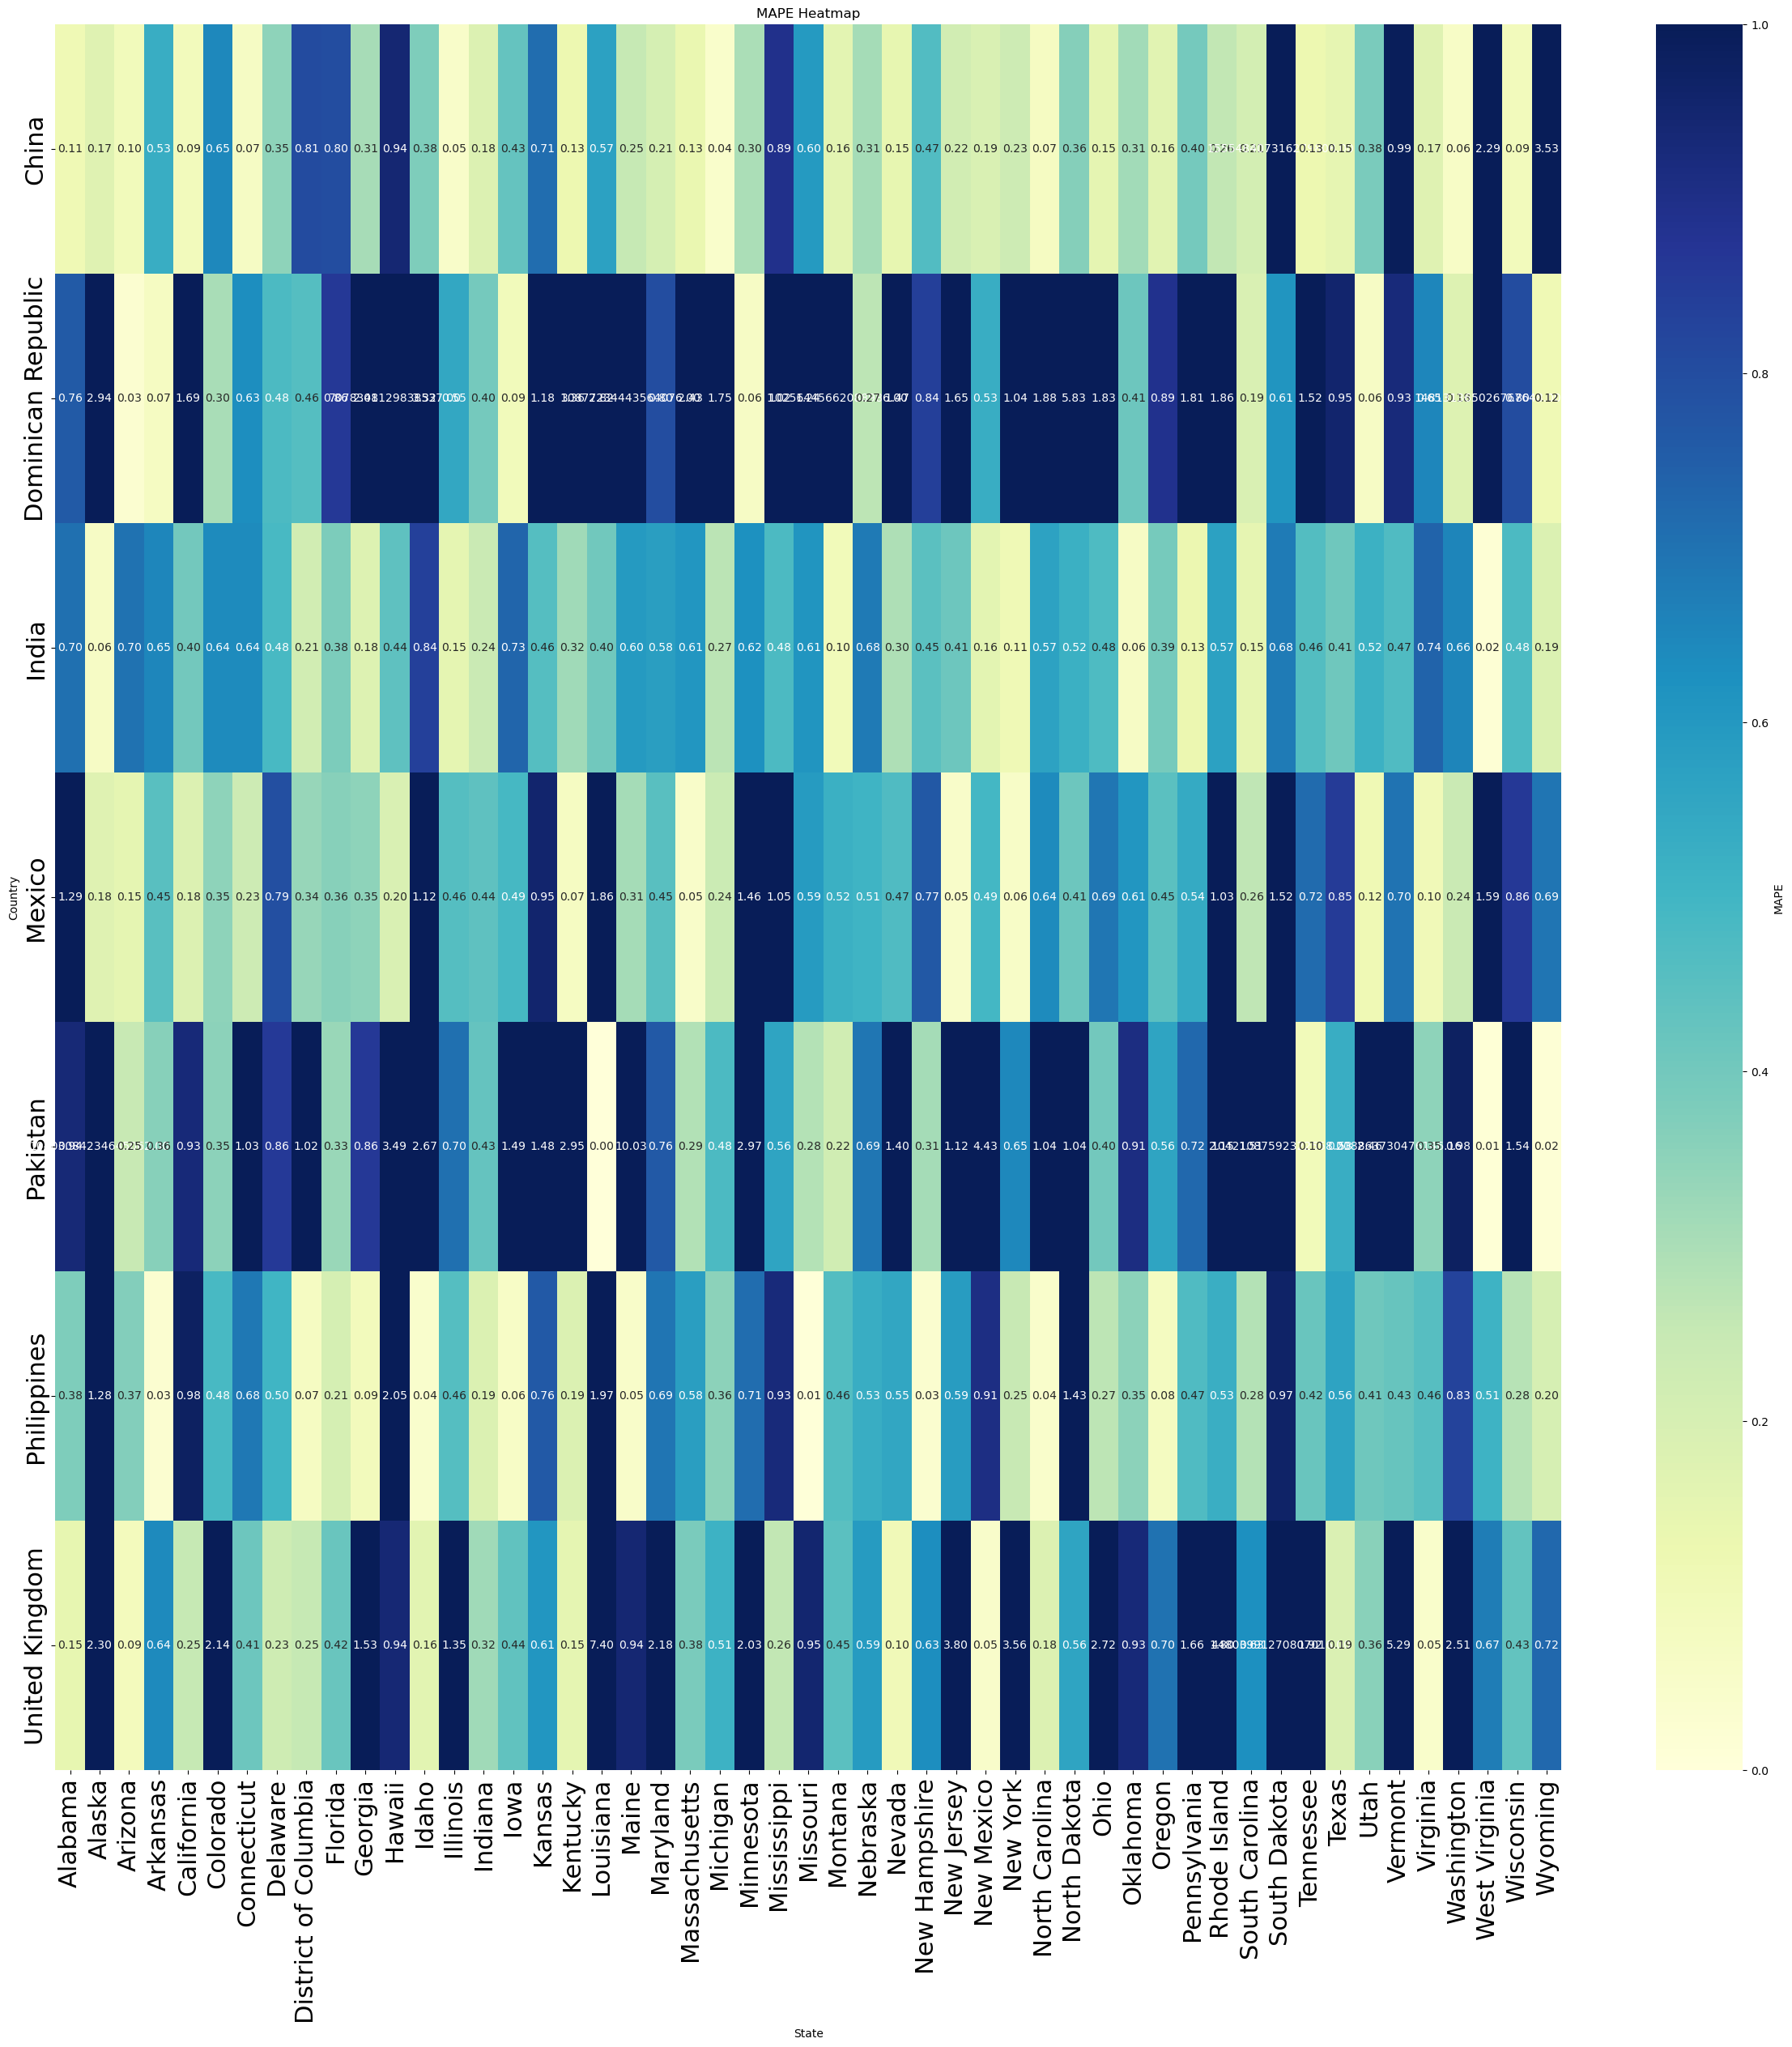

In [18]:


results_df["pred2023"] = results_df["pred2023"].astype(int)
results_df["pred2021"] = results_df["pred2021"].astype(int)
display(results_df)
print(results_df.describe())

import seaborn as sns
# Reshape the DataFrame to a pivot table for the heatmap
heatmap_df = results_df.pivot(index='Country', columns='State', values='MAPE')  # You can choose 'MAPE' here if needed

# Plot the heatmap
plt.figure(figsize=(30, 28))
sns.heatmap(heatmap_df, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'MAPE'},vmin=0, vmax=1)  # You can choose 'MAPE' here if needed
plt.title('MAPE Heatmap')
plt.xlabel('State')
plt.ylabel('Country')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


plt.show()

In [19]:
display(results_df[(results_df['State'] == 'South Dakota') & (results_df['Country'] == 'China')])

,Country,State,MAE,MAPE,pred2023,data2021,pred2021
41,China,South Dakota,34.538685,1.555484e+17,31,[0],34


In [20]:
display(results_df[(results_df['State'] == 'West Virginia') & (results_df['Country'] == 'Dominican Republic')])

,Country,State,MAE,MAPE,pred2023,data2021,pred2021
150,Dominican Republic,West Virginia,32.89177,1.481314e+17,31,[0],32


In [21]:
display(results_df[(results_df['State'] == 'South Dakota') & (results_df['Country'] == 'United Kingdom')])

,Country,State,MAE,MAPE,pred2023,data2021,pred2021
245,United Kingdom,South Dakota,9.948485,4.480399e+16,11,[0],9


In [22]:
mape_condition = results_df['MAPE'] < 0.3

# Group by 'Country' and 'State', and count the valid combinations
num_combinations_with_low_mape = results_df[mape_condition].groupby(['Country', 'State']).size().reset_index(name='Count')

print(num_combinations_with_low_mape)

            Country           State  Count
0             China         Alabama      1
1             China          Alaska      1
2             China         Arizona      1
3             China      California      1
4             China     Connecticut      1
..              ...             ...    ...
100  United Kingdom          Nevada      1
101  United Kingdom      New Mexico      1
102  United Kingdom  North Carolina      1
103  United Kingdom           Texas      1
104  United Kingdom        Virginia      1

[105 rows x 3 columns]


In [23]:

results_df.to_csv("Output/output_data_1.csv", index=False)

In [ ]:
# Close the database connection
conn.close()